# AV Behavior with friction implementation in rainy weather

In [1]:
import os
import pandas as pd
pd.set_option('display.max_colwidth', None)
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.stats
from scipy.stats import norm, binom, poisson
from dtaidistance import dtw
import json

## Testing Parameters

In [2]:
weather_param = [[20,0,0,5,0,0,0,10,0],
        [20,20,20,5,0,20,5,20,0],
        [40,40,40,5,0,40,10,30,0],
        [60,60,60,5,0,60,15,40,0],
        [80,80,80,5,0,80,20,50,0],
        [100,100,100,5,0,100,30,70,0]] 

def calc_fric(weather_list):
    return np.exp(-0.916*weather_list[5]/100) * (1-weather_list[5]/100)**3 * 0.6 + 0.4 - 0.1*weather_list[2]/100

for i in range(len(weather_param)):
    friction_ratio = calc_fric(weather_param[i])
    weather_param[i] += [friction_ratio]

df = pd.DataFrame(weather_param, columns =["cloudiness","precipitation","precipitation_deposits","sun_altitude_angle","sun_azimuth_angle","wetness","fog_density","wind_intensity", "ice_thickness", "friction_ratio"],
) 
# df.index.name = 'Scenarios'
df.to_csv("rain_fric.csv")
df

cloudiness  precipitation  precipitation_deposits  sun_altitude_angle  \
0          20              0                       0                   5   
1          20             20                      20                   5   
2          40             40                      40                   5   
3          60             60                      60                   5   
4          80             80                      80                   5   
5         100            100                     100                   5   

   sun_azimuth_angle  wetness  fog_density  wind_intensity  ice_thickness  \
0                  0        0            0              10              0   
1                  0       20            5              20              0   
2                  0       40           10              30              0   
3                  0       60           15              40              0   
4                  0       80           20              50              0   
5                  0      100           30              70              0   

   friction_ratio  
0        1.000000  
1        0.635775  
2        0.449842  
3        0.362164  
4        0.322307  
5        0.300000

### With reduced friction

In [3]:
os.chdir("C:\\Users\kilob\Senior Research & Thesis\\Simulations")

In [4]:
rel_path = "./Data/Ghost Cutin/Rain Reduced Friction Exponential"
os.path.isdir(rel_path)

True

In [5]:
subfolders = os.listdir(path=rel_path)
subfolders

['route_highway_epoch24_clear-sunset_fi_ghost_cutin',
 'route_highway_epoch24_rain-sunset-100_fi_ghost_cutin',
 'route_highway_epoch24_rain-sunset-20_fi_ghost_cutin',
 'route_highway_epoch24_rain-sunset-40_fi_ghost_cutin',
 'route_highway_epoch24_rain-sunset-60_fi_ghost_cutin',
 'route_highway_epoch24_rain-sunset-80_fi_ghost_cutin']

In [6]:
head = subfolders.pop(1)
subfolders.append(head)
subfolders

['route_highway_epoch24_clear-sunset_fi_ghost_cutin',
 'route_highway_epoch24_rain-sunset-20_fi_ghost_cutin',
 'route_highway_epoch24_rain-sunset-40_fi_ghost_cutin',
 'route_highway_epoch24_rain-sunset-60_fi_ghost_cutin',
 'route_highway_epoch24_rain-sunset-80_fi_ghost_cutin',
 'route_highway_epoch24_rain-sunset-100_fi_ghost_cutin']

In [7]:
txt_lists_fric = [[] for i in range(6)]

for i in range(len(txt_lists_fric)):
    for root, dirs, files in os.walk(os.path.join(rel_path, subfolders[i])):
        for file in files:
            if file.endswith(".txt"):
                 with open(os.path.join(root, file), encoding = 'utf-8') as f:
                    read_string = f.read()
                    json_object = json.loads(read_string)
                    txt_lists_fric[i].append(json_object)

In [8]:
txt_lists_fric[2][50]
# txt_lists_fric[0]

{'_checkpoint': {'global_record': {},
  'progress': [0, 1],
  'records': [{'index': 0,
    'infractions': {'collisions_layout': [],
     'collisions_pedestrian': [],
     'collisions_vehicle': ['Agent collided against object with type=vehicle.tesla.model3 and id=94988 at (x=193.156, y=-18.729, z=-0.02)'],
     'outside_route_lanes': [],
     'red_light': [],
     'route_dev': [],
     'route_timeout': [],
     'stop_infraction': [],
     'vehicle_blocked': []},
    'meta': {'duration_game': 10.700000159442425,
     'duration_system': 22.034821033477783,
     'route_length': 131.56012567009267},
    'route_id': 'RouteScenario_0',
    'scores': {'score_composed': 30.7297320251303,
     'score_penalty': 0.6,
     'score_route': 51.21622004188384},
    'status': 'Failed'}]},
 'eligible': False,
 'entry_status': 'Started',
 'labels': [],
 'sensors': ['carla_camera',
  'carla_camera',
  'carla_camera',
  'carla_imu',
  'carla_gnss',
  'carla_speedometer'],
 'values': []}

In [9]:
avg_complete_fric = [_] * 6

for i in range(len(txt_lists_fric)):
    count = 0
    for txt in txt_lists_fric[i]:
        if txt['_checkpoint']['records'][0]['status'] == 'Completed':
            count += 1
    avg_complete_fric[i] = count/100
    
df = pd.DataFrame({'Scenarios':subfolders, 'Average complete ratio':avg_complete_fric}) 
# df.index.name = 'Scenarios'

df

Scenarios  \
0     route_highway_epoch24_clear-sunset_fi_ghost_cutin   
1   route_highway_epoch24_rain-sunset-20_fi_ghost_cutin   
2   route_highway_epoch24_rain-sunset-40_fi_ghost_cutin   
3   route_highway_epoch24_rain-sunset-60_fi_ghost_cutin   
4   route_highway_epoch24_rain-sunset-80_fi_ghost_cutin   
5  route_highway_epoch24_rain-sunset-100_fi_ghost_cutin   

   Average complete ratio  
0                    1.00  
1                    0.00  
2                    0.00  
3                    0.99  
4                    0.02  
5                    1.00

In [10]:
count = 0

avg_score_fric = [_] * 6

for i in range(len(txt_lists_fric)):
    count = 0
    for txt in txt_lists_fric[i]:
        count += txt['_checkpoint']['records'][0]['scores']['score_route'] 
    avg_score_fric[i] = count/100
    
df = pd.DataFrame({'Scenarios':subfolders, 'Average score route':avg_score_fric}) 
df

Scenarios  Average score route
0     route_highway_epoch24_clear-sunset_fi_ghost_cutin           100.000000
1   route_highway_epoch24_rain-sunset-20_fi_ghost_cutin            52.803421
2   route_highway_epoch24_rain-sunset-40_fi_ghost_cutin            51.216220
3   route_highway_epoch24_rain-sunset-60_fi_ghost_cutin            99.481639
4   route_highway_epoch24_rain-sunset-80_fi_ghost_cutin            50.833619
5  route_highway_epoch24_rain-sunset-100_fi_ghost_cutin           100.000000

#### Setting up into list of DataFrames

In [11]:
os.chdir("C:\\Users\kilob\Senior Research & Thesis\\Simulations")

In [12]:
os.path.isdir("./Data/Ghost Cutin/Rain Original/Simulations Rain PC/route_highway_epoch24_clear-sunset_fi_ghost_cutin\\route_highway_epoch24_clear-sunset_fi_ghost_cutin_0\\")

True

In [13]:
df_array_fric = np.empty((6,100), dtype=object)

for i in range(len(df_array_fric)):
    for j in range((len(df_array_fric[i]))):
        df_array_fric[i][j] = pd.DataFrame()

In [14]:
for i in range(len(txt_lists_fric)):
    dir_path = os.path.join(rel_path, subfolders[i])
    print(dir_path)
    # list to store files
    res = []

    # Iterate directory
    run_index = 0
    for path in os.listdir(dir_path):
        # check if current path is a file
        if not os.path.isfile(os.path.join(dir_path, path)):
            df = pd.DataFrame()
            for file in os.listdir(os.path.join(dir_path, path)):
                file_path = os.path.join(dir_path, os.path.join(path, file))
    #             print("file_path", file_path)
                if "_ctl.csv" in file_path:
                    df = pd.read_csv(file_path)
                elif "_cvip.csv" in file_path:
                    temp = pd.read_csv(file_path)
                    df = pd.concat([df, temp], axis=1)
                elif "_traj.csv" in file_path:
                    temp = pd.read_csv(file_path)
                    df = pd.concat([df, temp], axis=1)

            df_array_fric[i][run_index] = df
            run_index += 1

./Data/Ghost Cutin/Rain Reduced Friction Exponential\route_highway_epoch24_clear-sunset_fi_ghost_cutin
./Data/Ghost Cutin/Rain Reduced Friction Exponential\route_highway_epoch24_rain-sunset-20_fi_ghost_cutin
./Data/Ghost Cutin/Rain Reduced Friction Exponential\route_highway_epoch24_rain-sunset-40_fi_ghost_cutin
./Data/Ghost Cutin/Rain Reduced Friction Exponential\route_highway_epoch24_rain-sunset-60_fi_ghost_cutin
./Data/Ghost Cutin/Rain Reduced Friction Exponential\route_highway_epoch24_rain-sunset-80_fi_ghost_cutin
./Data/Ghost Cutin/Rain Reduced Friction Exponential\route_highway_epoch24_rain-sunset-100_fi_ghost_cutin


In [15]:
df_array_fric[5][99]

ts  agent_id  throttle     steer  brake       ts  agent_id  \
0    2638577         0  0.900000 -0.046309    0.0  2638577         0   
1    2638578         0  0.900000  0.001818    0.0  2638578         0   
2    2638579         0  0.900000 -0.003174    0.0  2638579         0   
3    2638580         0  0.900000 -0.003877    0.0  2638580         0   
4    2638581         0  0.900000 -0.001845    0.0  2638581         0   
..       ...       ...       ...       ...    ...      ...       ...   
802  2639379         0  0.486600 -0.004502    0.0  2639379         0   
803  2639380         0  0.367031 -0.002686    0.0  2639380         0   
804  2639381         0  0.143084 -0.001957    0.0  2639381         0   
805  2639382         0  0.136039 -0.002250    0.0  2639382         0   
806  2639383         0  0.349327 -0.002348    0.0  2639383         0   

           cvip      cvip_x      cvip_y      cvip_z       ts  agent_id  \
0    500.497261  198.767441  -95.832657 -499.788727  2638577         0   
1      5.598742  195.567444  -90.832657    0.100000  2638578         0   
2      5.595580  195.567444  -90.832657    0.095407  2638579         0   
3      5.592744  195.567444  -90.832657    0.084691  2638580         0   
4      5.590235  195.567444  -90.832657    0.067854  2638581         0   
..          ...         ...         ...         ...      ...       ...   
802   55.982496  192.547241   99.075378   -0.068178  2639379         0   
803   56.092864  192.542313   99.407692   -0.068179  2639380         0   
804   56.203512  192.536987   99.740143   -0.068180  2639381         0   
805   56.314460  192.531219  100.072739   -0.068182  2639382         0   
806   56.425733  192.524872  100.405479   -0.068183  2639383         0   

              x          y         z         v  
0    192.362411 -86.262680  0.576039  0.000000  
1    192.362411 -86.262680  0.534733  0.000000  
2    192.362411 -86.262680  0.487313  0.000000  
3    192.362411 -86.262680  0.433781  0.000000  
4    192.362411 -86.262680  0.374139  0.000000  
..          ...        ...       ...       ...  
802  193.190659  43.096600 -0.021115  8.881254  
803  193.187103  43.318554 -0.021110  8.878301  
804  193.183624  43.540371 -0.021105  8.872542  
805  193.180283  43.762039 -0.021098  8.866352  
806  193.177078  43.983536 -0.021092  8.859101  

[807 rows x 17 columns]

In [16]:
df_array_fric[0][0]['x']

0      192.362411
1      192.362411
2      192.362411
3      192.362411
4      192.362411
          ...    
752    193.186905
753    193.184387
754    193.181885
755    193.179367
756    193.176895
Name: x, Length: 757, dtype: float64

### Without friction reduction

In [17]:
os.chdir("C:\\Users\kilob\Senior Research & Thesis\\Simulations")

In [18]:
rel_path = "./Data/Ghost Cutin/Rain Original/Simulations Rain PC"
os.path.isdir(rel_path)

True

In [19]:
subfolders = os.listdir(path=rel_path)
subfolders

['route_highway_epoch24_clear-sunset_fi_ghost_cutin',
 'route_highway_epoch24_rain-sunset-100_fi_ghost_cutin',
 'route_highway_epoch24_rain-sunset-20_fi_ghost_cutin',
 'route_highway_epoch24_rain-sunset-40_fi_ghost_cutin',
 'route_highway_epoch24_rain-sunset-60_fi_ghost_cutin',
 'route_highway_epoch24_rain-sunset-80_fi_ghost_cutin']

In [20]:
head = subfolders.pop(1)
subfolders.append(head)
subfolders

['route_highway_epoch24_clear-sunset_fi_ghost_cutin',
 'route_highway_epoch24_rain-sunset-20_fi_ghost_cutin',
 'route_highway_epoch24_rain-sunset-40_fi_ghost_cutin',
 'route_highway_epoch24_rain-sunset-60_fi_ghost_cutin',
 'route_highway_epoch24_rain-sunset-80_fi_ghost_cutin',
 'route_highway_epoch24_rain-sunset-100_fi_ghost_cutin']

In [21]:
txt_lists_fric = [[] for i in range(6)]

for i in range(len(txt_lists_fric)):
    for root, dirs, files in os.walk(os.path.join(rel_path, subfolders[i])):
        for file in files:
            if file.endswith(".txt"):
                 with open(os.path.join(root, file), encoding = 'utf-8') as f:
                    read_string = f.read()
                    json_object = json.loads(read_string)
                    txt_lists_fric[i].append(json_object)

In [22]:
txt_lists_fric[2][50]
# txt_lists_fric[0]

{'_checkpoint': {'global_record': {},
  'progress': [0, 1],
  'records': [{'index': 0,
    'infractions': {'collisions_layout': [],
     'collisions_pedestrian': [],
     'collisions_vehicle': [],
     'outside_route_lanes': [],
     'red_light': [],
     'route_dev': [],
     'route_timeout': [],
     'stop_infraction': [],
     'vehicle_blocked': []},
    'meta': {'duration_game': 19.125000284984708,
     'duration_system': 30.239914417266846,
     'route_length': 131.56012567009267},
    'route_id': 'RouteScenario_0',
    'scores': {'score_composed': 100.0,
     'score_penalty': 1.0,
     'score_route': 100.0},
    'status': 'Completed'}]},
 'eligible': False,
 'entry_status': 'Started',
 'labels': [],
 'sensors': ['carla_camera',
  'carla_camera',
  'carla_camera',
  'carla_imu',
  'carla_gnss',
  'carla_speedometer'],
 'values': []}

In [23]:
avg_complete_orig = [_] * 6

for i in range(len(txt_lists_fric)):
    count = 0
    for txt in txt_lists_fric[i]:
        if txt['_checkpoint']['records'][0]['status'] == 'Completed':
            count += 1
    avg_complete_orig[i] = count/100
    
df = pd.DataFrame({'Scenarios':subfolders, 'Average complete ratio':avg_complete_orig}) 
# df.index.name = 'Scenarios'

df

Scenarios  \
0     route_highway_epoch24_clear-sunset_fi_ghost_cutin   
1   route_highway_epoch24_rain-sunset-20_fi_ghost_cutin   
2   route_highway_epoch24_rain-sunset-40_fi_ghost_cutin   
3   route_highway_epoch24_rain-sunset-60_fi_ghost_cutin   
4   route_highway_epoch24_rain-sunset-80_fi_ghost_cutin   
5  route_highway_epoch24_rain-sunset-100_fi_ghost_cutin   

   Average complete ratio  
0                     1.0  
1                     1.0  
2                     1.0  
3                     1.0  
4                     1.0  
5                     1.0

In [24]:
count = 0

avg_score_orig = [_] * 6

for i in range(len(txt_lists_fric)):
    count = 0
    for txt in txt_lists_fric[i]:
        count += txt['_checkpoint']['records'][0]['scores']['score_route'] 
    avg_score_orig[i] = count/100
    
df = pd.DataFrame({'Scenarios':subfolders, 'Average score route':avg_score_orig}) 
df

Scenarios  Average score route
0     route_highway_epoch24_clear-sunset_fi_ghost_cutin                100.0
1   route_highway_epoch24_rain-sunset-20_fi_ghost_cutin                100.0
2   route_highway_epoch24_rain-sunset-40_fi_ghost_cutin                100.0
3   route_highway_epoch24_rain-sunset-60_fi_ghost_cutin                100.0
4   route_highway_epoch24_rain-sunset-80_fi_ghost_cutin                100.0
5  route_highway_epoch24_rain-sunset-100_fi_ghost_cutin                100.0

#### Setting up into list of DataFrames

In [25]:
os.chdir("C:\\Users\kilob\Senior Research & Thesis\\Simulations")

In [26]:
os.path.isdir("./Data/Ghost Cutin/Rain Original/Simulations Rain PC/route_highway_epoch24_clear-sunset_fi_ghost_cutin\\route_highway_epoch24_clear-sunset_fi_ghost_cutin_0\\")

True

In [27]:
df_array_orig = np.empty((6,100), dtype=object)

for i in range(len(df_array_orig)):
    for j in range((len(df_array_orig[i]))):
        df_array_orig[i][j] = pd.DataFrame()

In [28]:
rel_path = "./Data/Ghost Cutin/Rain Original/Simulations Rain PC/"

for i in range(len(txt_lists_fric)):
    dir_path = os.path.join(rel_path, subfolders[i])
    print(dir_path)
    
    # list to store files
    res = []

    # Iterate directory
    run_index = 0
    for path in os.listdir(dir_path):
        # check if current path is a file
        if not os.path.isfile(os.path.join(dir_path, path)):
            df = pd.DataFrame()
            for file in os.listdir(os.path.join(dir_path, path)):
                file_path = os.path.join(dir_path, os.path.join(path, file))
    #             print("file_path", file_path)
                if "_ctl.csv" in file_path:
                    df = pd.read_csv(file_path)
                elif "_cvip.csv" in file_path:
                    temp = pd.read_csv(file_path)
                    df = pd.concat([df, temp], axis=1)
                elif "_traj.csv" in file_path:
                    temp = pd.read_csv(file_path)
                    df = pd.concat([df, temp], axis=1)

            df_array_orig[i][run_index] = df
            run_index += 1

./Data/Ghost Cutin/Rain Original/Simulations Rain PC/route_highway_epoch24_clear-sunset_fi_ghost_cutin
./Data/Ghost Cutin/Rain Original/Simulations Rain PC/route_highway_epoch24_rain-sunset-20_fi_ghost_cutin
./Data/Ghost Cutin/Rain Original/Simulations Rain PC/route_highway_epoch24_rain-sunset-40_fi_ghost_cutin
./Data/Ghost Cutin/Rain Original/Simulations Rain PC/route_highway_epoch24_rain-sunset-60_fi_ghost_cutin
./Data/Ghost Cutin/Rain Original/Simulations Rain PC/route_highway_epoch24_rain-sunset-80_fi_ghost_cutin
./Data/Ghost Cutin/Rain Original/Simulations Rain PC/route_highway_epoch24_rain-sunset-100_fi_ghost_cutin


In [29]:
df_array_orig[5][99]

ts  agent_id  throttle     steer  brake       ts  agent_id  \
0    2489301         0  0.900000 -0.012481    0.0  2489301         0   
1    2489302         0  0.900000 -0.001971    0.0  2489302         0   
2    2489303         0  0.900000 -0.002299    0.0  2489303         0   
3    2489304         0  0.900000  0.000192    0.0  2489304         0   
4    2489305         0  0.900000 -0.000547    0.0  2489305         0   
..       ...       ...       ...       ...    ...      ...       ...   
758  2490059         0  0.419231 -0.002111    0.0  2490059         0   
759  2490060         0  0.217665 -0.001856    0.0  2490060         0   
760  2490061         0  0.244805 -0.002024    0.0  2490061         0   
761  2490062         0  0.444254 -0.001082    0.0  2490062         0   
762  2490063         0  0.502799 -0.002035    0.0  2490063         0   

           cvip      cvip_x      cvip_y      cvip_z       ts  agent_id  \
0    500.491189  198.767441  -95.832657 -499.819366  2489301         0   
1      5.595580  195.567444  -90.832657    0.100000  2489302         0   
2      5.592365  195.567444  -90.832657    0.095407  2489303         0   
3      5.589578  195.567444  -90.832657    0.084691  2489304         0   
4      5.587154  195.567444  -90.832657    0.069311  2489305         0   
..          ...         ...         ...         ...      ...       ...   
758   56.819623  192.527084   99.899643    0.001829  2490059         0   
759   56.927476  192.519760  100.232491    0.001824  2490060         0   
760   57.035954  192.511963  100.565674    0.001821  2490061         0   
761   57.145036  192.503708  100.899216    0.001817  2490062         0   
762   57.254690  192.494583  101.233055    0.001814  2490063         0   

              x          y         z         v  
0    192.362411 -86.262680  0.539326  0.000000  
1    192.362411 -86.262680  0.491906  0.000000  
2    192.362411 -86.262680  0.438374  0.000000  
3    192.362411 -86.262680  0.378732  0.000000  
4    192.362411 -86.262680  0.312981  0.000000  
..          ...        ...       ...       ...  
758  193.190323  43.083900  0.033927  9.010618  
759  193.187576  43.308941  0.033934  8.999552  
760  193.184875  43.533699  0.033941  8.988723  
761  193.182205  43.758217  0.033948  8.979064  
762  193.179550  43.982471  0.033954  8.968092  

[763 rows x 17 columns]

In [30]:
df_array_orig[2][1]['x']

0      192.362411
1      192.362411
2      192.362411
3      192.362411
4      192.362411
          ...    
761    193.198181
762    193.195145
763    193.192139
764    193.189209
765    193.186340
Name: x, Length: 766, dtype: float64

## Comparing completion rate and scores

In [31]:
avg_score_orig
avg_score_fric
avg_complete_orig
avg_complete_fric

[1.0, 0.0, 0.0, 0.99, 0.02, 1.0]

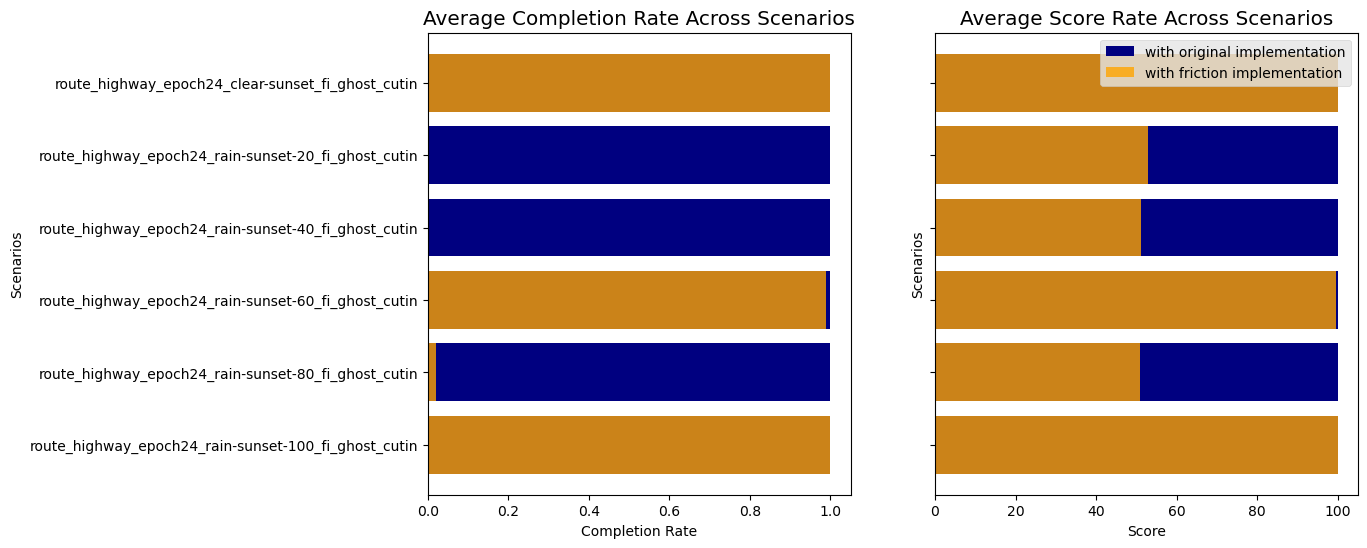

In [32]:
friction_legend = ["with original implementation", "with friction implementation"]

plt.subplots(1, 2, sharey=True, figsize=(12,6))
plt.gca().invert_yaxis()
width = 0.25

plt.subplot(1, 2, 1)
plt.style.use('ggplot')
plt.barh(subfolders, avg_complete_orig, label=friction_legend[0], color="navy")
plt.barh(subfolders, avg_complete_fric, label=friction_legend[1], color="orange" , alpha = 0.8)
plt.title('Average Completion Rate Across Scenarios')
plt.ylabel('Scenarios')
plt.xlabel('Completion Rate')


plt.subplot(1, 2, 2)
plt.style.use('ggplot')
plt.barh(subfolders, avg_score_orig, label=friction_legend[0], color="navy")
plt.barh(subfolders, avg_score_fric, label=friction_legend[1], color="orange" , alpha = 0.8)
plt.title('Average Score Rate Across Scenarios')
plt.ylabel('Scenarios')
plt.xlabel('Score')

plt.legend()
plt.show()

## Comparison

In [33]:
attribute_order = ["x", "y", "v", "cvip", "steer", "brake", "throttle"]

all_medians = np.empty((len(txt_lists_fric), len(attribute_order), 2), dtype=object)
# [[[], []] * len(attribute_order)  for i in range(len(txt_lists_fric))]

all_medians

array([[[None, None],
        [None, None],
        [None, None],
        [None, None],
        [None, None],
        [None, None],
        [None, None]],

       [[None, None],
        [None, None],
        [None, None],
        [None, None],
        [None, None],
        [None, None],
        [None, None]],

       [[None, None],
        [None, None],
        [None, None],
        [None, None],
        [None, None],
        [None, None],
        [None, None]],

       [[None, None],
        [None, None],
        [None, None],
        [None, None],
        [None, None],
        [None, None],
        [None, None]],

       [[None, None],
        [None, None],
        [None, None],
        [None, None],
        [None, None],
        [None, None],
        [None, None]],

       [[None, None],
        [None, None],
        [None, None],
        [None, None],
        [None, None],
        [None, None],
        [None, None]]], dtype=object)

In [34]:

full_legend = subfolders.copy()
# for i in range(len(subfolders)):
#     for j in range(len(friction_legend)):
#         full_legend.append(subfolders[i]+friction_legend[j])

full_legend

['route_highway_epoch24_clear-sunset_fi_ghost_cutin',
 'route_highway_epoch24_rain-sunset-20_fi_ghost_cutin',
 'route_highway_epoch24_rain-sunset-40_fi_ghost_cutin',
 'route_highway_epoch24_rain-sunset-60_fi_ghost_cutin',
 'route_highway_epoch24_rain-sunset-80_fi_ghost_cutin',
 'route_highway_epoch24_rain-sunset-100_fi_ghost_cutin']

### x,y traces

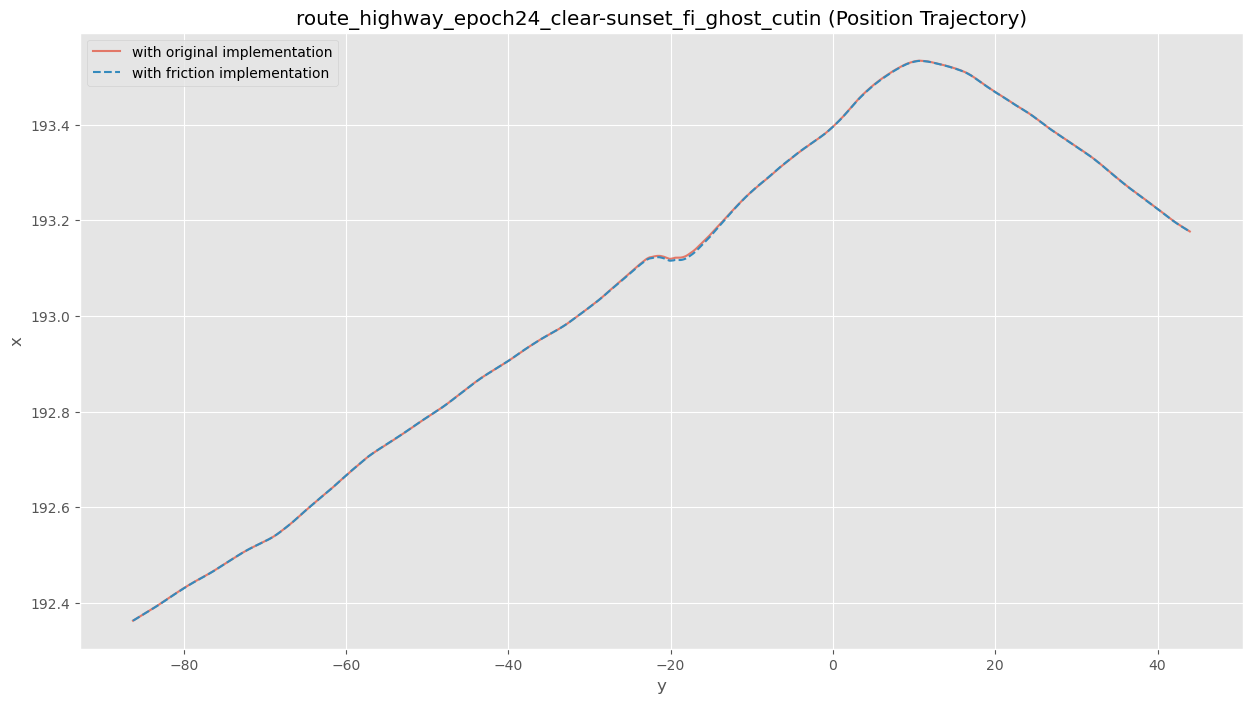

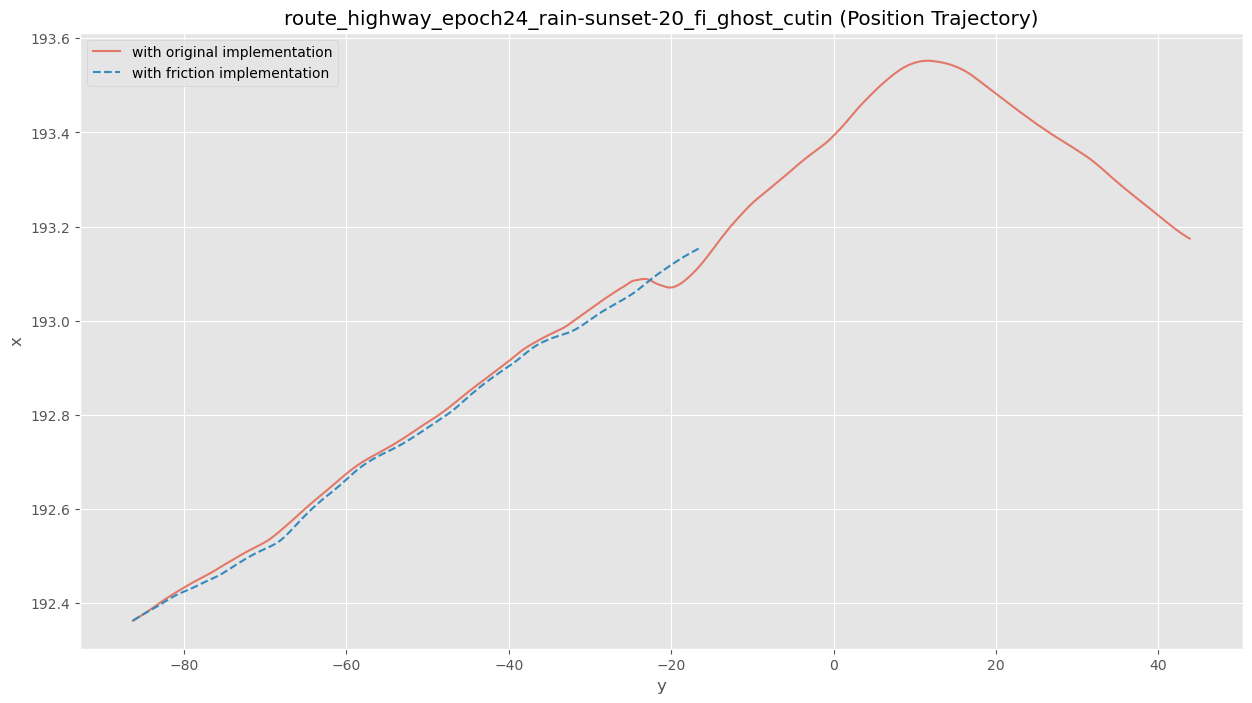

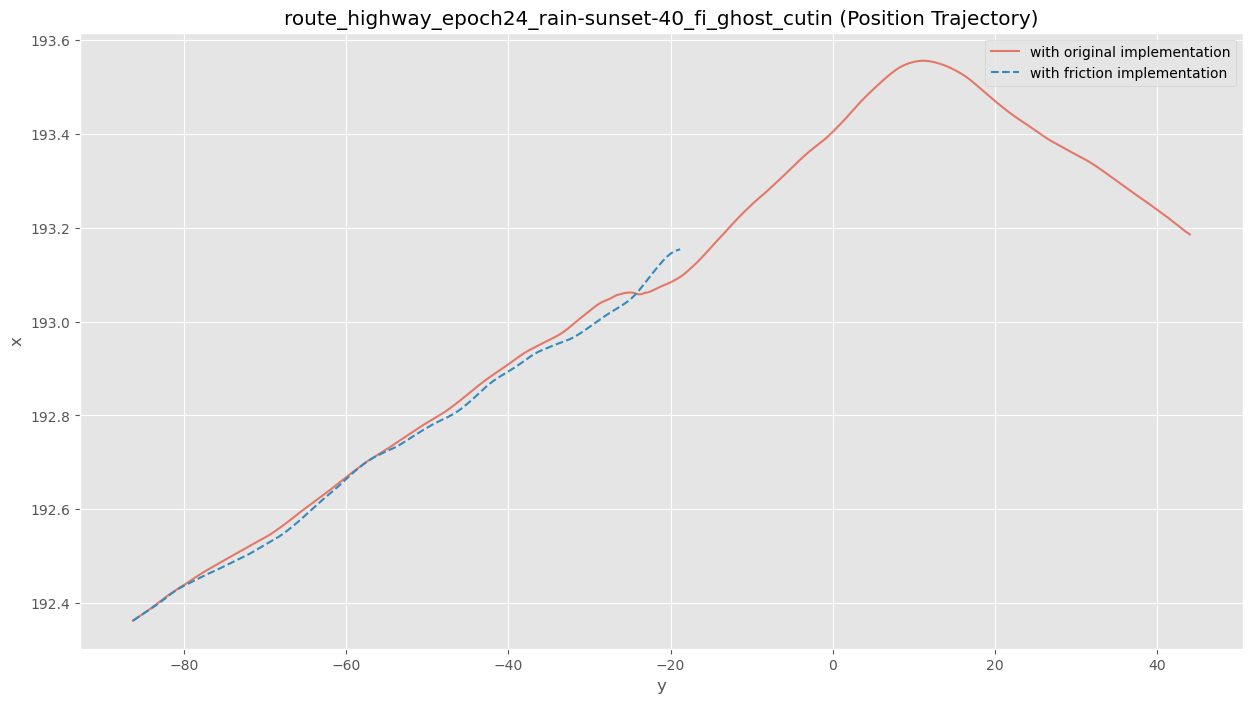

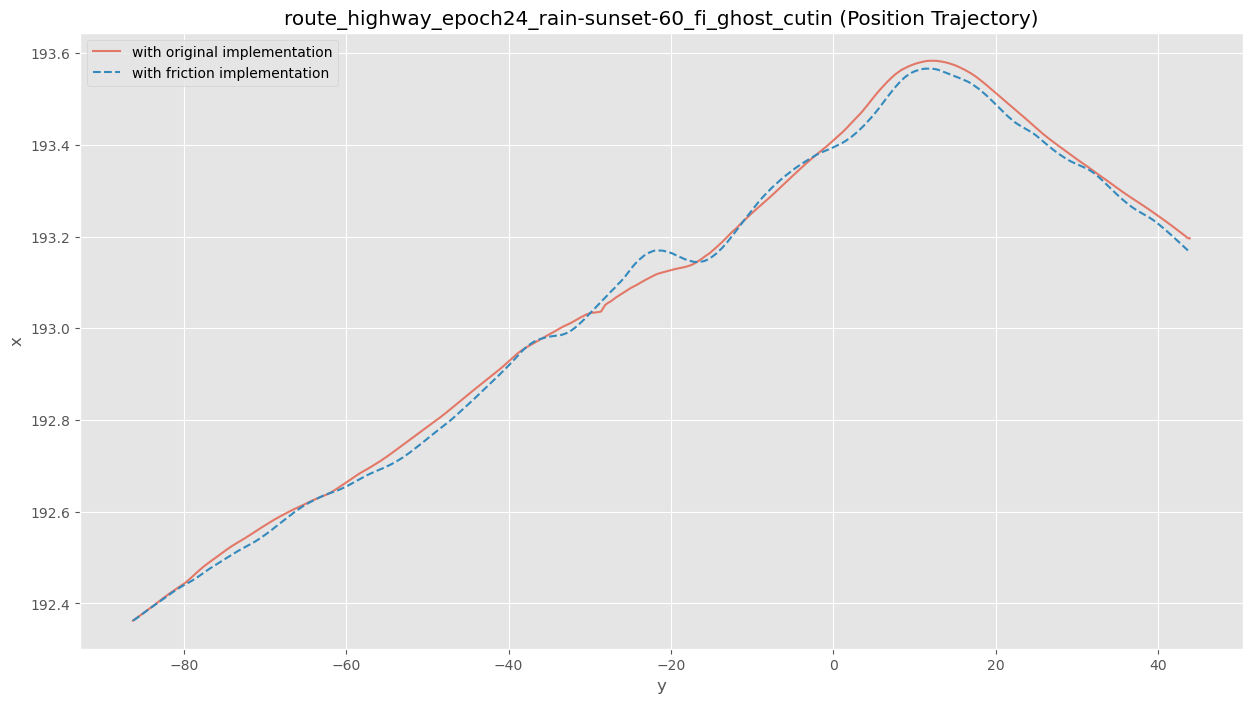

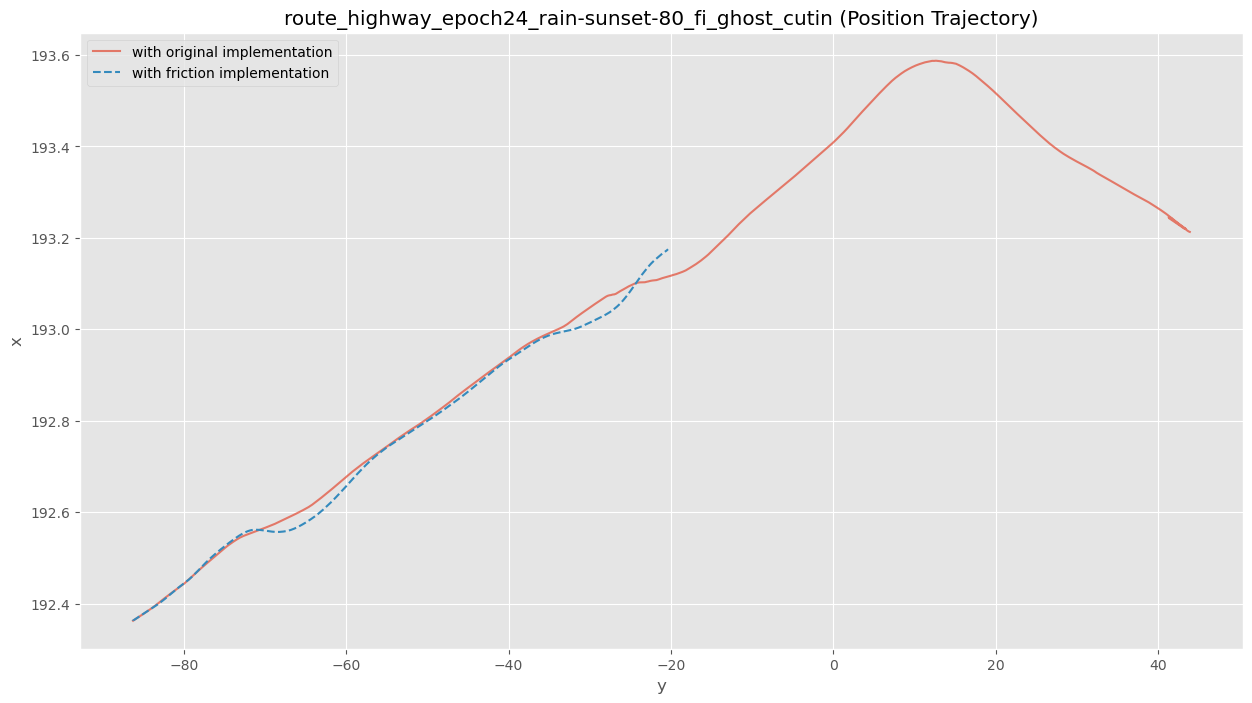

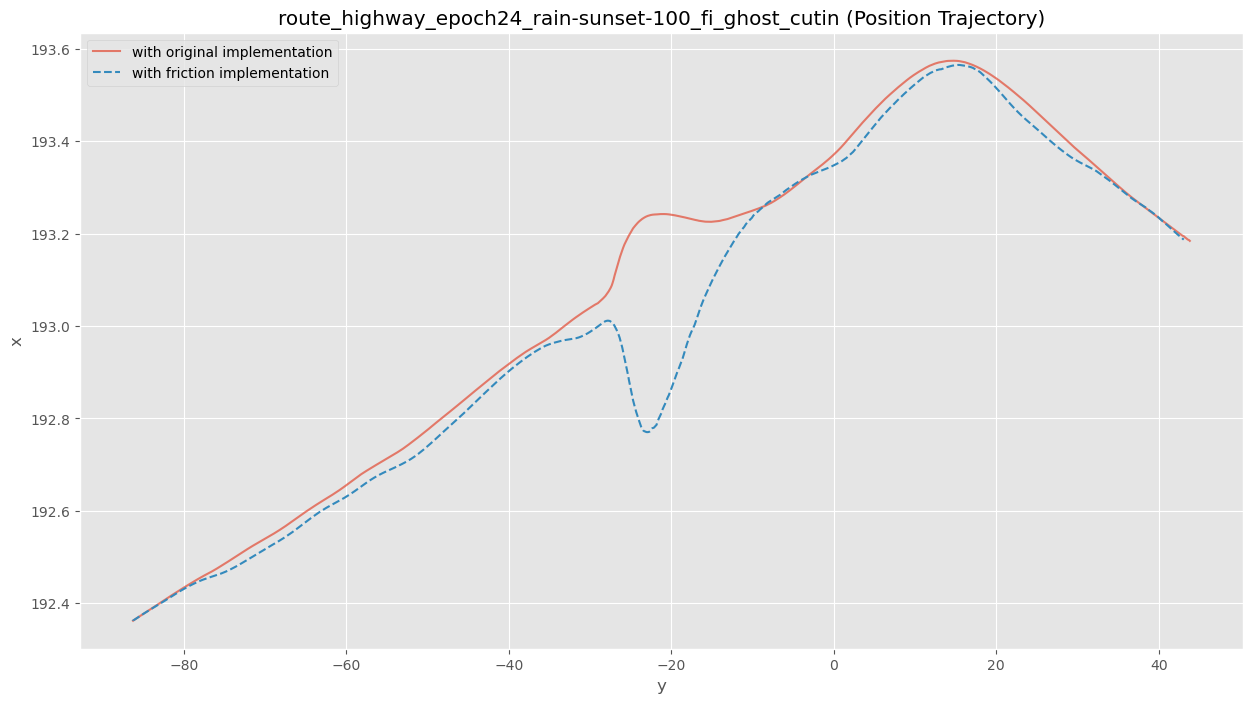

In [35]:
for weather in range(len(txt_lists_fric)):
    plt.figure(figsize=(15,8))
    df_orig_x = pd.DataFrame()
    df_orig_y = pd.DataFrame()

    for i in range(0, len(df_array_orig[weather])):
        if(df_array_orig[weather][i]['x'].dtypes == 'object' or df_array_orig[weather][i]['y'].dtypes == 'object'):
            print(i)
        else:
            if not df_array_orig[weather][i]['x'].isnull().values.any() and not df_array_orig[weather][i]['y'].isnull().values.any():
                df_orig_x["Run"+str(i)] = df_array_orig[weather][i]['x']
                df_orig_y["Run"+str(i)] = df_array_orig[weather][i]['y']

    median_orig_x = df_orig_x.median(axis=1)
    median_orig_y = df_orig_y.median(axis=1)

    plt.plot(median_orig_y, median_orig_x, alpha=0.7)


    df_fric_x = pd.DataFrame()
    df_fric_y = pd.DataFrame()

    for i in range(0, len(df_array_fric[weather])):
        if(df_array_fric[weather][i]['x'].dtypes == 'object' or df_array_fric[weather][i]['y'].dtypes == 'object'):
            print(i)
        else:
            if not df_array_fric[weather][i]['x'].isnull().values.any() and not df_array_fric[weather][i]['y'].isnull().values.any():
                df_fric_x["Run"+str(i)] = df_array_fric[weather][i]['x']
                df_fric_y["Run"+str(i)] = df_array_fric[weather][i]['y']

    median_fric_x = df_fric_x.median(axis=1)
    median_fric_y = df_fric_y.median(axis=1)

    
    all_medians[weather][0][0] = median_orig_x
    all_medians[weather][0][1] = median_fric_x
    all_medians[weather][1][0] = median_orig_y
    all_medians[weather][1][1] = median_fric_y
    
    plt.plot(median_fric_y, median_fric_x, '--')
    plt.xlabel("y")
    plt.ylabel("x")
    
    plt.title(subfolders[weather] + " (Position Trajectory)")
    plt.legend(friction_legend)
    plt.show()
    

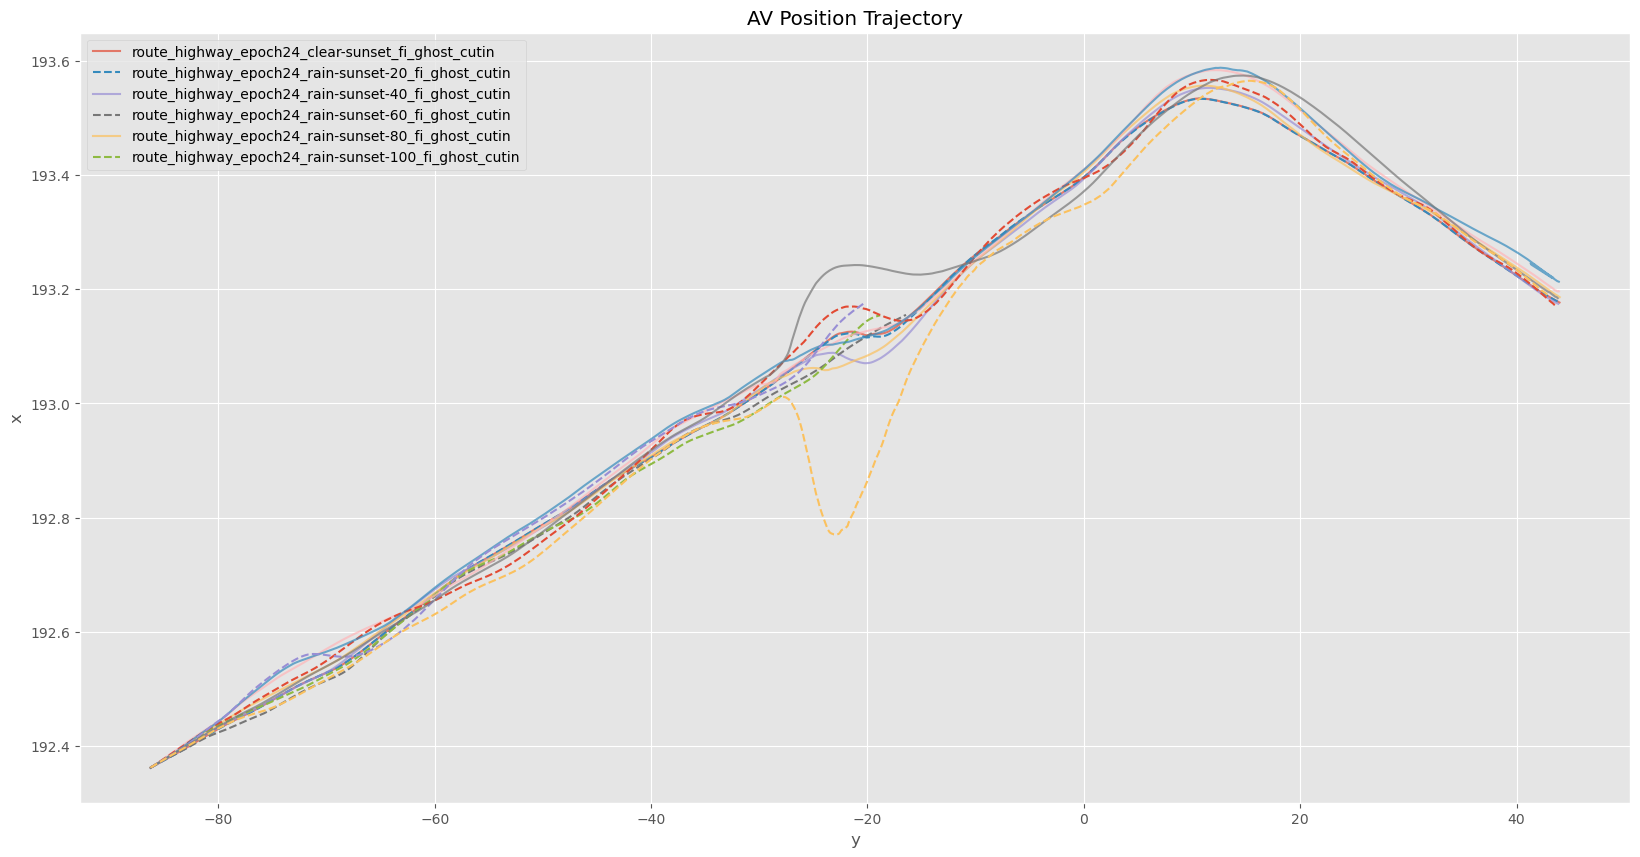

In [36]:
plt.figure(figsize=(20,10))

for weather in range(len(txt_lists_fric)):
    df_orig_x = pd.DataFrame()
    df_orig_y = pd.DataFrame()

    for i in range(0, len(df_array_orig[weather])):
        if(df_array_orig[weather][i]['x'].dtypes == 'object' or df_array_orig[weather][i]['y'].dtypes == 'object'):
            print(i)
        else:
            if not df_array_orig[weather][i]['x'].isnull().values.any() and not df_array_orig[weather][i]['y'].isnull().values.any():
                df_orig_x["Run"+str(i)] = df_array_orig[weather][i]['x']
                df_orig_y["Run"+str(i)] = df_array_orig[weather][i]['y']

    median_orig_x = df_orig_x.median(axis=1)
    median_orig_y = df_orig_y.median(axis=1)

    plt.plot(median_orig_y, median_orig_x, alpha=0.7)


    df_fric_x = pd.DataFrame()
    df_fric_y = pd.DataFrame()

    for i in range(0, len(df_array_fric[weather])):
        if(df_array_fric[weather][i]['x'].dtypes == 'object' or df_array_fric[weather][i]['y'].dtypes == 'object'):
            print(i)
        else:
            if not df_array_fric[weather][i]['x'].isnull().values.any() and not df_array_fric[weather][i]['y'].isnull().values.any():
                df_fric_x["Run"+str(i)] = df_array_fric[weather][i]['x']
                df_fric_y["Run"+str(i)] = df_array_fric[weather][i]['y']

    median_fric_x = df_fric_x.median(axis=1)
    median_fric_y = df_fric_y.median(axis=1)

    plt.plot(median_fric_y, median_fric_x, '--')
    
# plt.axis('equal')
plt.xlabel("y")
plt.ylabel("x")
plt.title("AV Position Trajectory")
plt.legend(full_legend)
plt.show()

### v

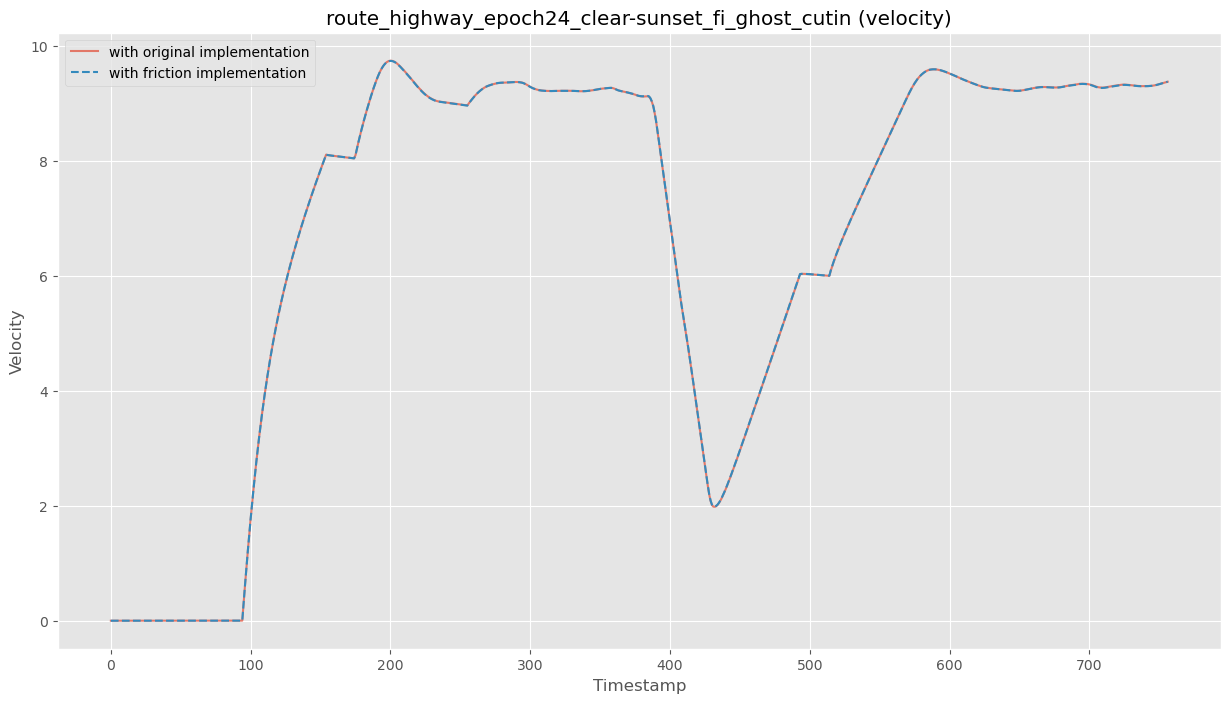

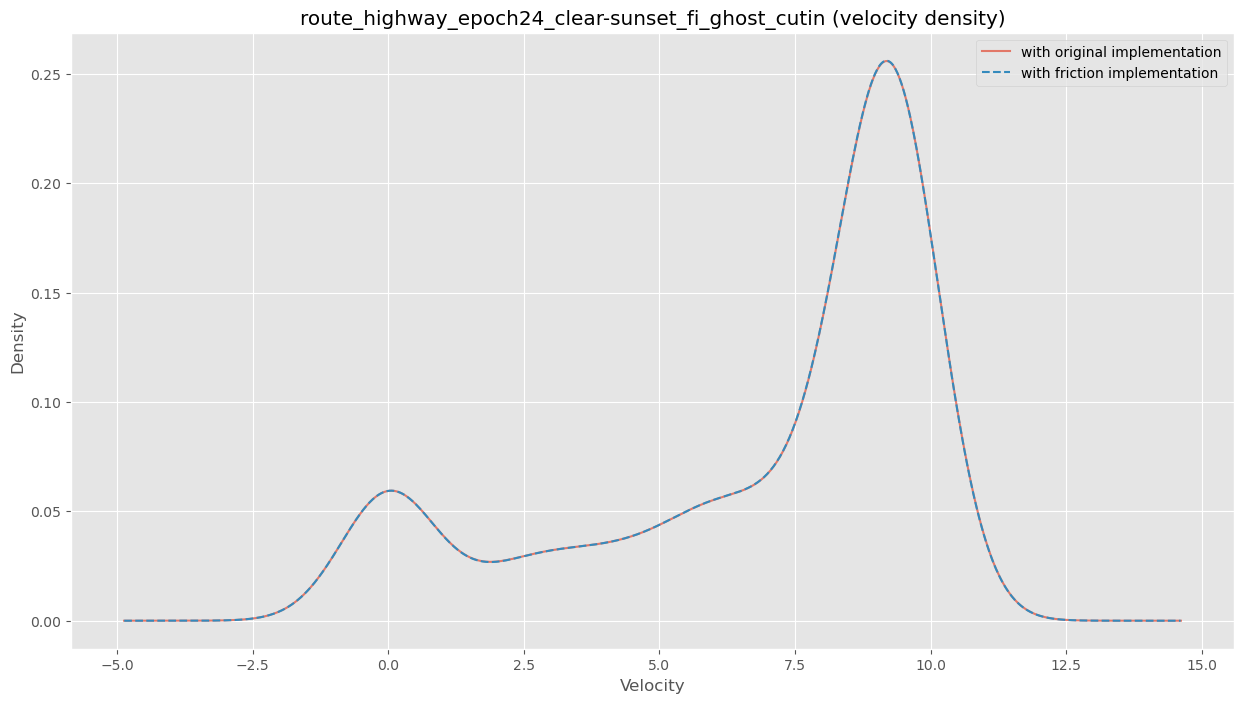

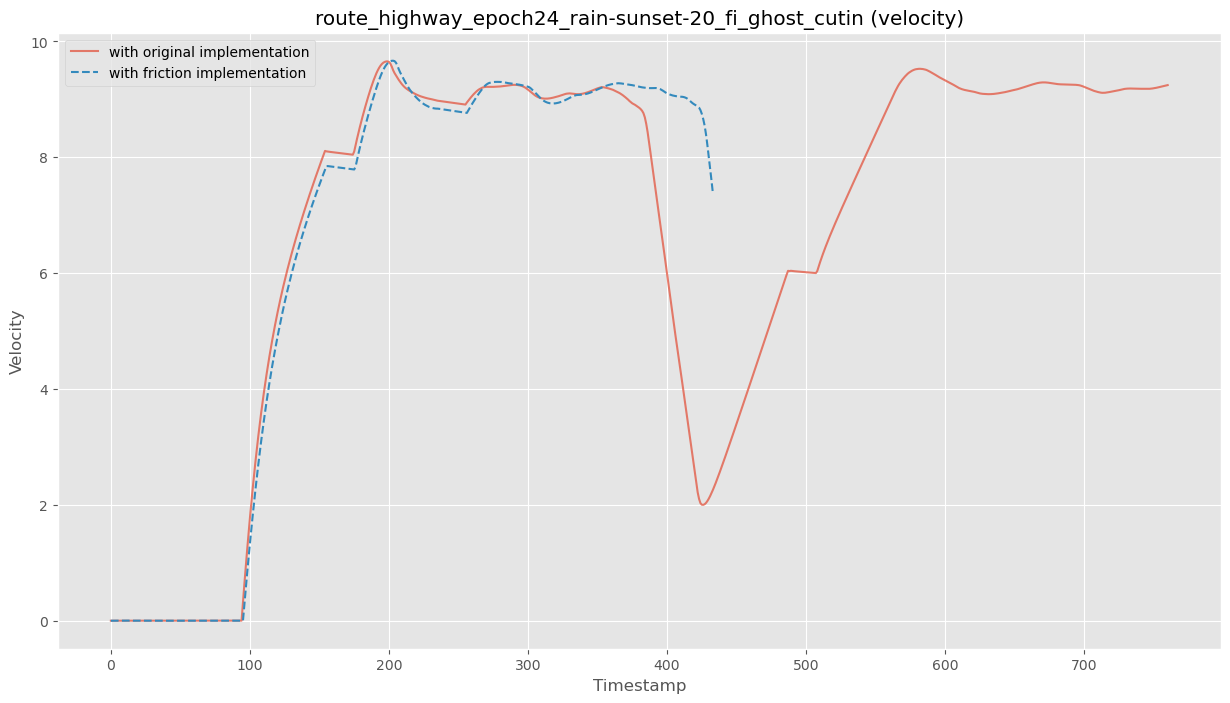

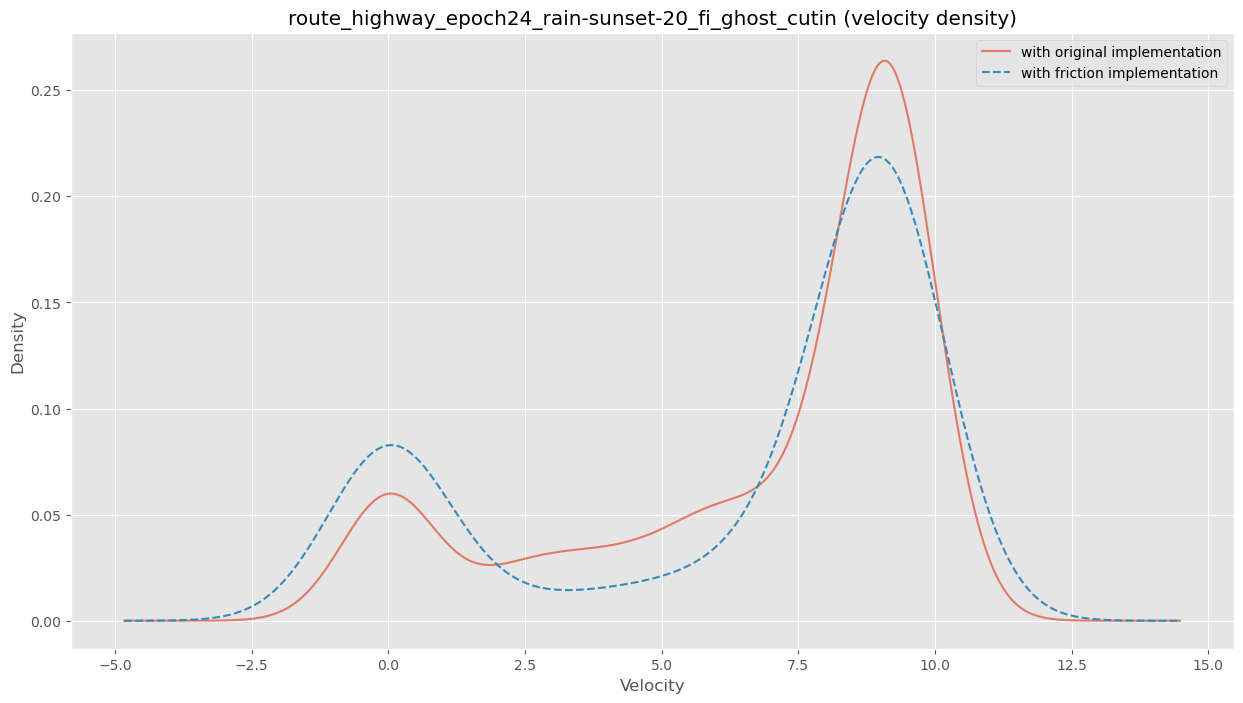

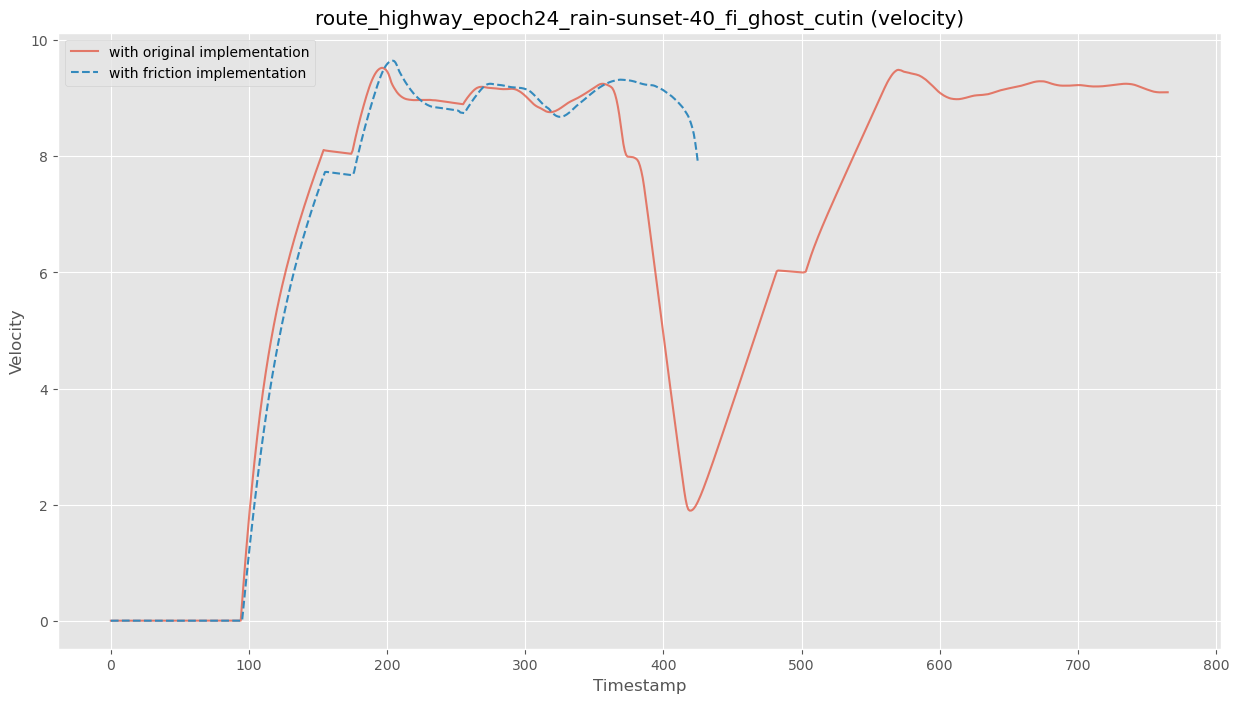

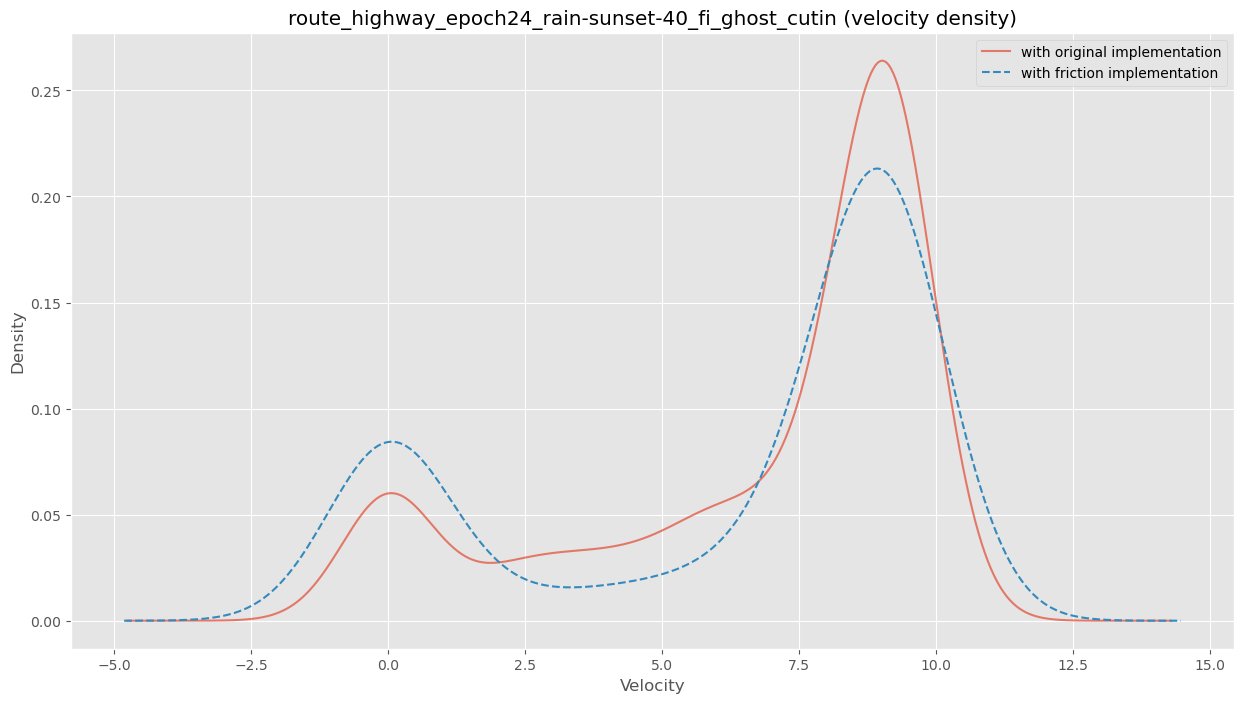

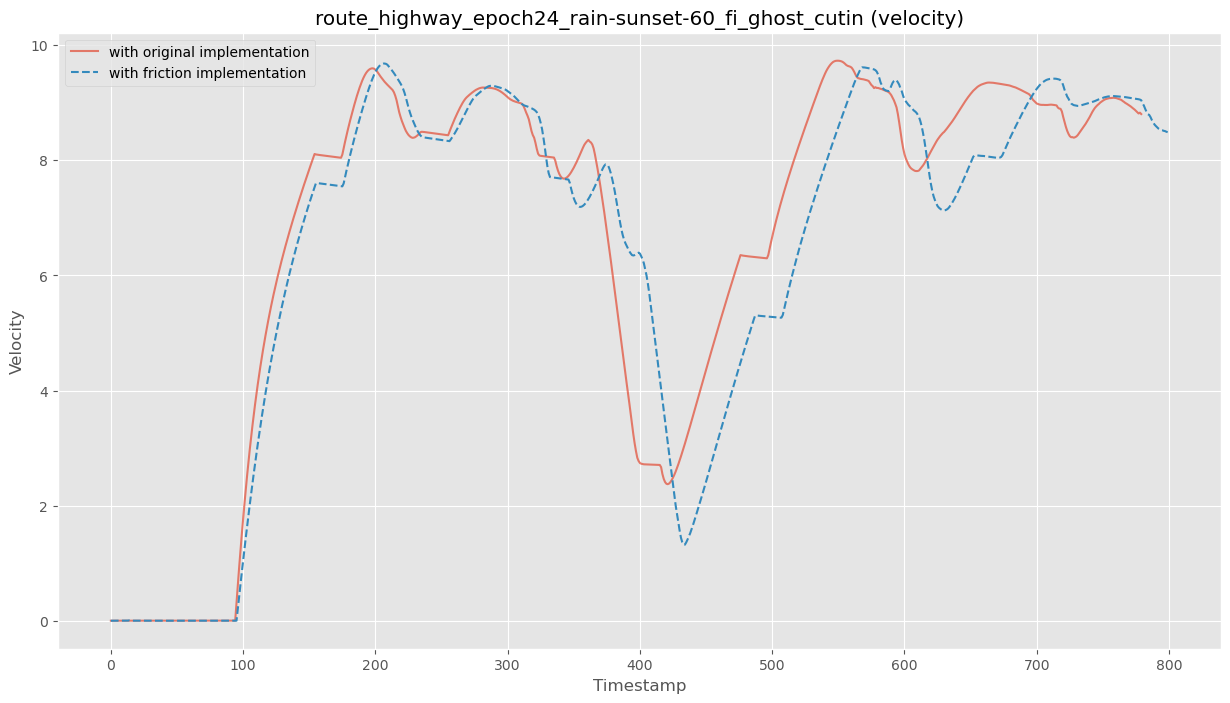

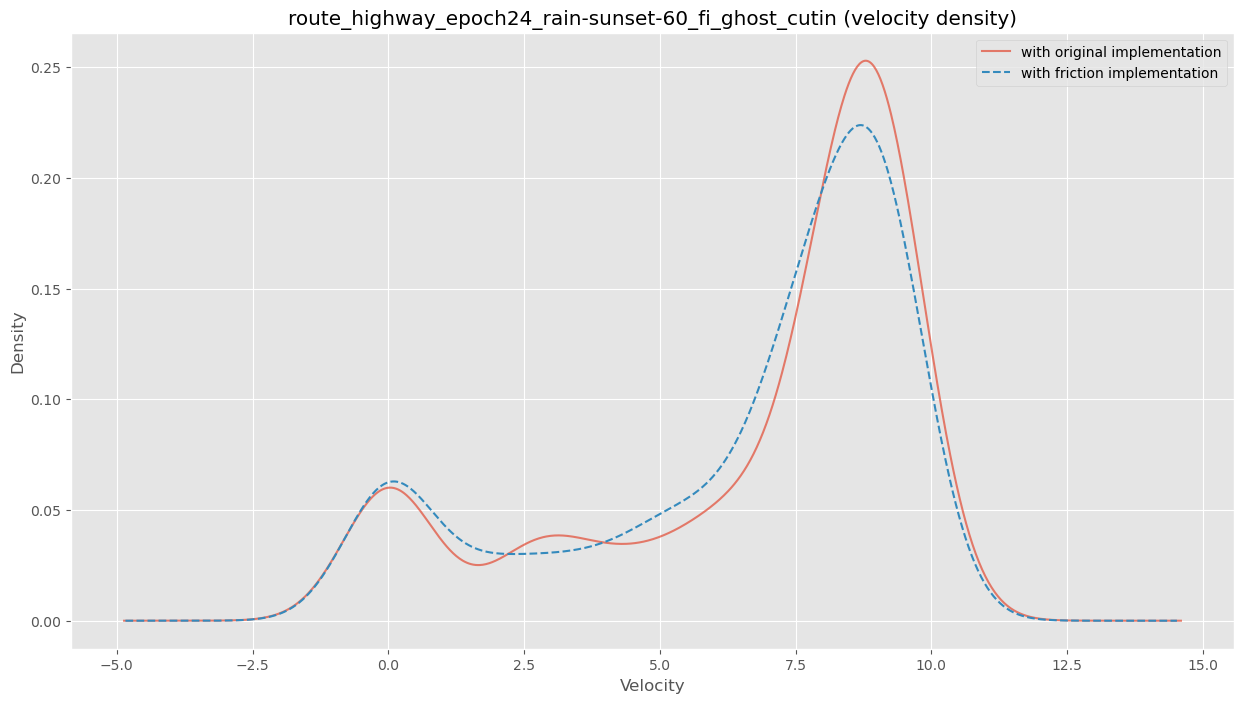

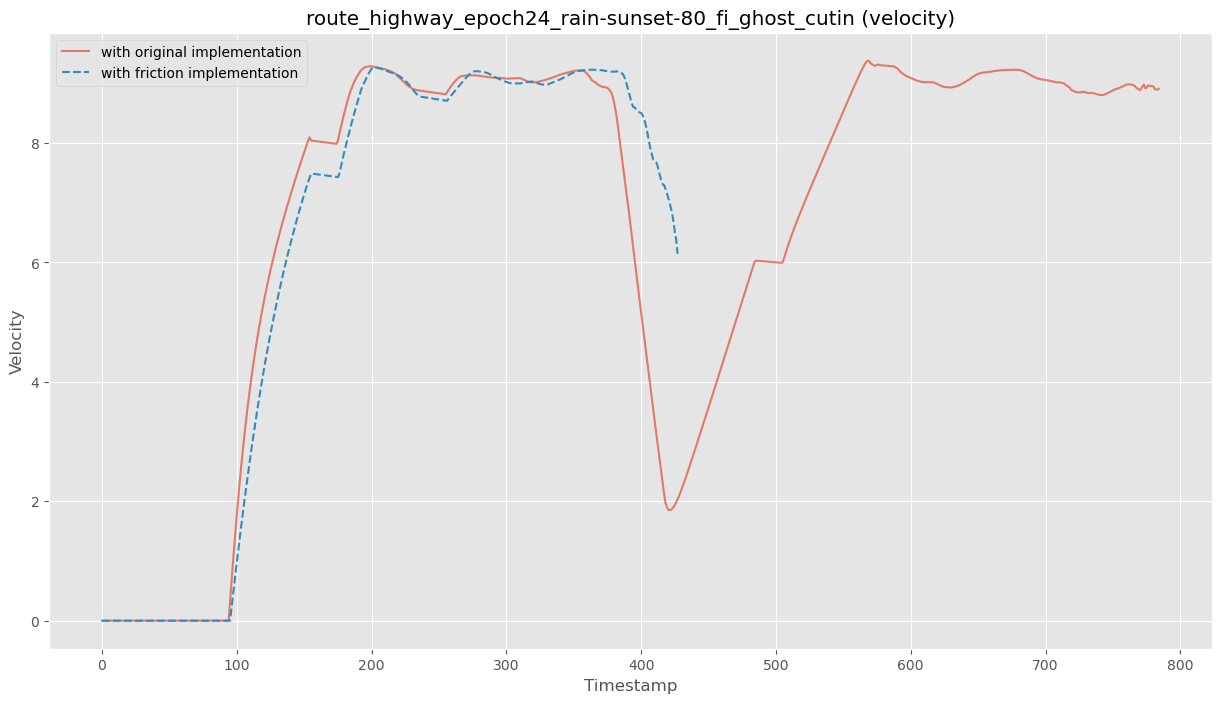

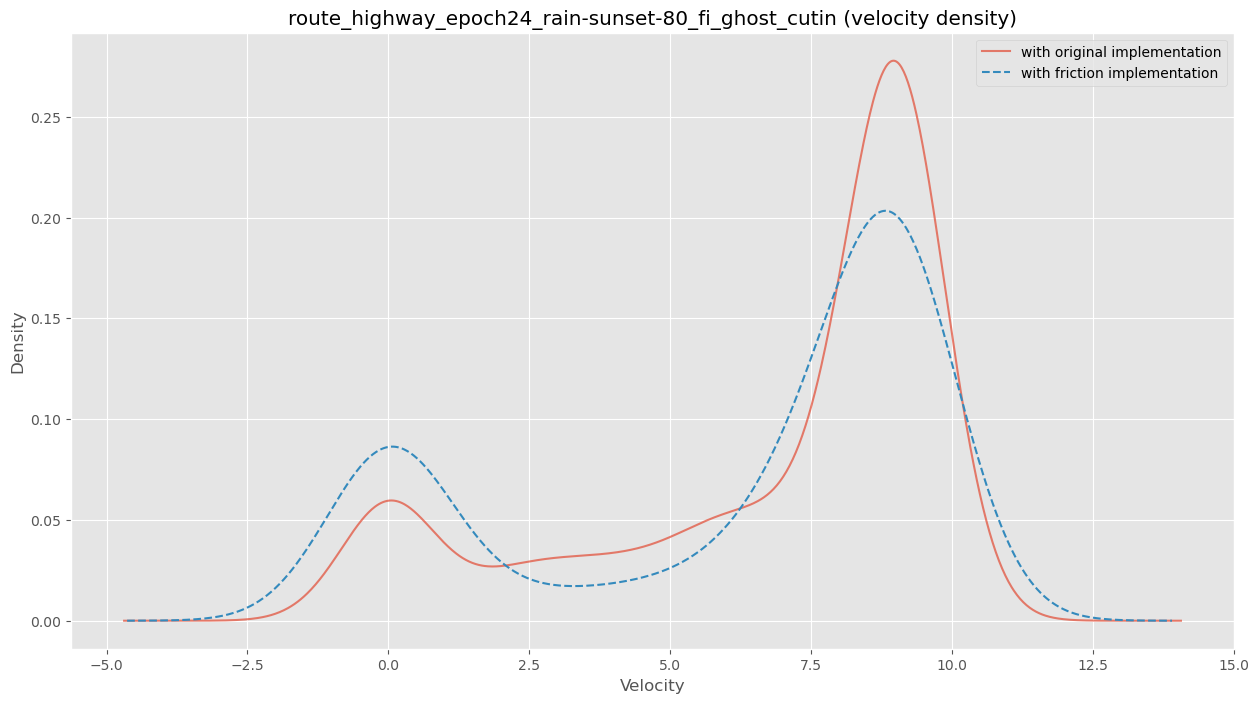

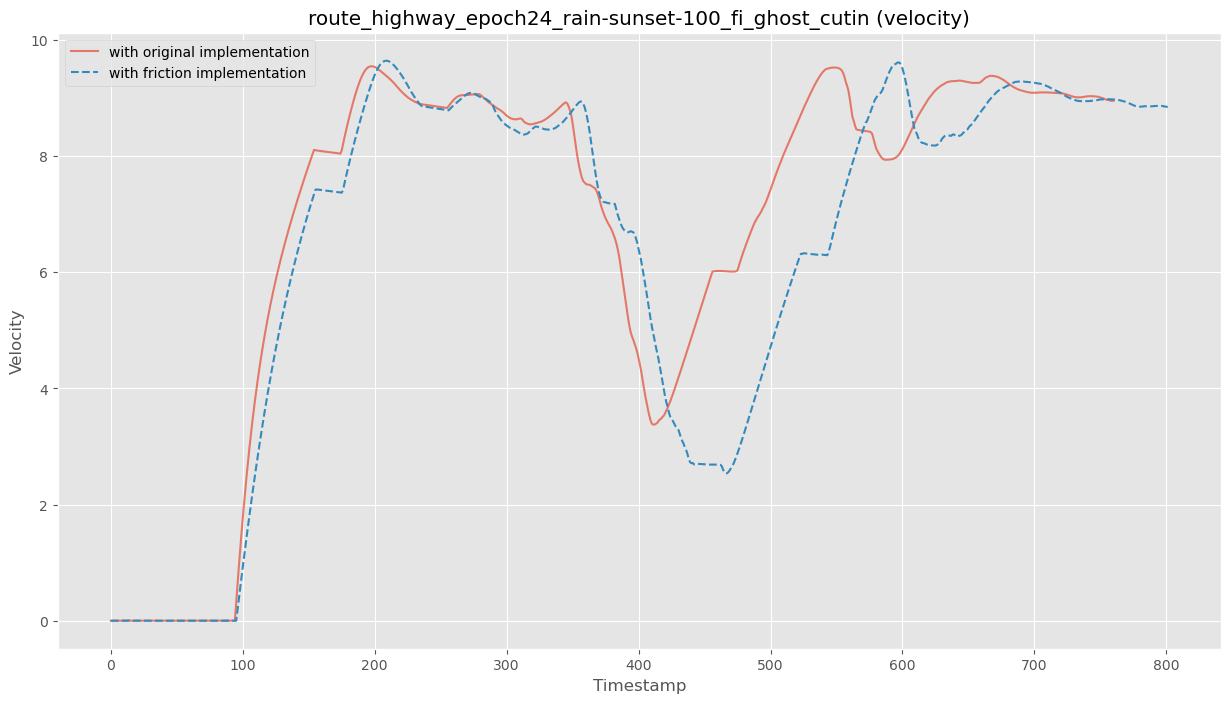

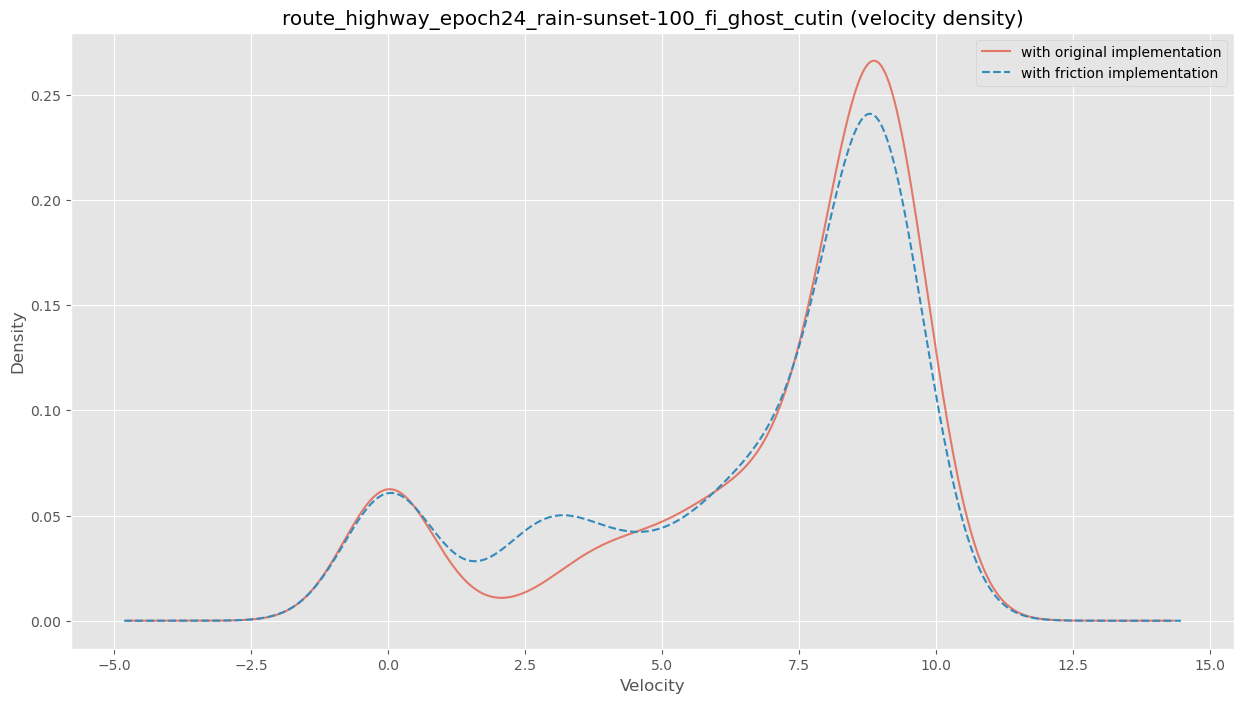

In [37]:
for weather in range(len(txt_lists_fric)):
    plt.figure(figsize=(15,8))
    df_orig_v = pd.DataFrame()

    for i in range(0, len(df_array_orig[weather])):
        if(df_array_orig[weather][i]['v'].dtypes == 'object'):
            print(i)
        else:
            if not df_array_orig[weather][i]['v'].isnull().values.any():
                df_orig_v["Run"+str(i)] = df_array_orig[weather][i]['v']

    median_orig_v = df_orig_v.median(axis=1)

    plt.plot(median_orig_v, alpha=0.7)


    df_fric_v = pd.DataFrame()

    for i in range(0, len(df_array_fric[weather])):
        if(df_array_fric[weather][i]['v'].dtypes == 'object'):
            print(i)
        else:
            if not df_array_fric[weather][i]['v'].isnull().values.any():
                df_fric_v["Run"+str(i)] = df_array_fric[weather][i]['v']

    median_fric_v = df_fric_v.median(axis=1)
    
    all_medians[weather][2][0] = median_orig_v
    all_medians[weather][2][1] = median_fric_v
    
    plt.plot(median_fric_v, '--')
    
    plt.title(subfolders[weather])
    plt.legend(friction_legend)
    plt.xlabel("Timestamp")
    plt.ylabel("Velocity")
    plt.title(subfolders[weather] + " (velocity)")
    plt.show()
    
    plt.figure(figsize=(15,8))
    plt.xlabel("Velocity")
    plt.ylabel("Density")
    median_orig_v.plot.density(alpha=0.7)
    median_fric_v.plot.density(style='--')
    plt.title(subfolders[weather] + " (velocity density)")
    plt.legend(friction_legend)
    plt.show()
    

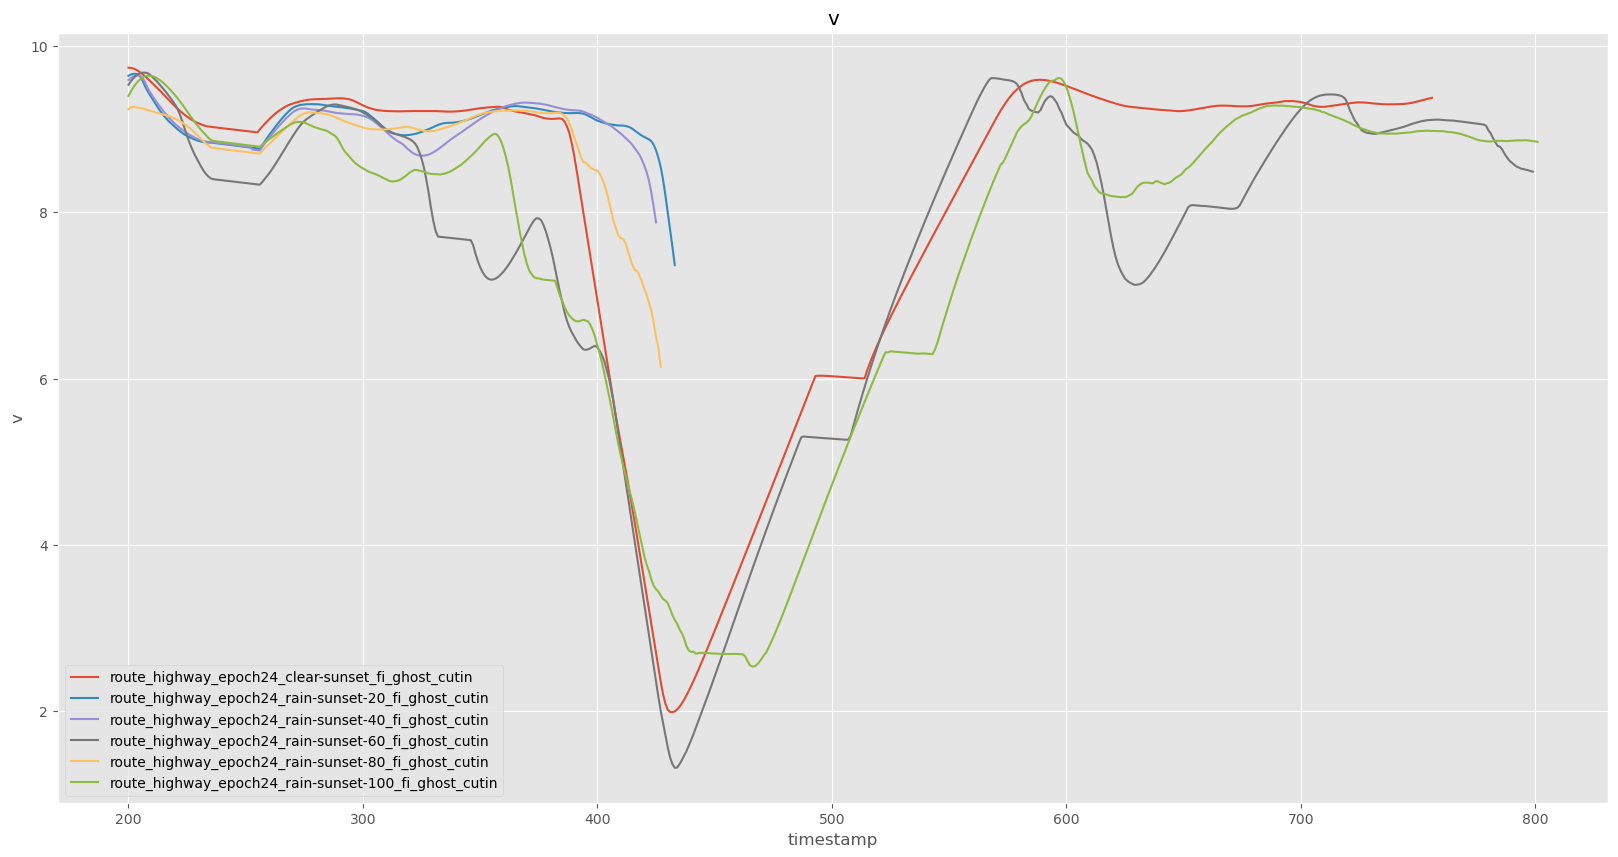

In [38]:
plt.figure(figsize=(20,10))

for weather in range(len(txt_lists_fric)):
    
#     df_orig_v = pd.DataFrame()

#     for i in range(0, len(df_array_orig[weather])):
#         if(df_array_orig[weather][i]['v'].dtypes == 'v'):
#             print(i)
#         else:
#             if not df_array_orig[weather][i]['v'].isnull().values.any():
#                 df_orig_v["Run"+str(i)] = df_array_orig[weather][i]['v']

#     median_orig_v = df_orig_v.median(axis=1)


#     plt.plot(median_orig_v[200:], alpha=0.7)


    df_fric_v = pd.DataFrame()

    for i in range(0, len(df_array_fric[weather])):
        if(df_array_fric[weather][i]['v'].dtypes == 'object'):
            print(i)
        else:
            if not df_array_fric[weather][i]['v'].isnull().values.any() :
                df_fric_v["Run"+str(i)] = df_array_fric[weather][i]['v']

    median_fric_v = df_fric_v.median(axis=1)

    plt.plot(median_fric_v[200:])

    # plt.axis('equal')
plt.xlabel("timestamp")
plt.ylabel("v")
plt.title("v")
plt.legend(full_legend)
plt.show()

### cvip

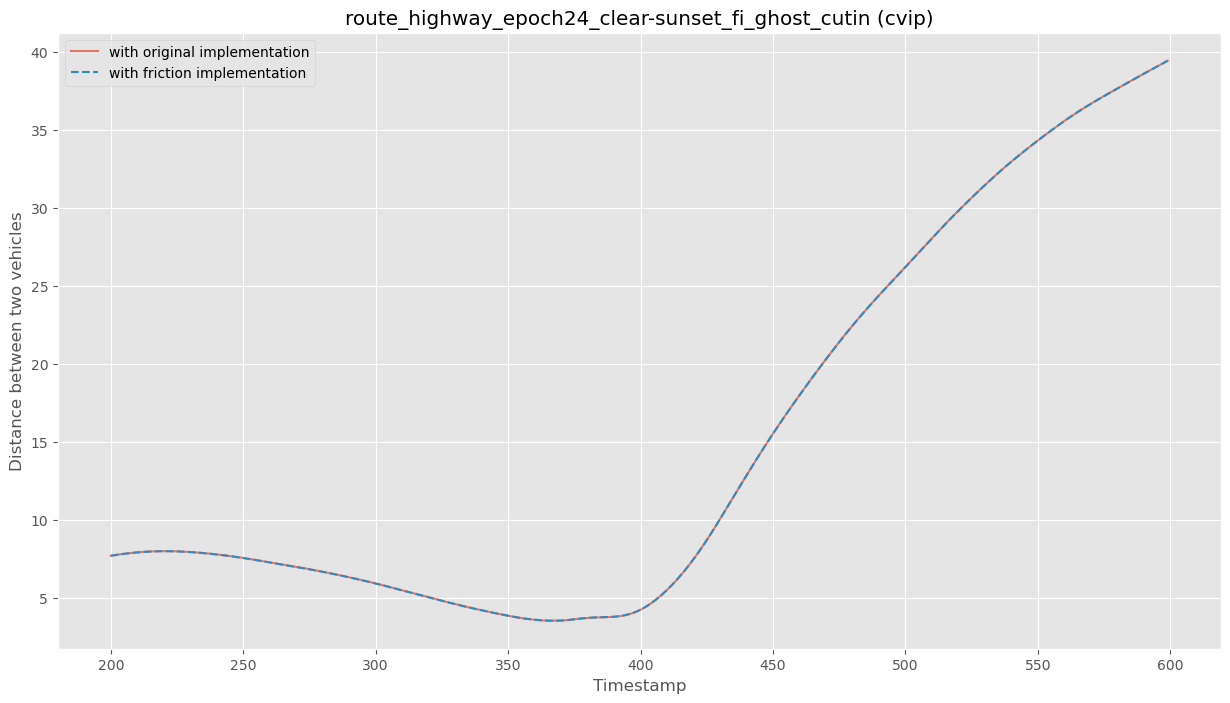

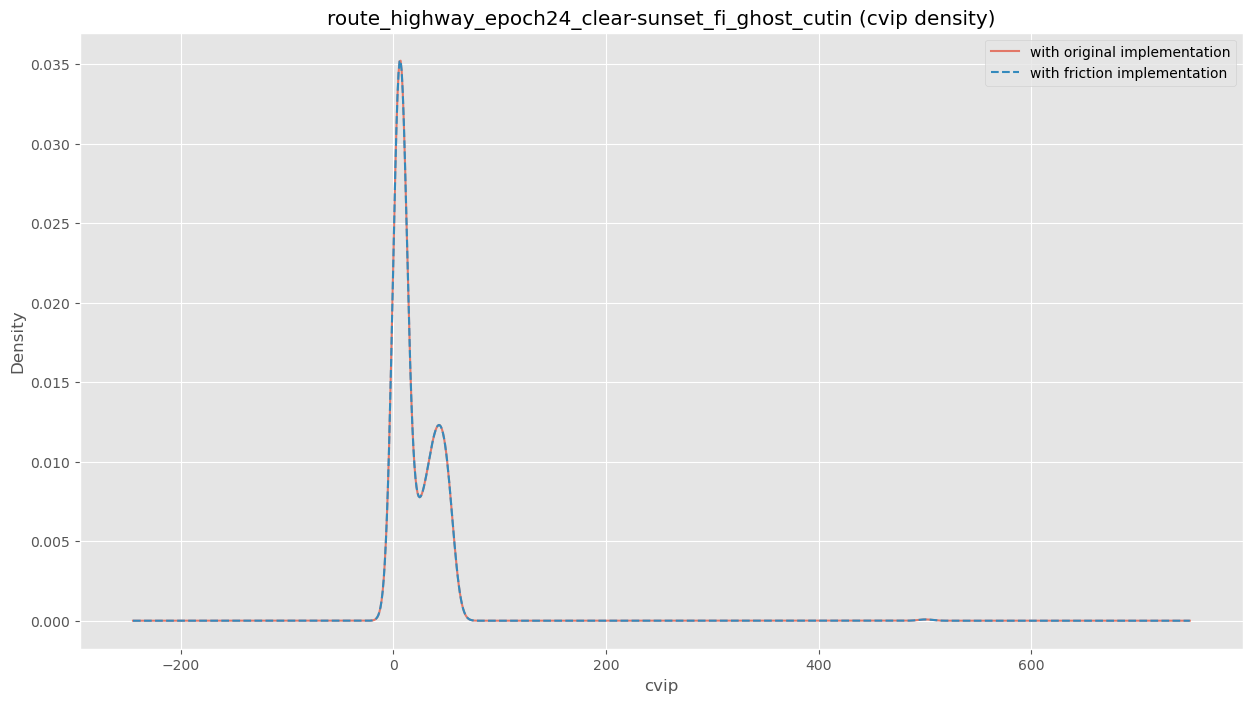

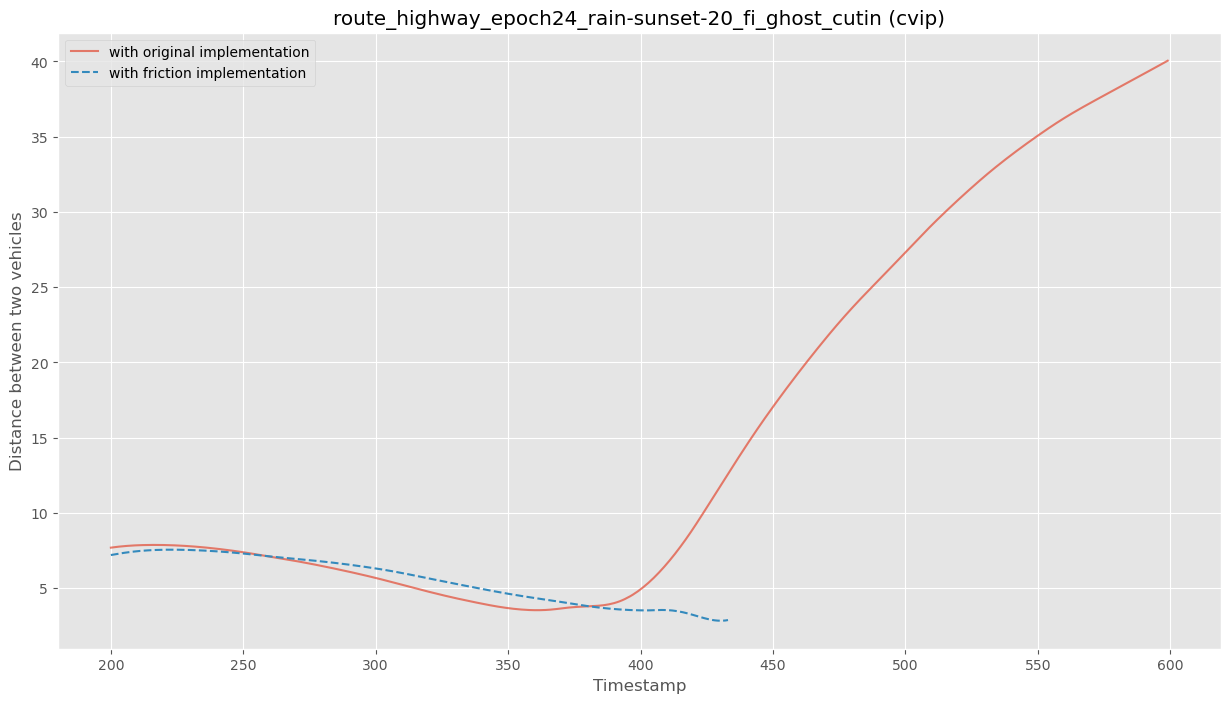

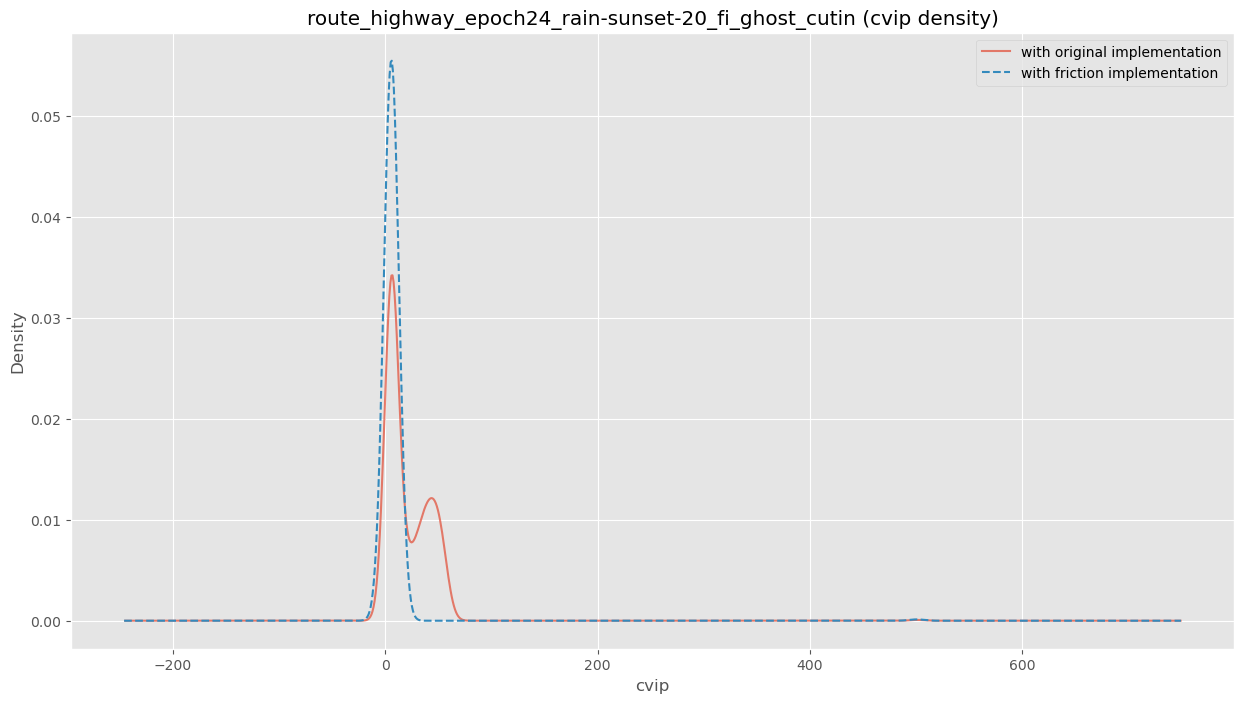

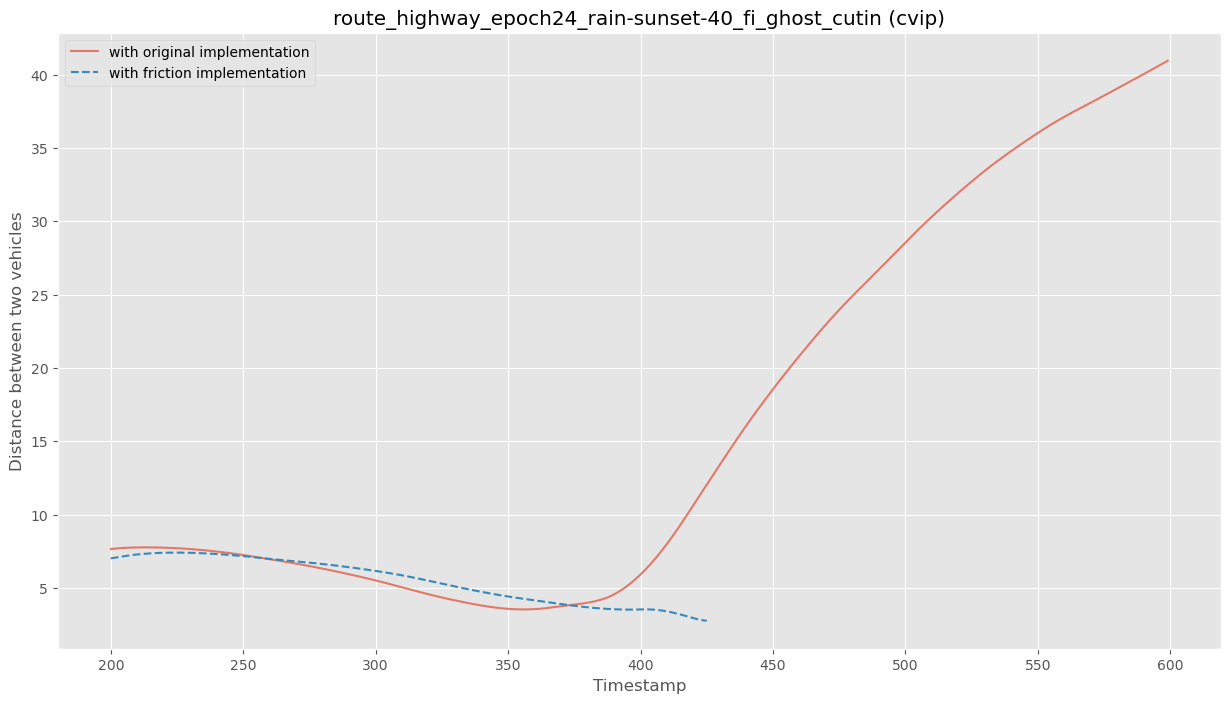

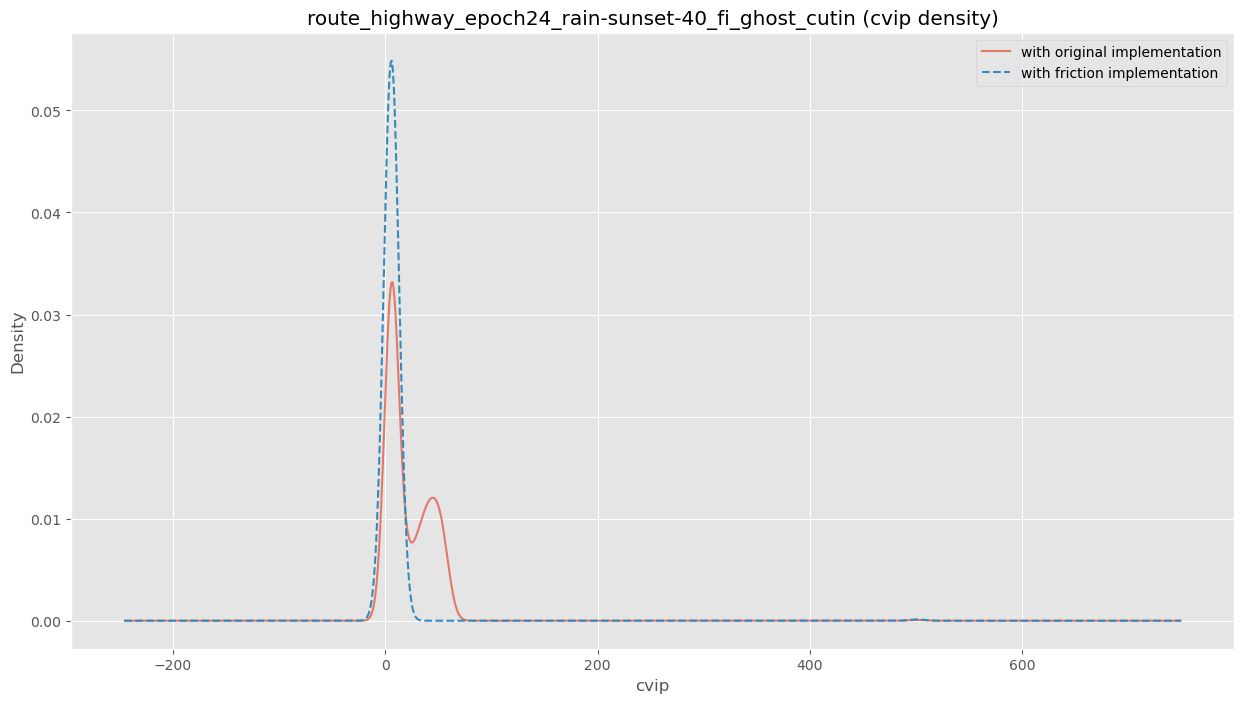

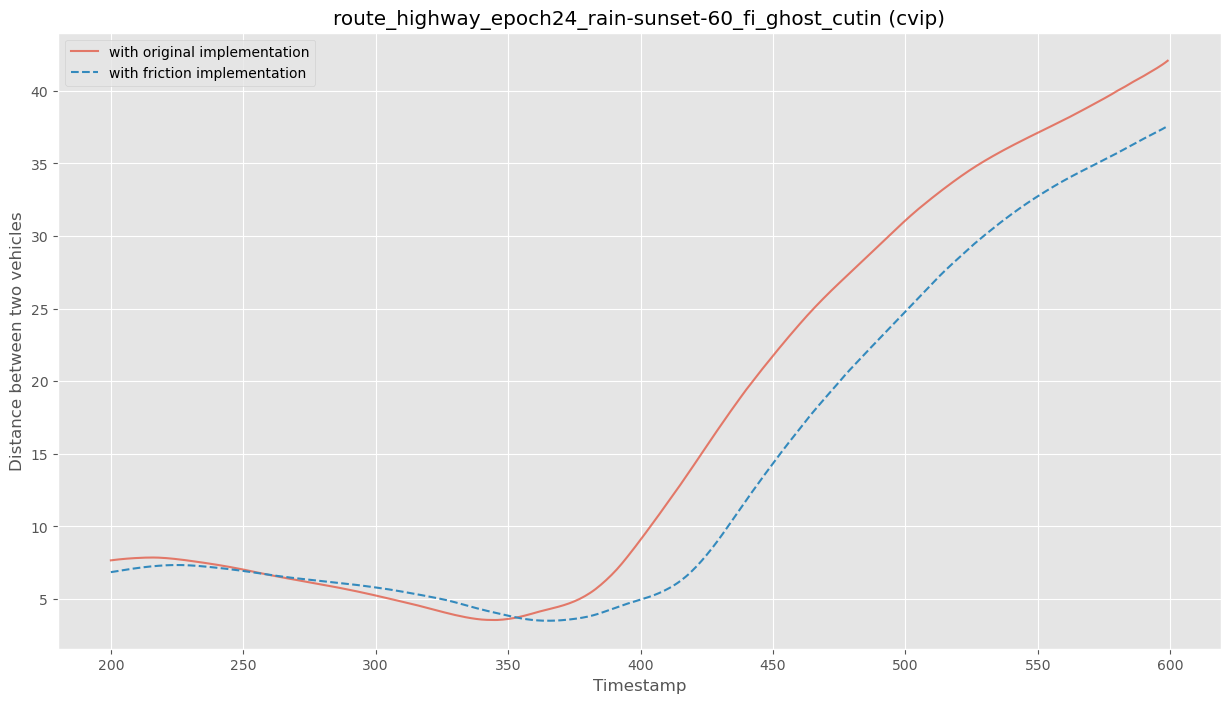

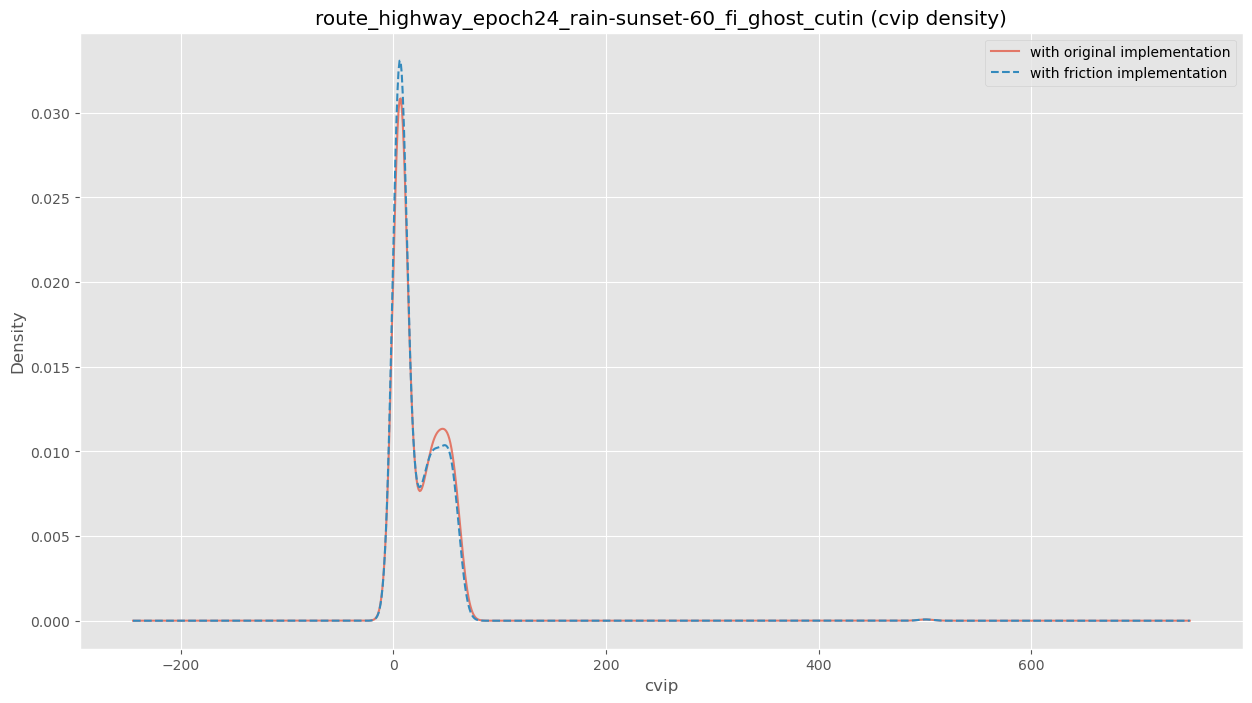

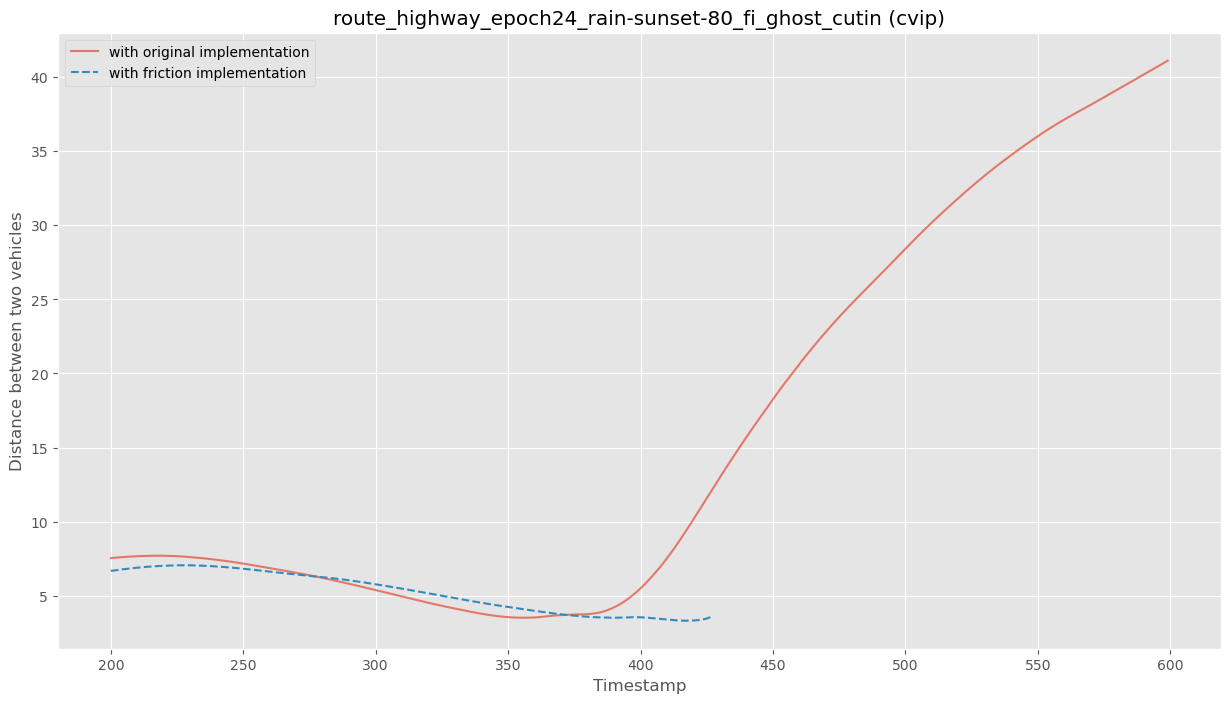

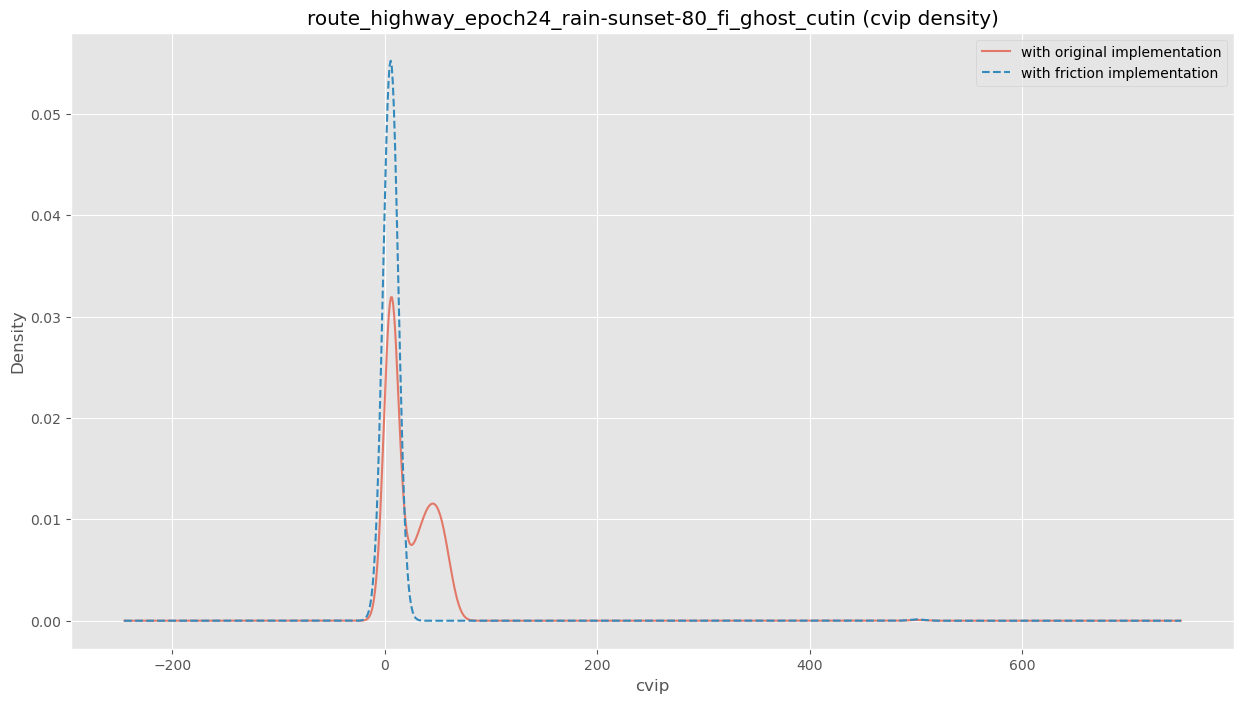

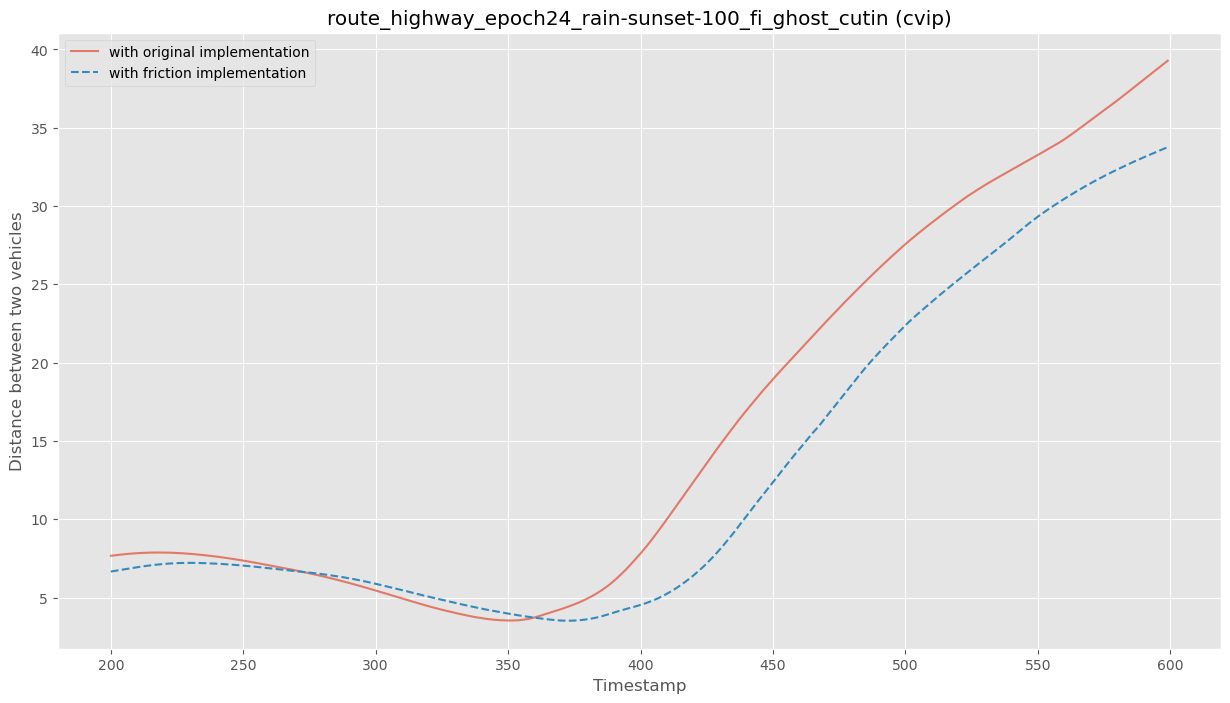

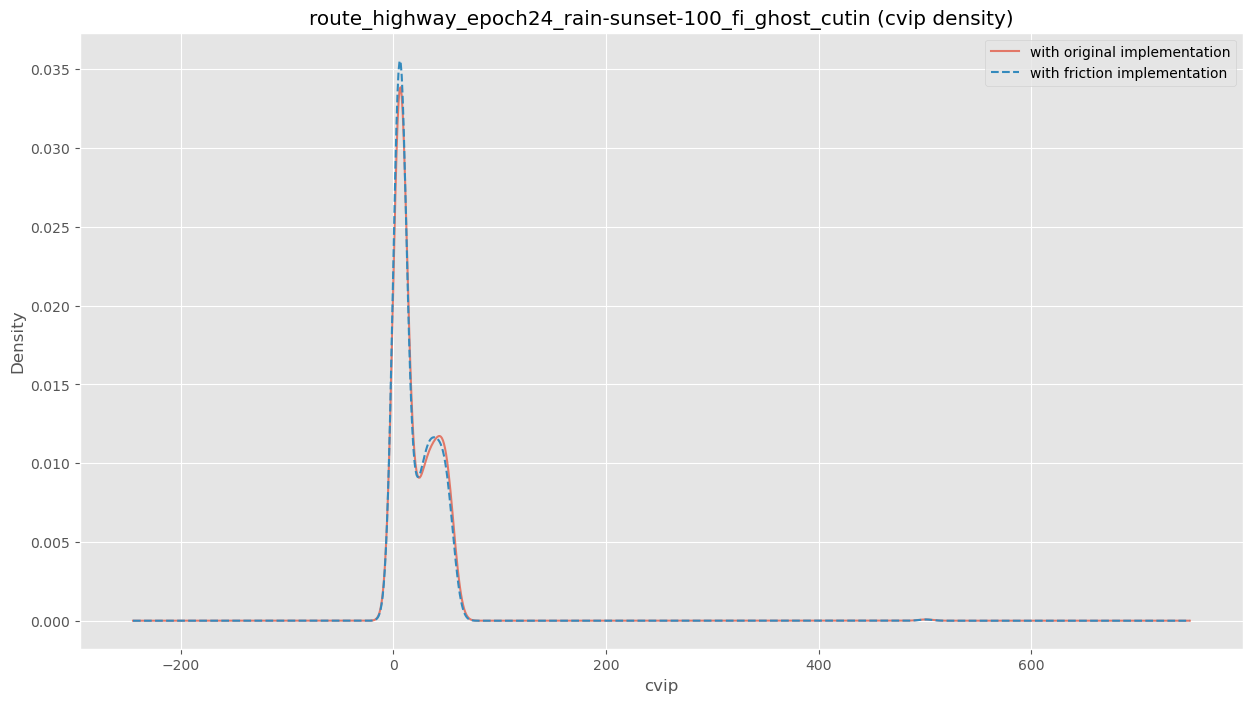

In [39]:
for weather in range(len(txt_lists_fric)):
    plt.figure(figsize=(15,8))
    df_orig_cvip = pd.DataFrame()

    for i in range(0, len(df_array_orig[weather])):
        if(df_array_orig[weather][i]['cvip'].dtypes == 'object'):
            print(i)
        else:
            if not df_array_orig[weather][i]['cvip'].isnull().values.any():
                df_orig_cvip["Run"+str(i)] = df_array_orig[weather][i]['cvip']

    median_orig_cvip = df_orig_cvip.median(axis=1)

    plt.plot(median_orig_cvip.iloc[200:600], alpha=0.7)


    df_fric_cvip = pd.DataFrame()

    for i in range(0, len(df_array_fric[weather])):
        if(df_array_fric[weather][i]['cvip'].dtypes == 'object'):
            print(i)
        else:
            if not df_array_fric[weather][i]['cvip'].isnull().values.any():
                df_fric_cvip["Run"+str(i)] = df_array_fric[weather][i]['cvip']

    median_fric_cvip = df_fric_cvip.median(axis=1)
    
    all_medians[weather][3][0] = median_orig_cvip
    all_medians[weather][3][1] = median_fric_cvip
    
    plt.plot(median_fric_cvip.iloc[200:600], '--')
    
    plt.title(subfolders[weather])
    plt.legend(friction_legend)
    plt.xlabel("Timestamp")
    plt.ylabel("Distance between two vehicles")
    plt.title(subfolders[weather] + " (cvip)")
    plt.show()
    
    plt.figure(figsize=(15,8))
    plt.xlabel("cvip")
    plt.ylabel("Density")
    median_orig_cvip.plot.density(alpha=0.7)
    median_fric_cvip.plot.density(style='--')
    plt.title(subfolders[weather] + " (cvip density)")
    plt.legend(friction_legend)
    plt.show()

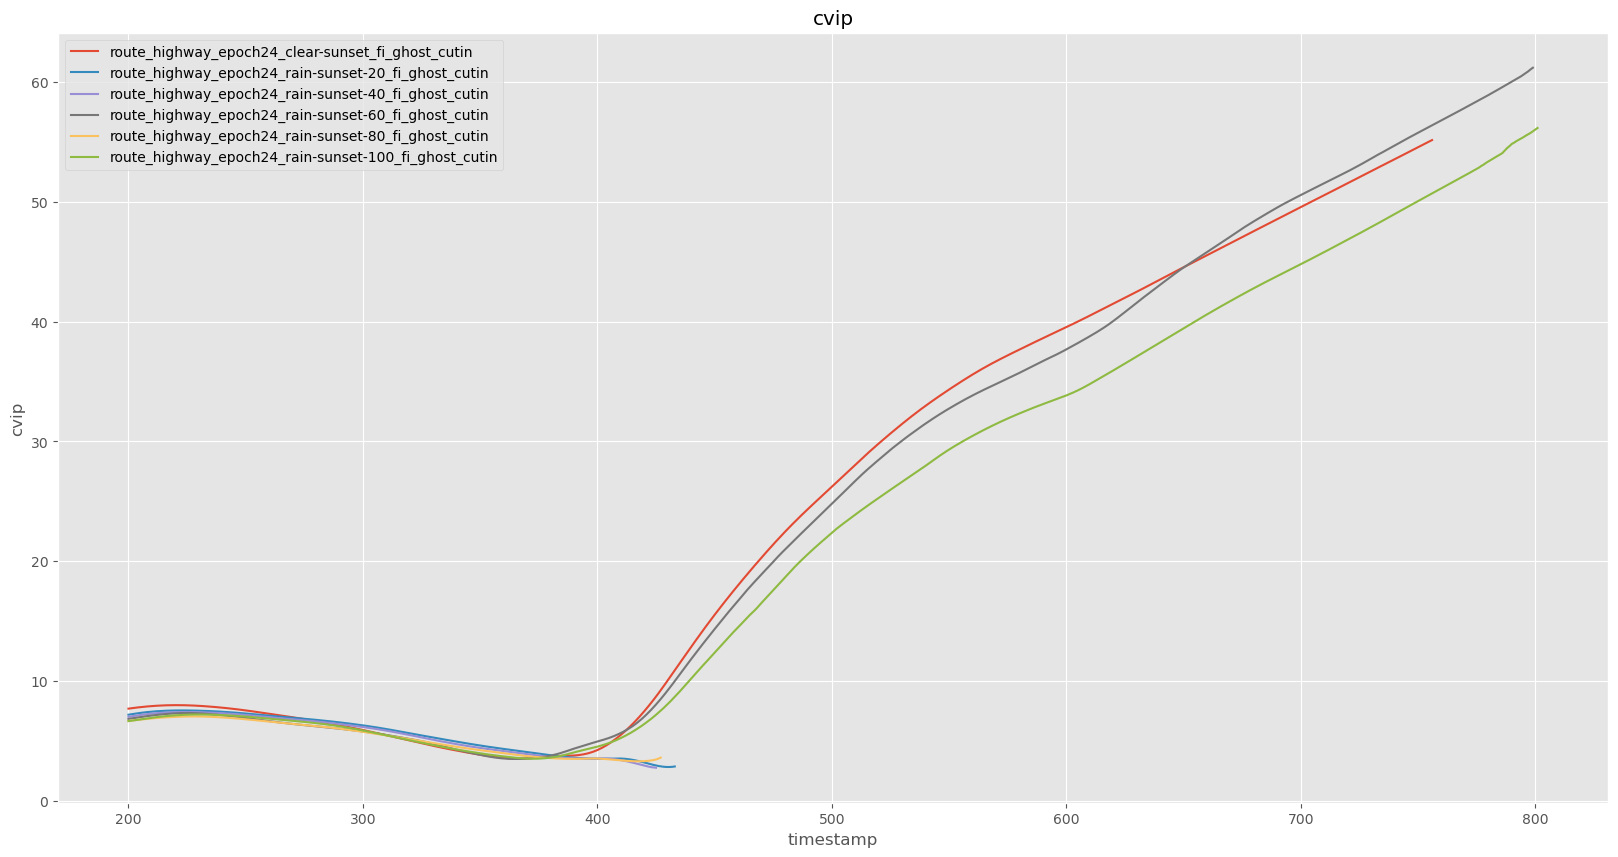

In [40]:
plt.figure(figsize=(20,10))

for weather in range(len(txt_lists_fric)):
    
#     df_orig_cvip = pd.DataFrame()

#     for i in range(0, len(df_array_orig[weather])):
#         if(df_array_orig[weather][i]['cvip'].dtypes == 'object'):
#             print(i)
#         else:
#             if not df_array_orig[weather][i]['cvip'].isnull().values.any():
#                 df_orig_cvip["Run"+str(i)] = df_array_orig[weather][i]['cvip']

#     median_orig_cvip = df_orig_cvip.median(axis=1)


#     plt.plot(median_orig_cvip[200:], alpha=0.7)


    df_fric_cvip = pd.DataFrame()

    for i in range(0, len(df_array_fric[weather])):
        if(df_array_fric[weather][i]['cvip'].dtypes == 'object'):
            print(i)
        else:
            if not df_array_fric[weather][i]['cvip'].isnull().values.any() :
                df_fric_cvip["Run"+str(i)] = df_array_fric[weather][i]['cvip']

    median_fric_cvip = df_fric_cvip.median(axis=1)

    plt.plot(median_fric_cvip[200:])

    # plt.axis('equal')
plt.xlabel("timestamp")
plt.ylabel("cvip")
plt.title("cvip")
plt.legend(full_legend)
plt.show()

### steer

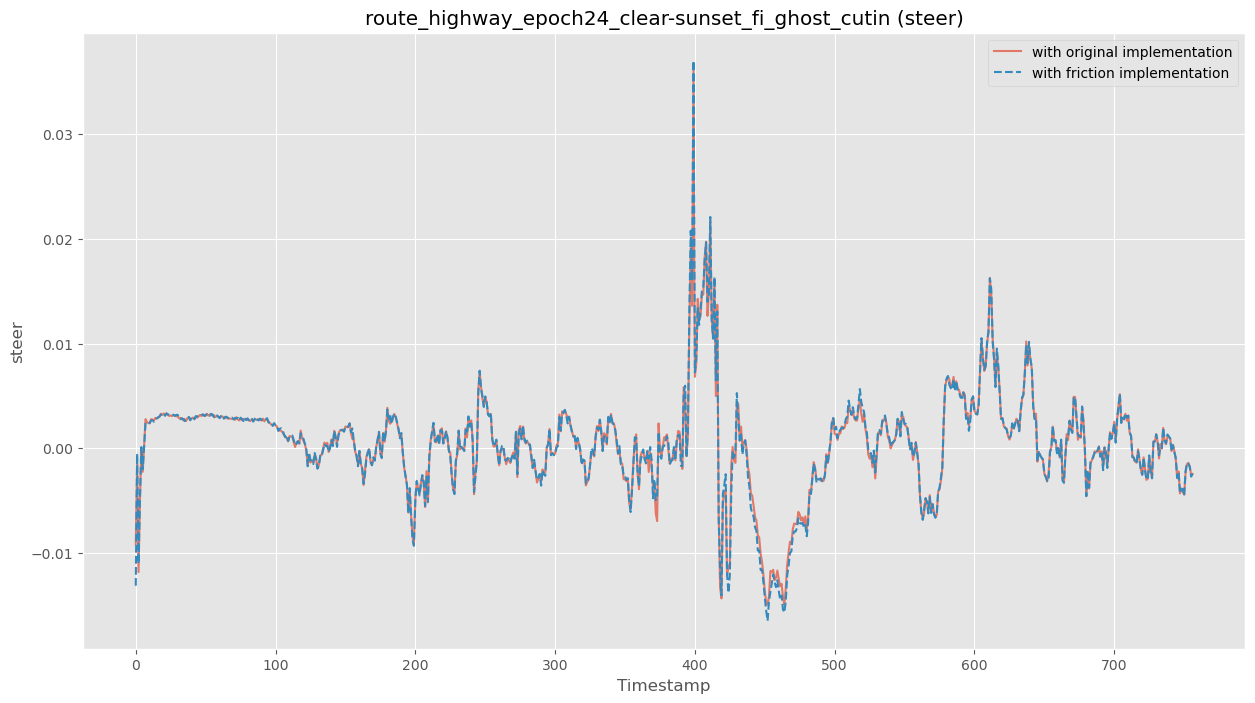

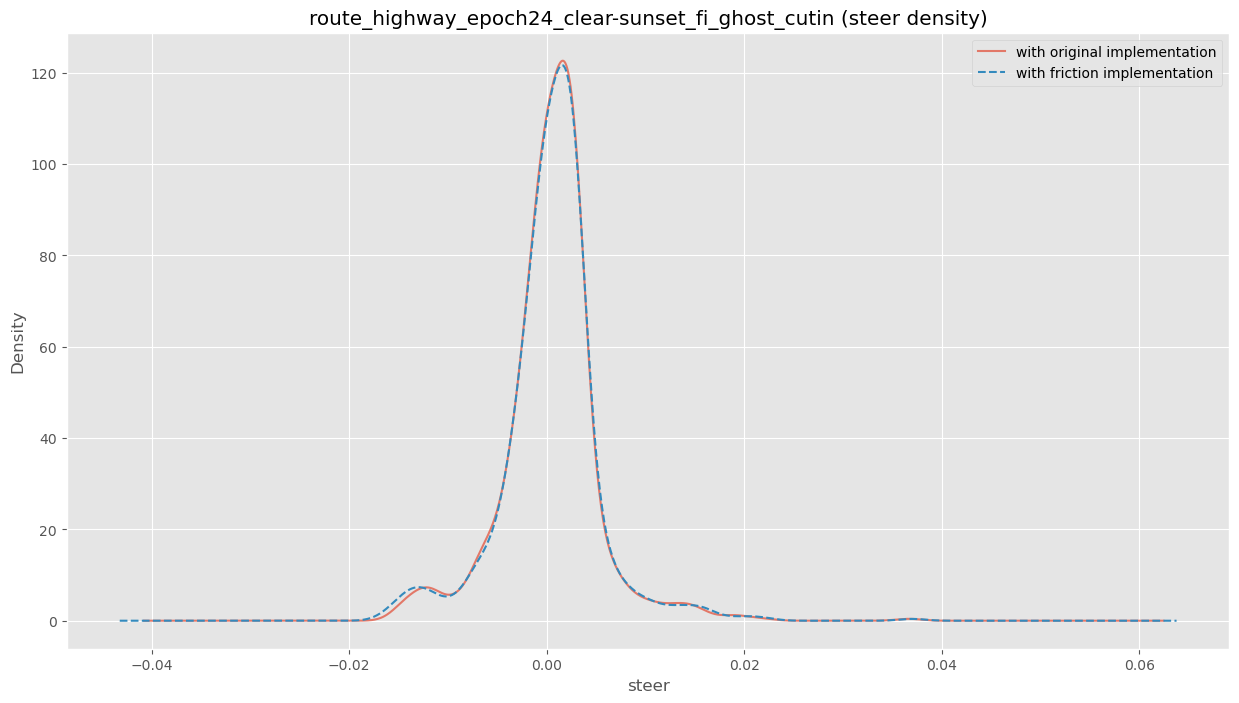

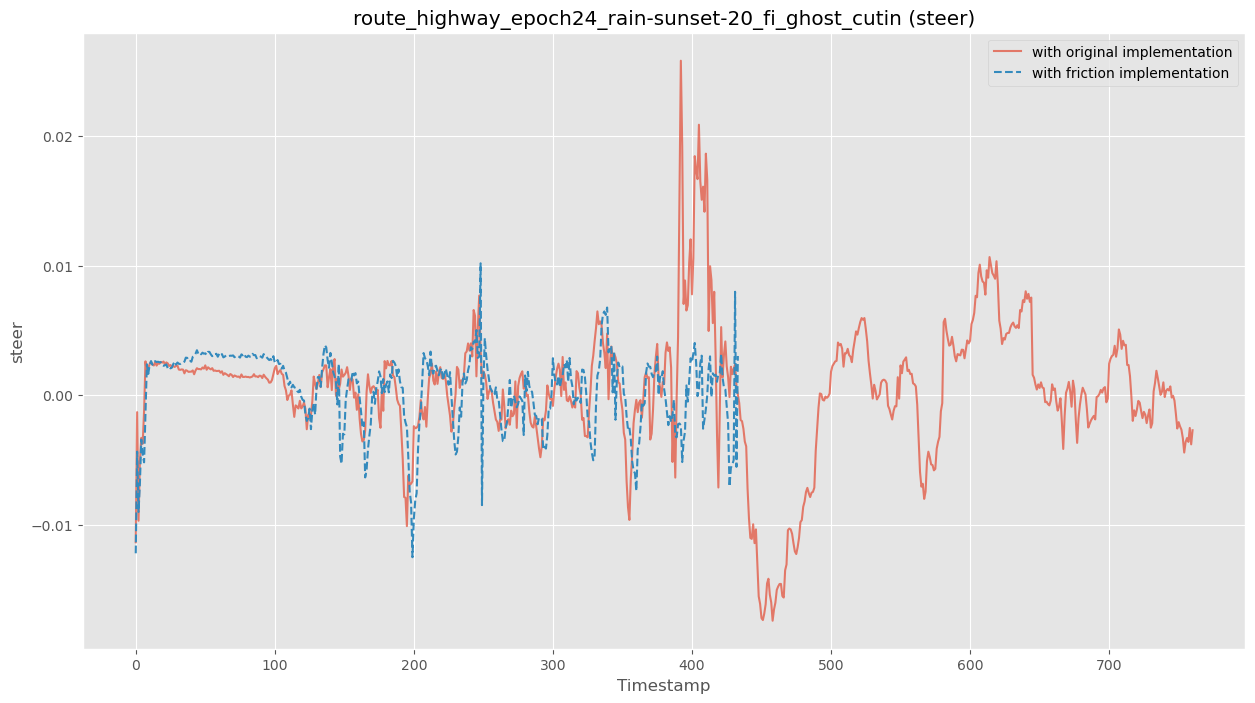

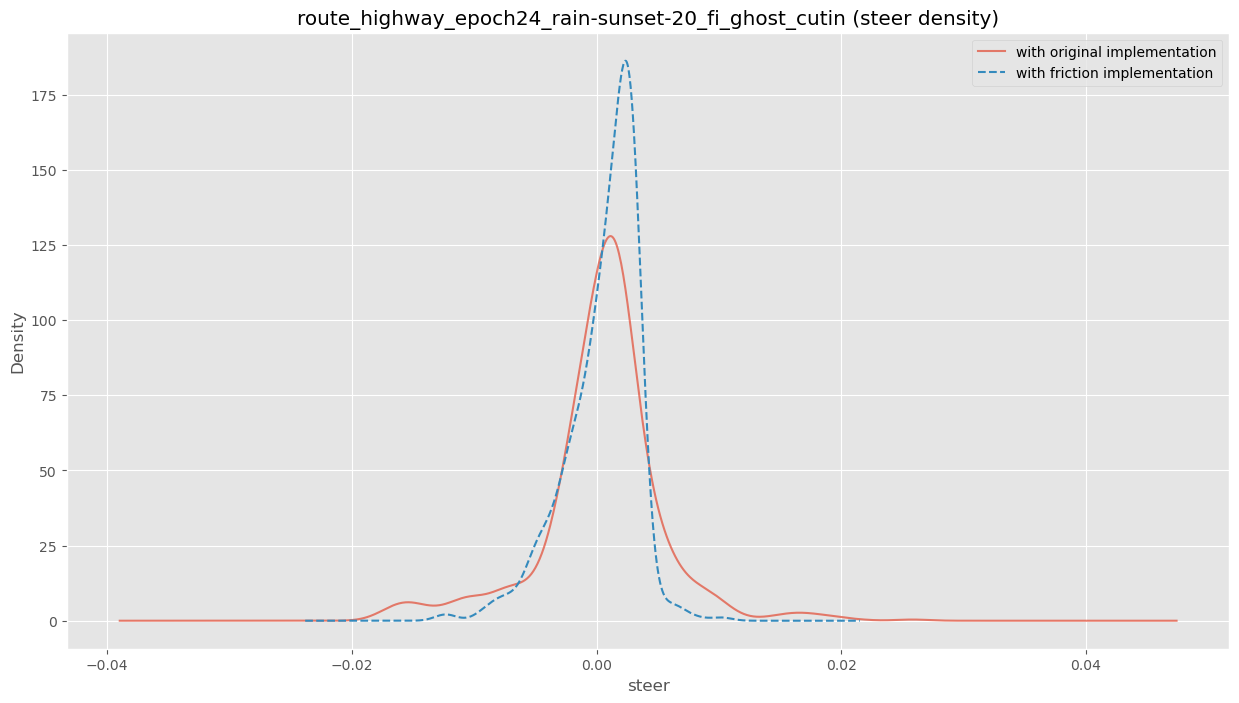

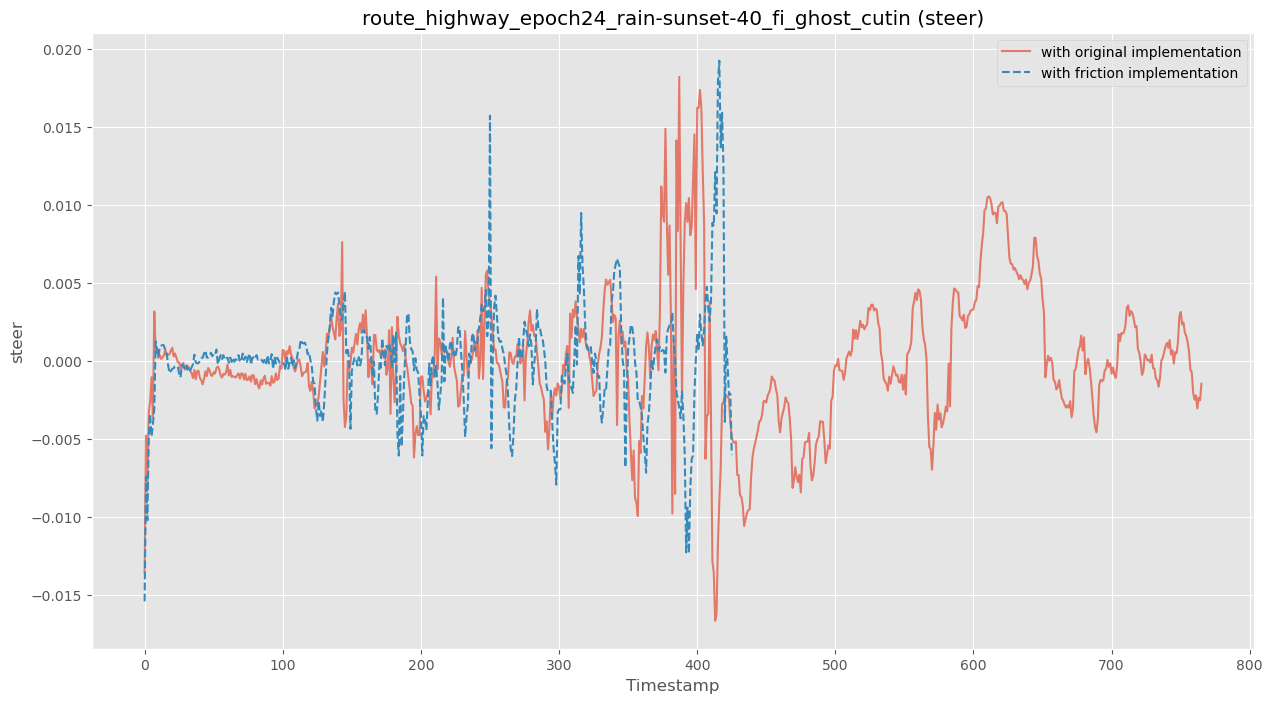

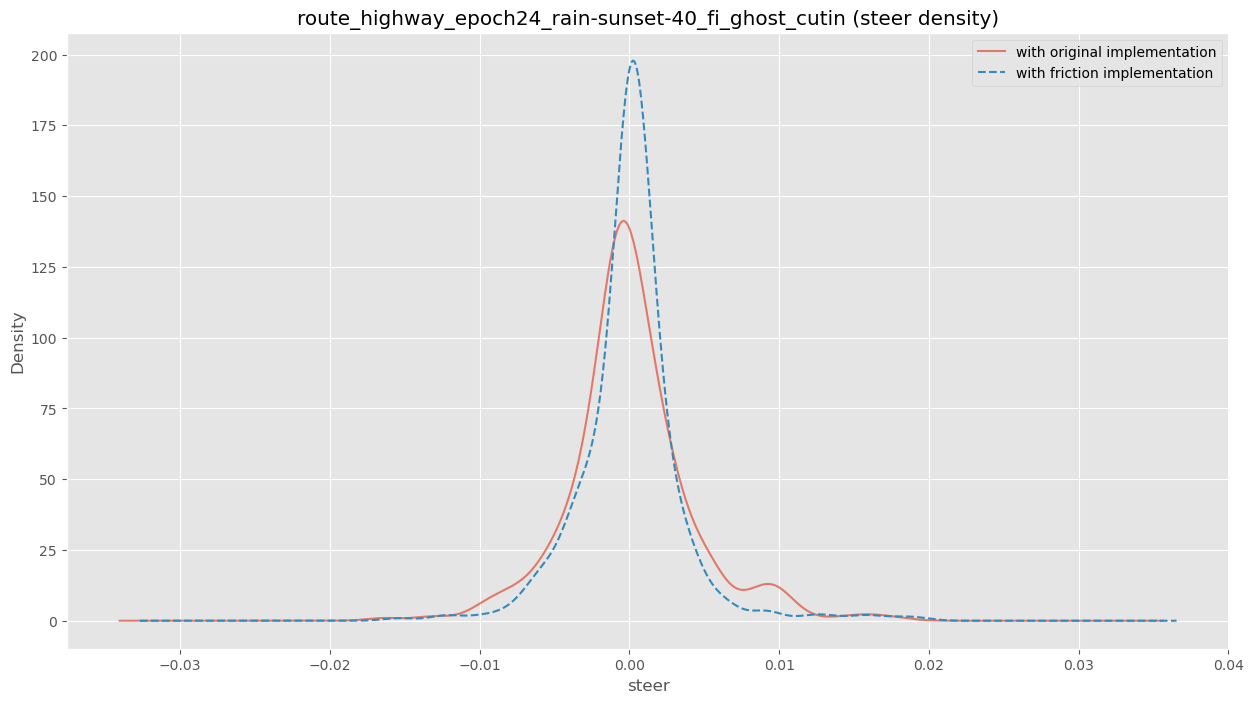

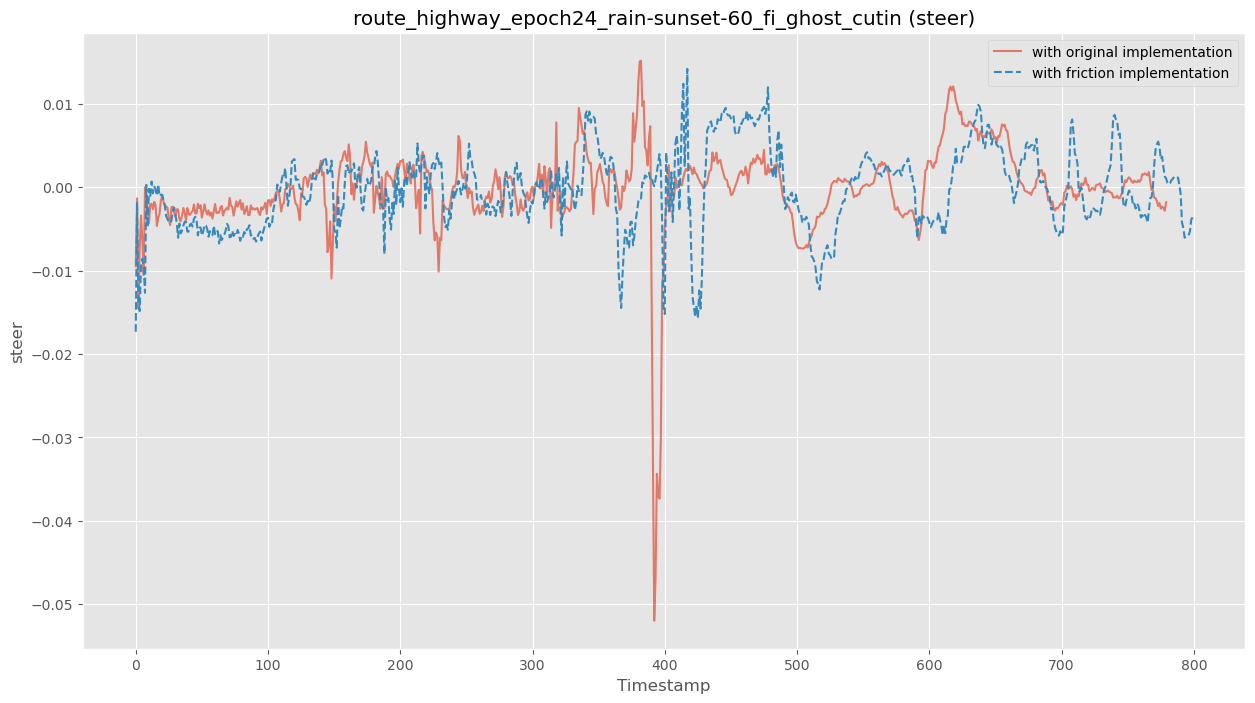

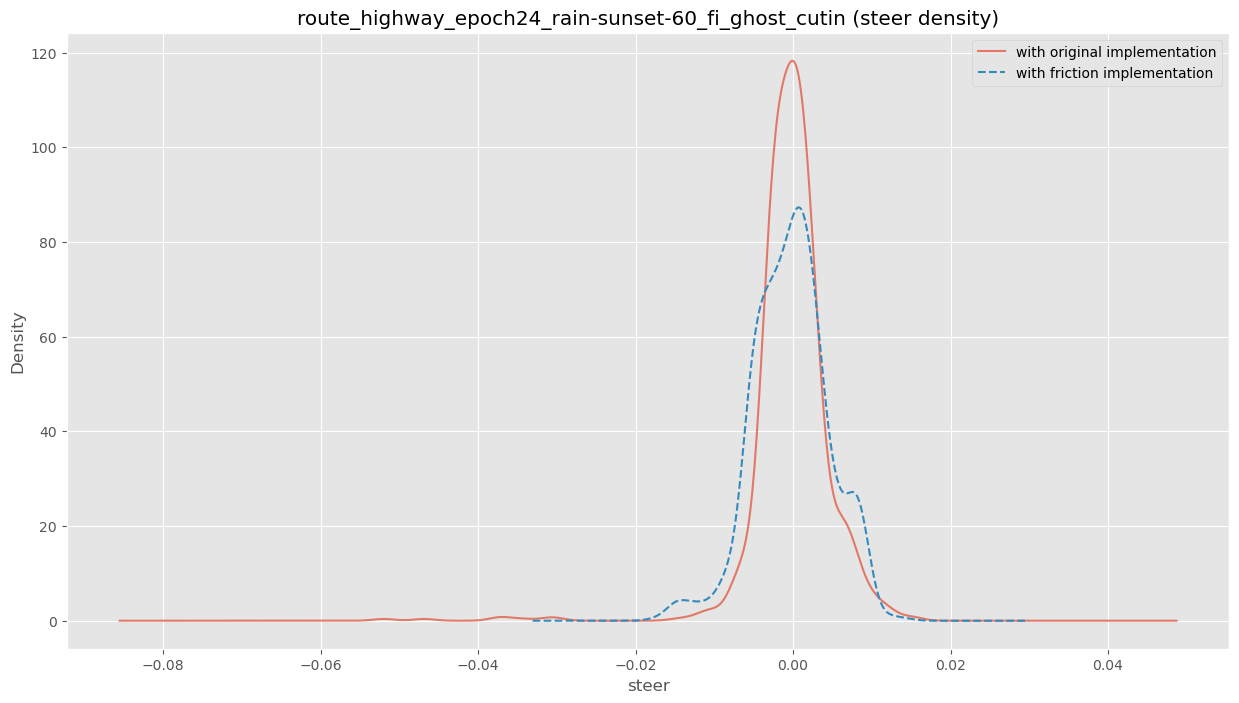

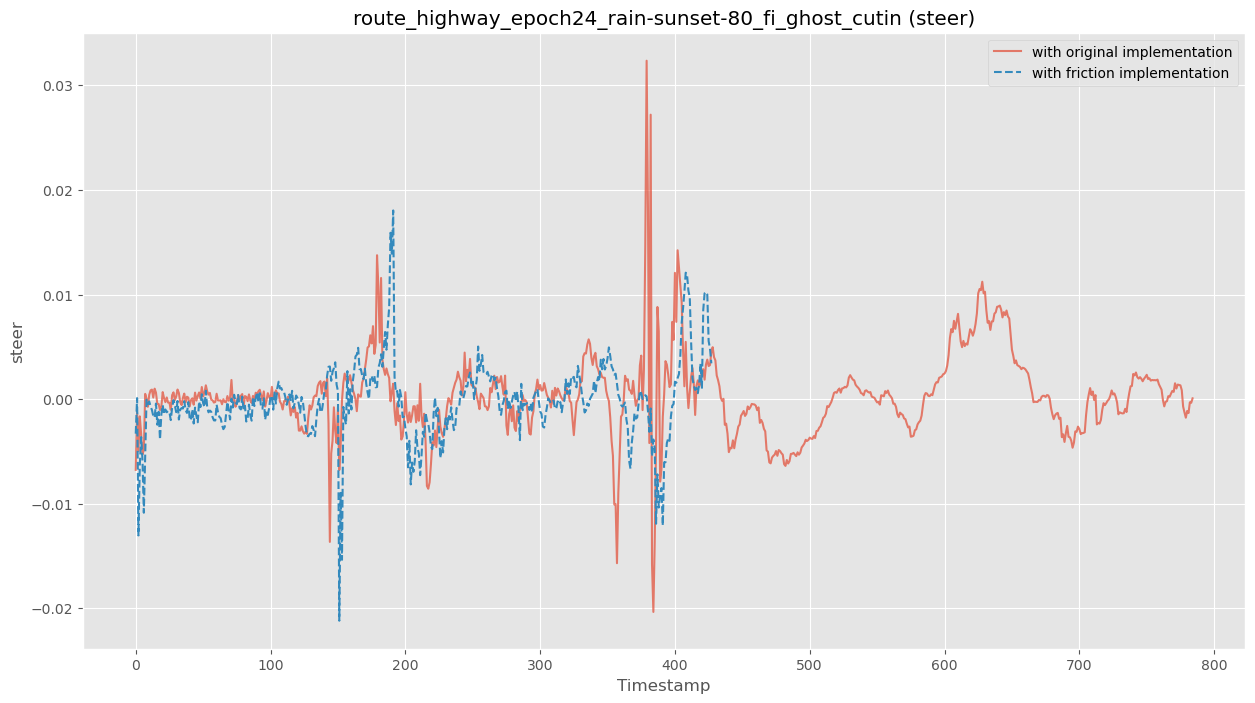

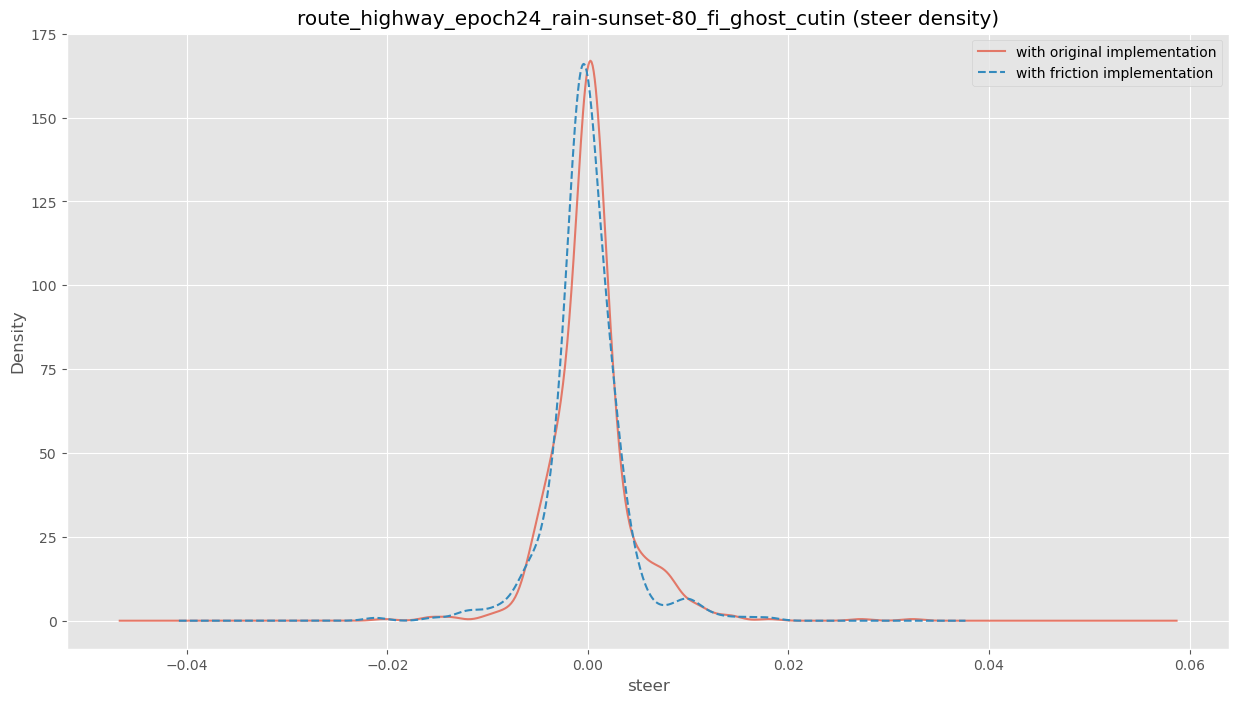

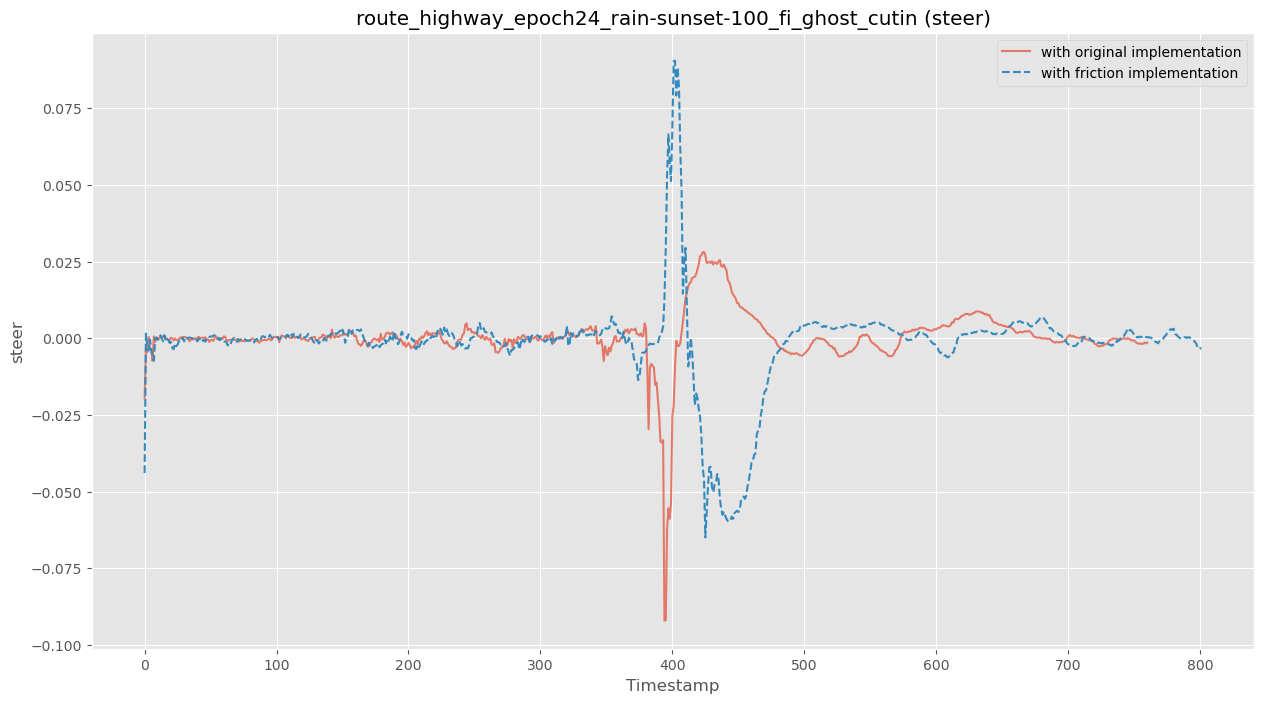

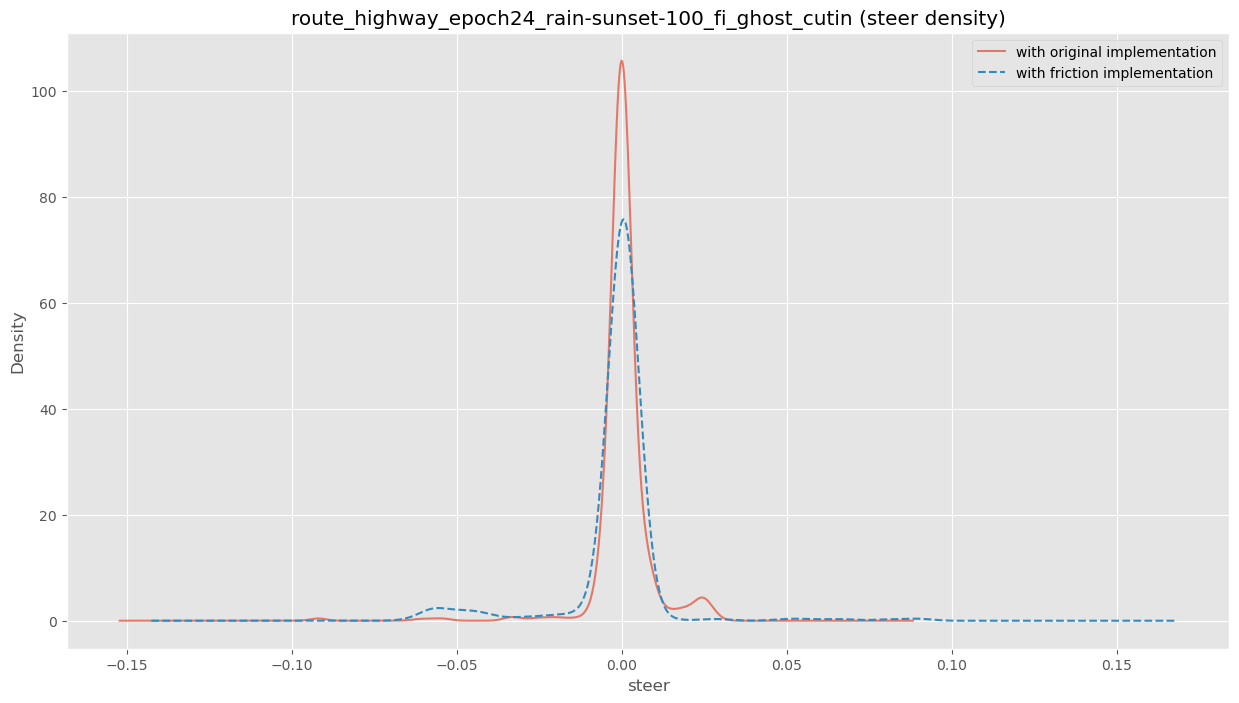

In [41]:
for weather in range(len(txt_lists_fric)):
    plt.figure(figsize=(15,8))
    df_orig_steer = pd.DataFrame()

    for i in range(0, len(df_array_orig[weather])):
        if(df_array_orig[weather][i]['steer'].dtypes == 'object'):
            print(i)
        else:
            if not df_array_orig[weather][i]['steer'].isnull().values.any():
                df_orig_steer["Run"+str(i)] = df_array_orig[weather][i]['steer']

    median_orig_steer = df_orig_steer.median(axis=1)

    plt.plot(median_orig_steer, alpha=0.7)


    df_fric_steer = pd.DataFrame()

    for i in range(0, len(df_array_fric[weather])):
        if(df_array_fric[weather][i]['steer'].dtypes == 'object'):
            print(i)
        else:
            if not df_array_fric[weather][i]['steer'].isnull().values.any():
                df_fric_steer["Run"+str(i)] = df_array_fric[weather][i]['steer']

    median_fric_steer = df_fric_steer.median(axis=1)
    
    all_medians[weather][4][0] = median_orig_steer
    all_medians[weather][4][1] = median_fric_steer
    
    plt.plot(median_fric_steer, '--')
    
    plt.title(subfolders[weather])
    plt.legend(friction_legend)
    plt.xlabel("Timestamp")
    plt.ylabel("steer")
    plt.title(subfolders[weather] + " (steer)")
    plt.show()
    
    plt.figure(figsize=(15,8))
    plt.xlabel("steer")
    plt.ylabel("Density")
    median_orig_steer.plot.density(alpha=0.7)
    median_fric_steer.plot.density(style='--')
    plt.title(subfolders[weather] + " (steer density)")
    plt.legend(friction_legend)
    plt.show()
    

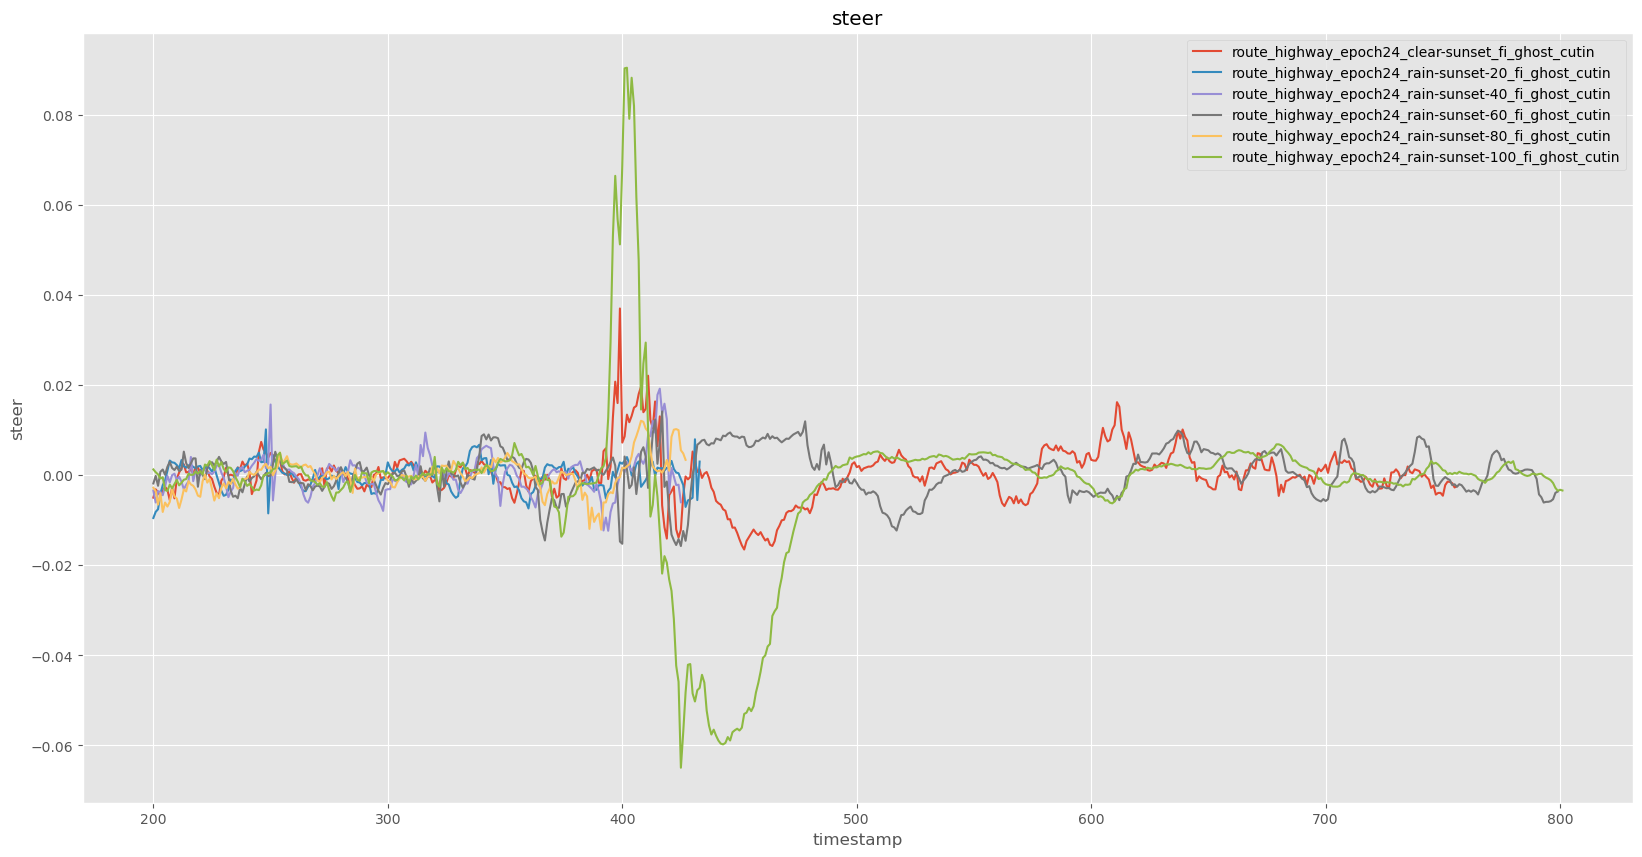

In [42]:
plt.figure(figsize=(20,10))

for weather in range(len(txt_lists_fric)):
    
#     df_orig_steer = pd.DataFrame()

#     for i in range(0, len(df_array_orig[weather])):
#         if(df_array_orig[weather][i]['steer'].dtypes == 'steer'):
#             print(i)
#         else:
#             if not df_array_orig[weather][i]['steer'].isnull().values.any():
#                 df_orig_steer["Run"+str(i)] = df_array_orig[weather][i]['steer']

#     median_orig_steer = df_orig_steer.median(axis=1)


#     plt.plot(median_orig_steer[200:], alpha=0.7)


    df_fric_steer = pd.DataFrame()

    for i in range(0, len(df_array_fric[weather])):
        if(df_array_fric[weather][i]['steer'].dtypes == 'object'):
            print(i)
        else:
            if not df_array_fric[weather][i]['steer'].isnull().values.any() :
                df_fric_steer["Run"+str(i)] = df_array_fric[weather][i]['steer']

    median_fric_steer = df_fric_steer.median(axis=1)

    plt.plot(median_fric_steer[200:])

    # plt.axis('equal')
plt.xlabel("timestamp")
plt.ylabel("steer")
plt.title("steer")
plt.legend(full_legend)
plt.show()

### brake

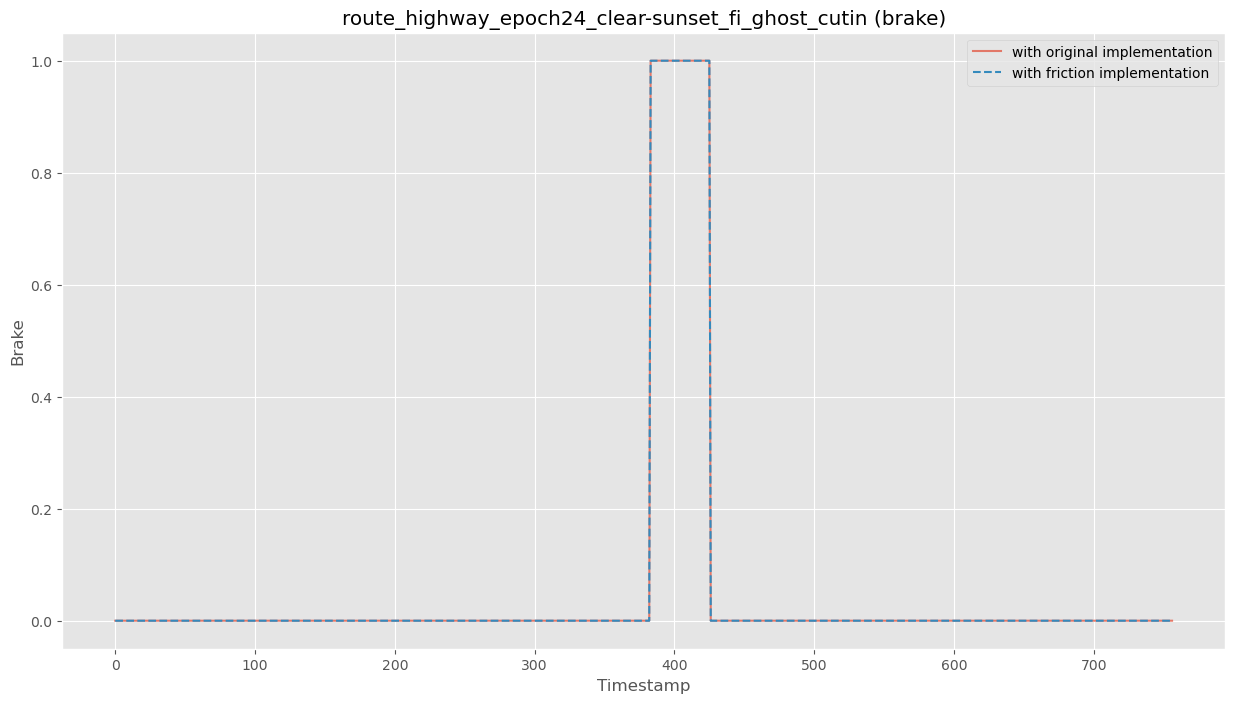

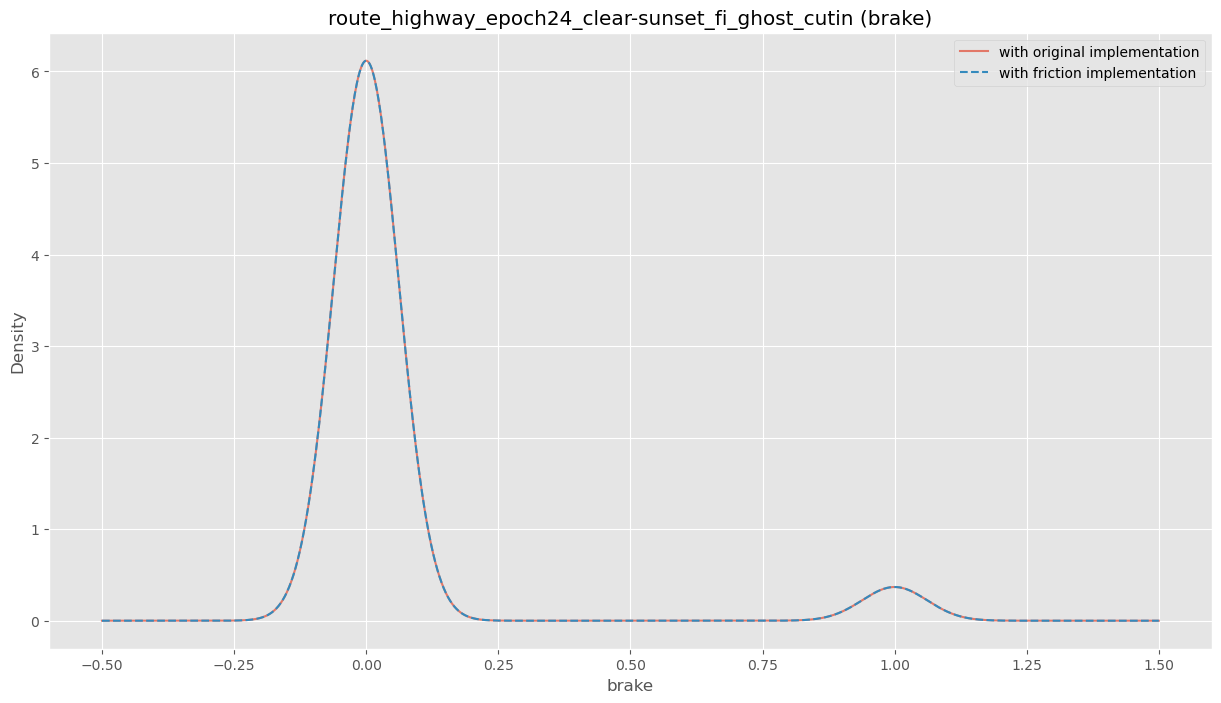

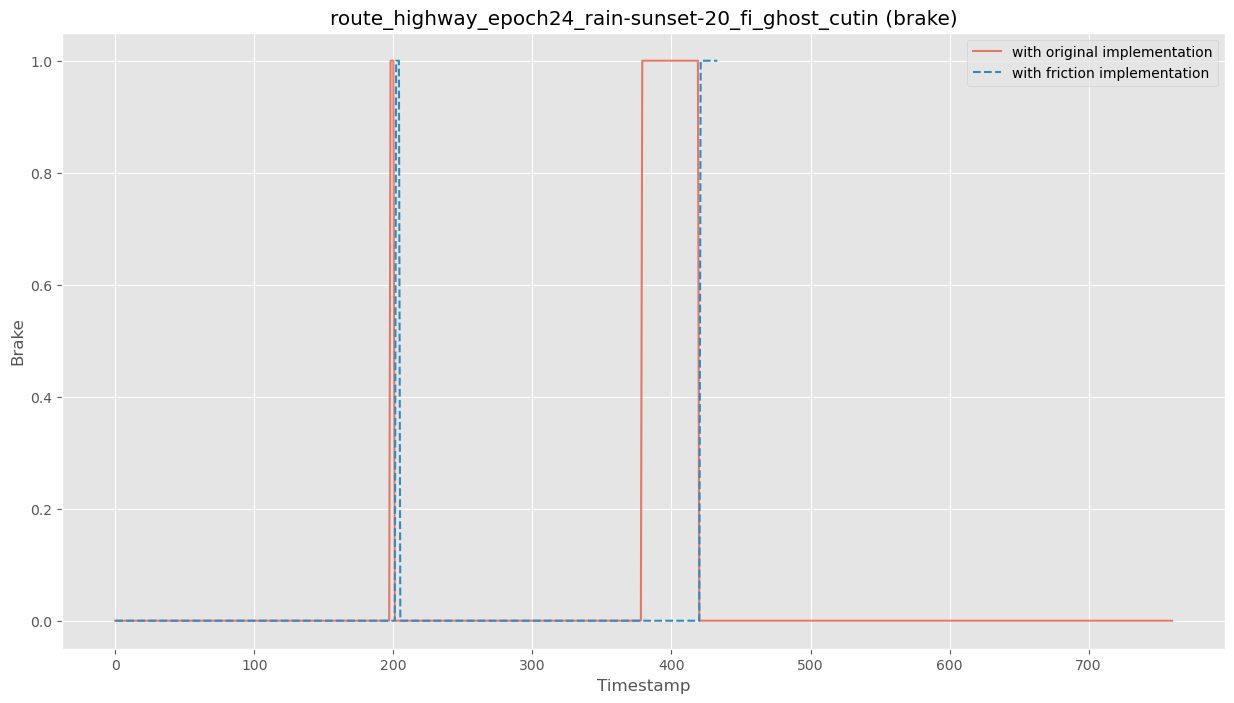

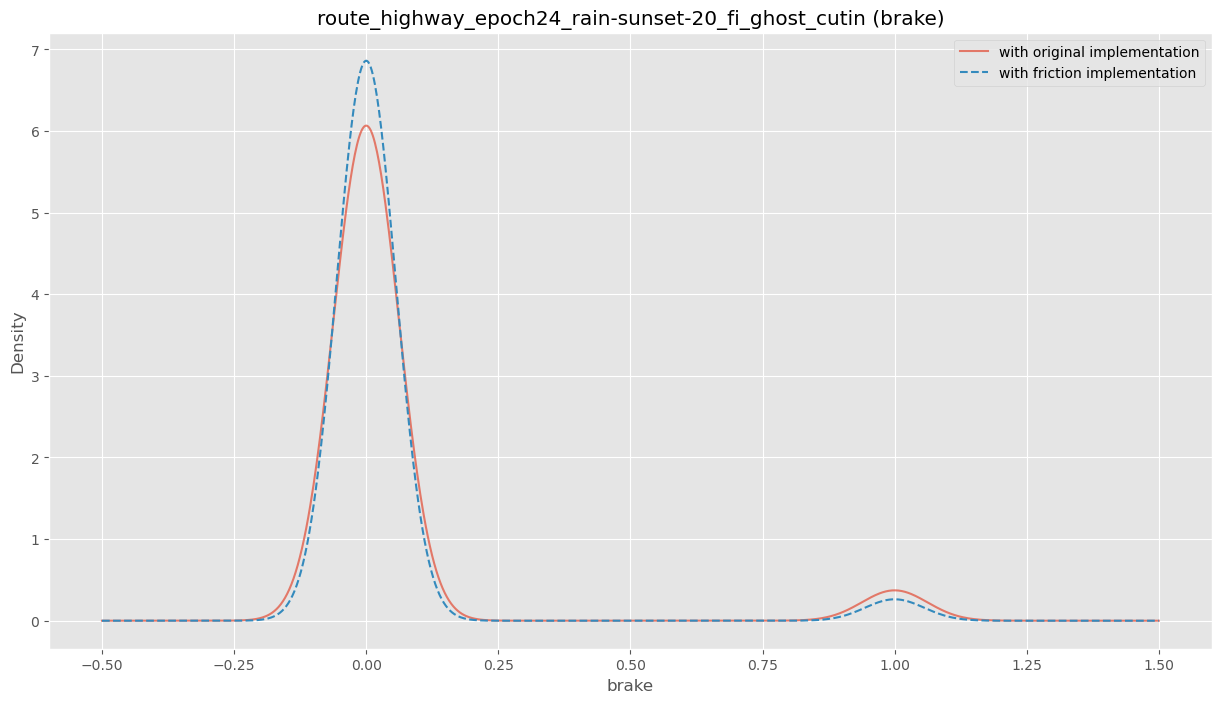

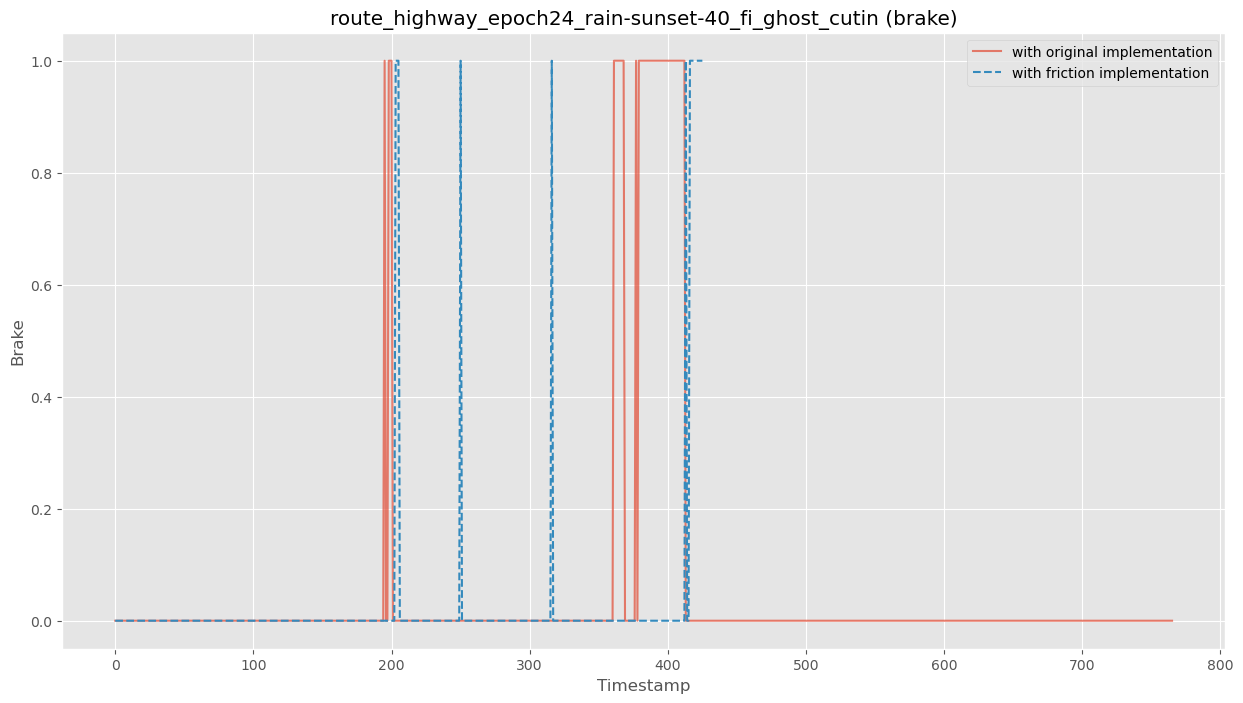

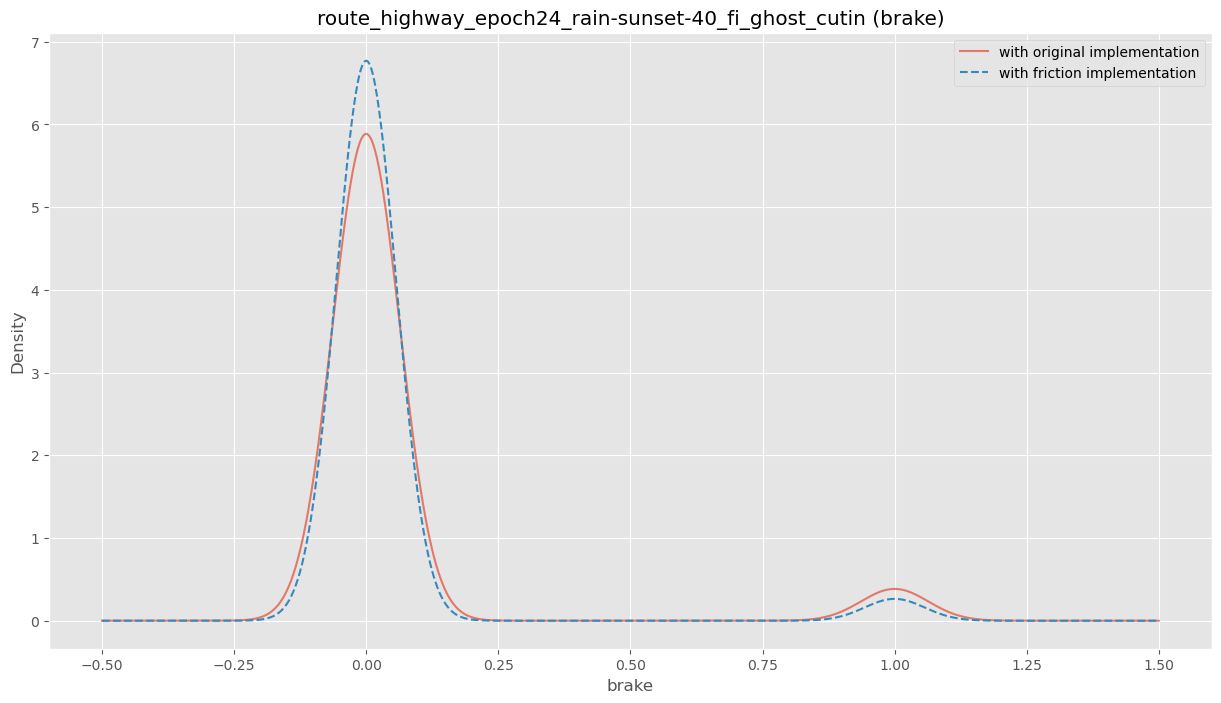

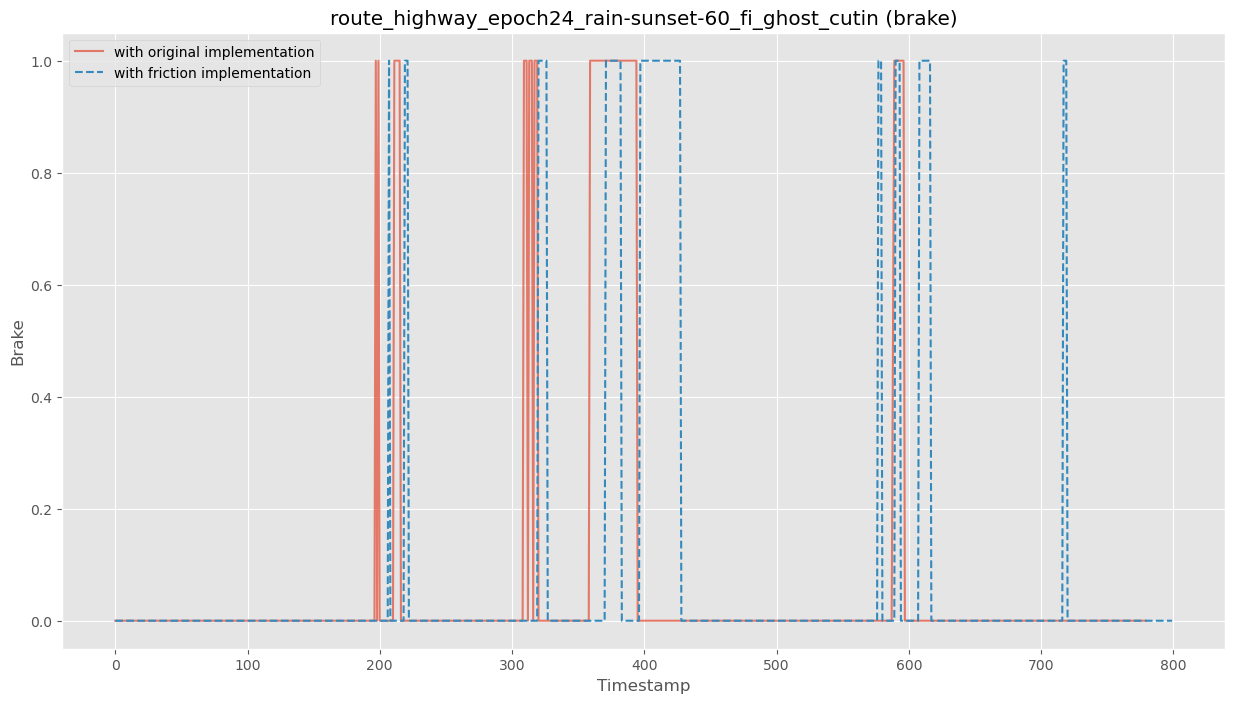

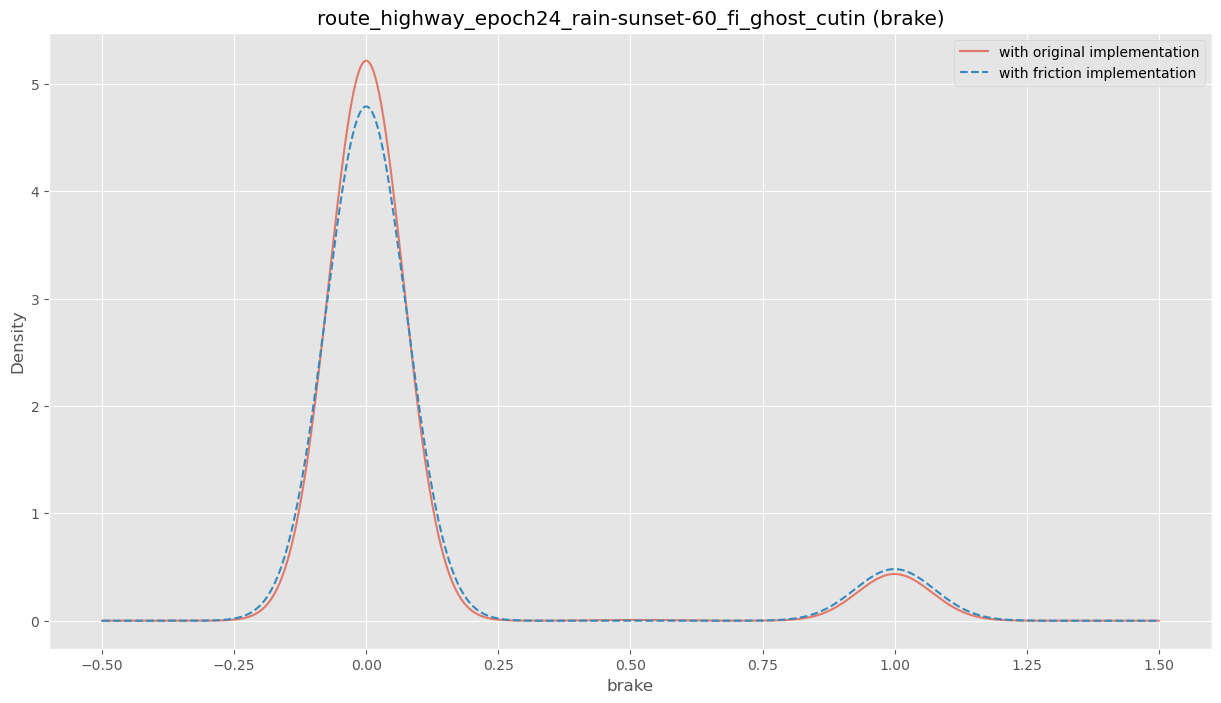

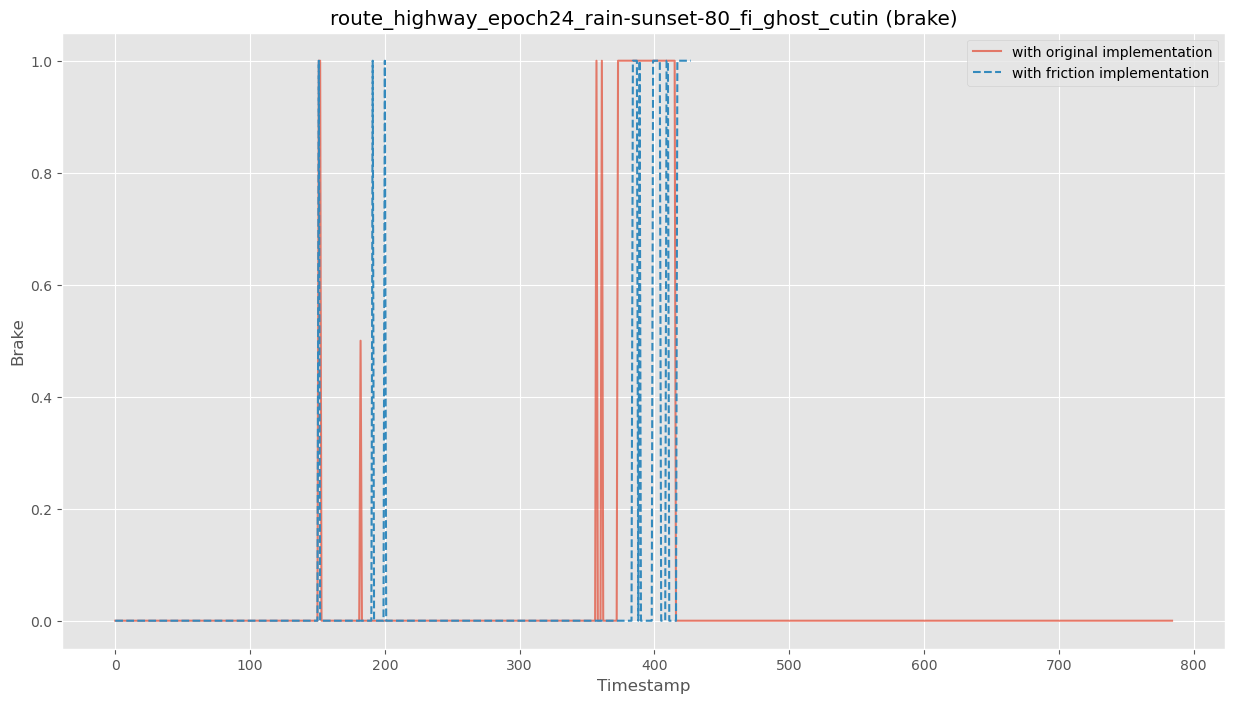

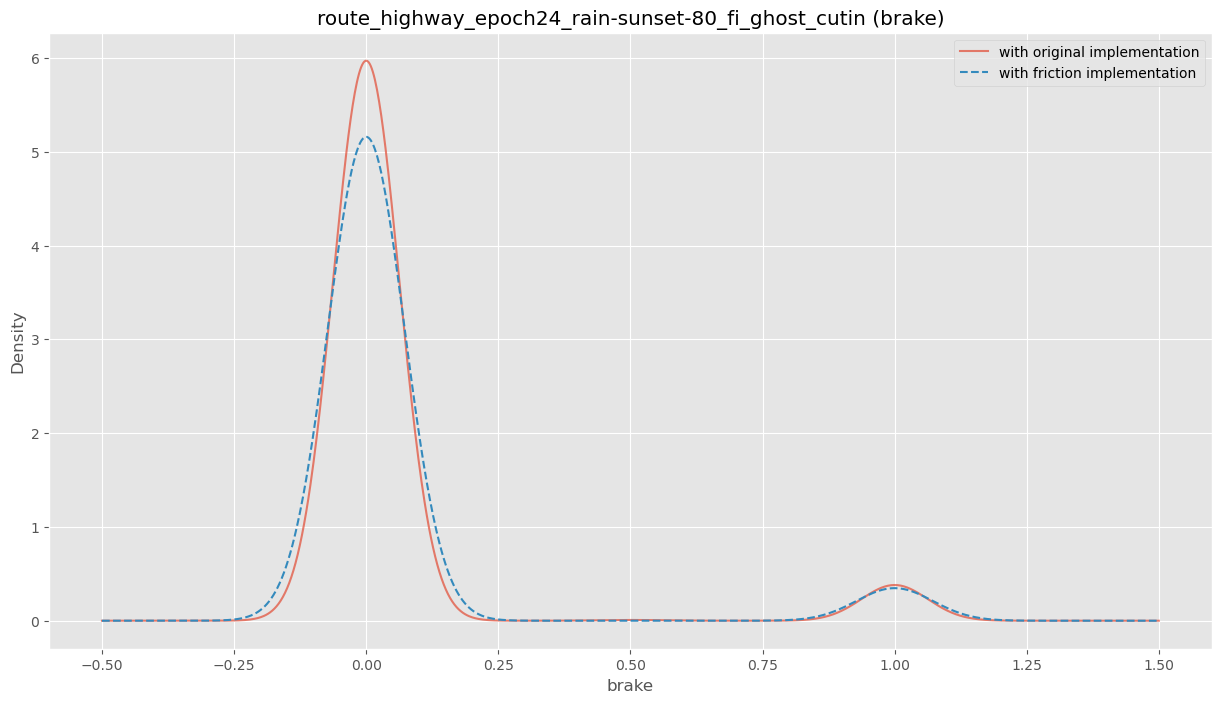

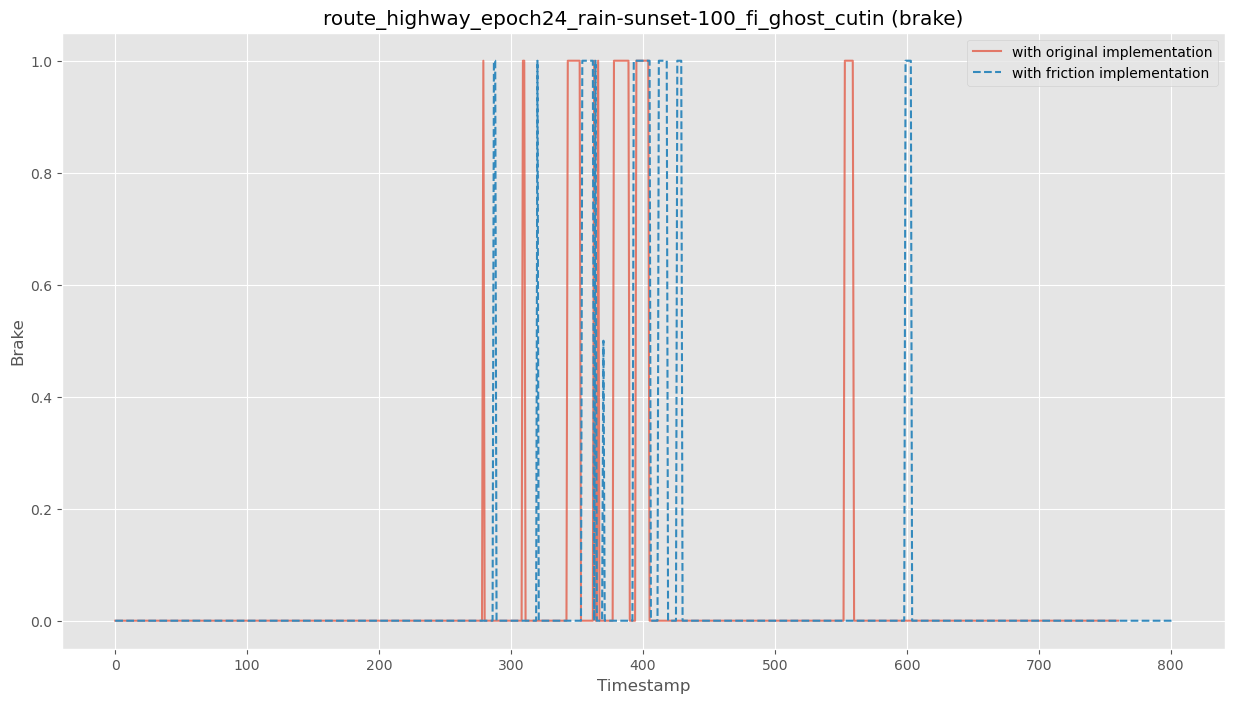

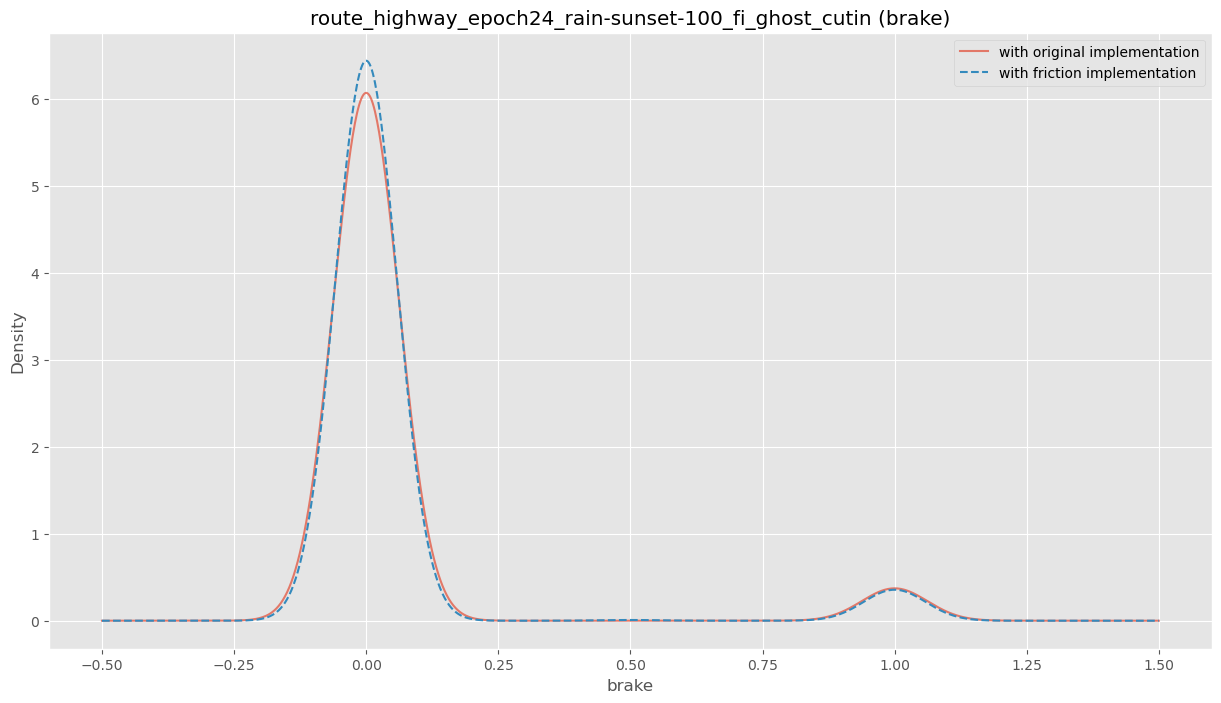

In [43]:
for weather in range(len(txt_lists_fric)):
    plt.figure(figsize=(15,8))
    df_orig_brake = pd.DataFrame()

    for i in range(0, len(df_array_orig[weather])):
        if(df_array_orig[weather][i]['brake'].dtypes == 'object'):
            print(i)
        else:
            if not df_array_orig[weather][i]['brake'].isnull().values.any():
                df_orig_brake["Run"+str(i)] = df_array_orig[weather][i]['brake']

    median_orig_brake = df_orig_brake.median(axis=1)

    plt.plot(median_orig_brake, alpha=0.7)


    df_fric_brake = pd.DataFrame()

    for i in range(0, len(df_array_fric[weather])):
        if(df_array_fric[weather][i]['brake'].dtypes == 'object'):
            print(i)
        else:
            if not df_array_fric[weather][i]['brake'].isnull().values.any():
                df_fric_brake["Run"+str(i)] = df_array_fric[weather][i]['brake']

    median_fric_brake = df_fric_brake.median(axis=1)
    
    all_medians[weather][5][0] = median_orig_brake
    all_medians[weather][5][1] = median_fric_brake
    
    plt.plot(median_fric_brake, '--')
    
    plt.title(subfolders[weather])
    plt.legend(friction_legend)
    plt.xlabel("Timestamp")
    plt.ylabel("Brake")
    plt.title(subfolders[weather] + " (brake)")
    plt.show()
    
    plt.figure(figsize=(15,8))
    plt.xlabel("brake")
    plt.ylabel("Density")
    median_orig_brake.plot.density(alpha=0.7)
    median_fric_brake.plot.density(style='--')
    plt.title(subfolders[weather] + " (brake)")
    plt.legend(friction_legend)
    plt.show()
    

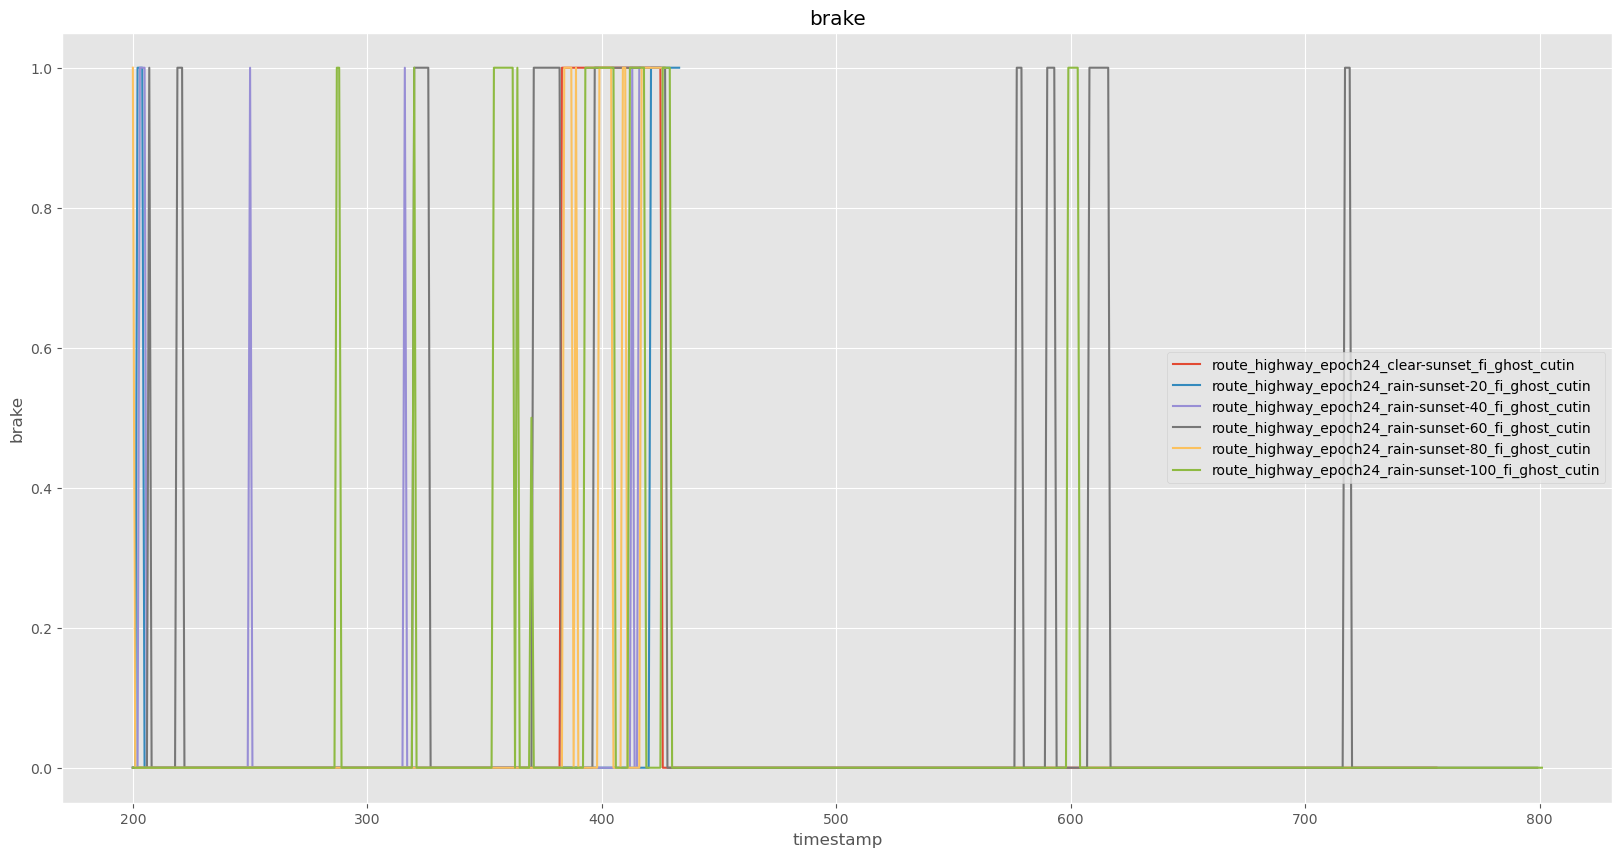

In [44]:
plt.figure(figsize=(20,10))

for weather in range(len(txt_lists_fric)):
    
#     df_orig_brake = pd.DataFrame()

#     for i in range(0, len(df_array_orig[weather])):
#         if(df_array_orig[weather][i]['brake'].dtypes == 'brake'):
#             print(i)
#         else:
#             if not df_array_orig[weather][i]['brake'].isnull().values.any():
#                 df_orig_brake["Run"+str(i)] = df_array_orig[weather][i]['brake']

#     median_orig_brake = df_orig_brake.median(axis=1)


#     plt.plot(median_orig_brake[200:], alpha=0.7)


    df_fric_brake = pd.DataFrame()

    for i in range(0, len(df_array_fric[weather])):
        if(df_array_fric[weather][i]['brake'].dtypes == 'object'):
            print(i)
        else:
            if not df_array_fric[weather][i]['brake'].isnull().values.any() :
                df_fric_brake["Run"+str(i)] = df_array_fric[weather][i]['brake']

    median_fric_brake = df_fric_brake.median(axis=1)

    plt.plot(median_fric_brake[200:])

    # plt.axis('equal')
plt.xlabel("timestamp")
plt.ylabel("brake")
plt.title("brake")
plt.legend(full_legend)
plt.show()

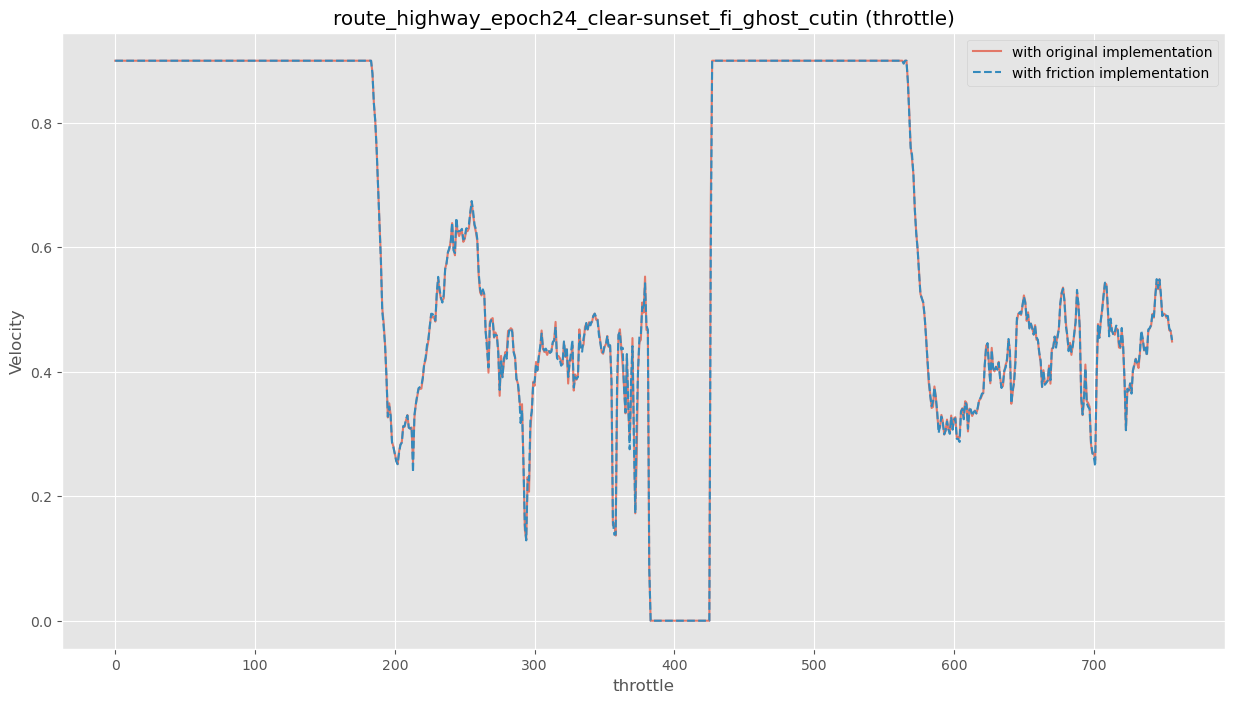

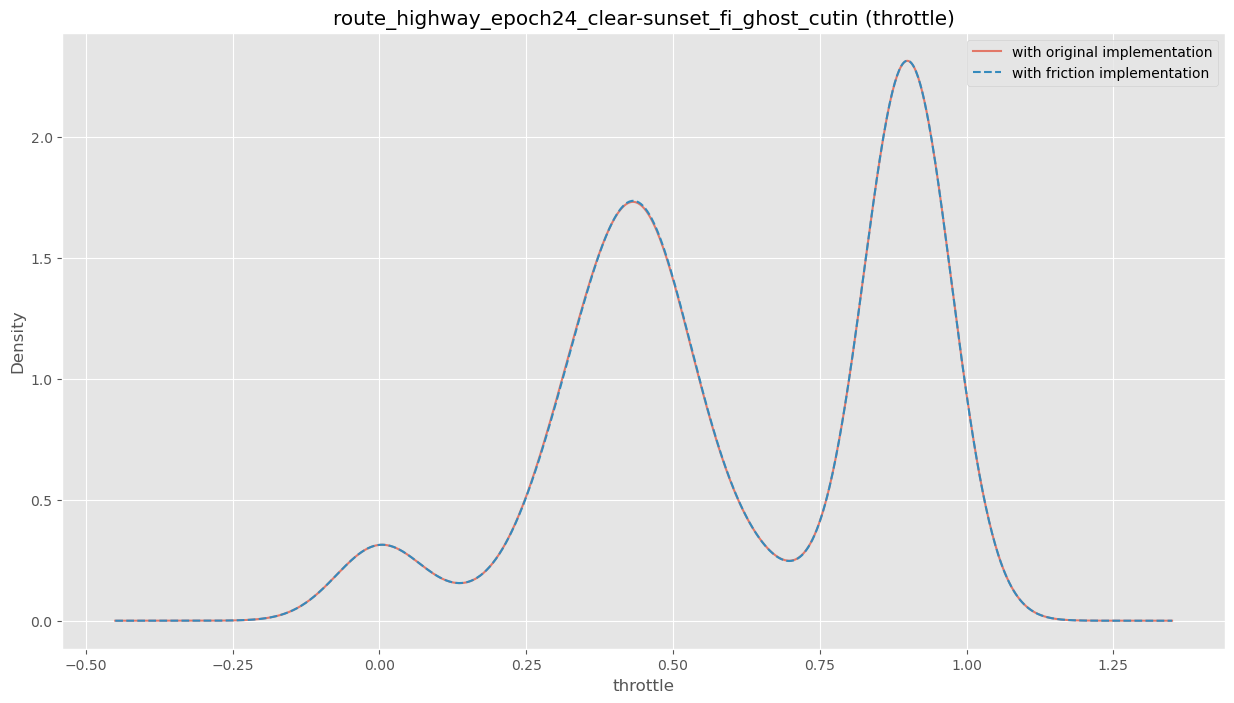

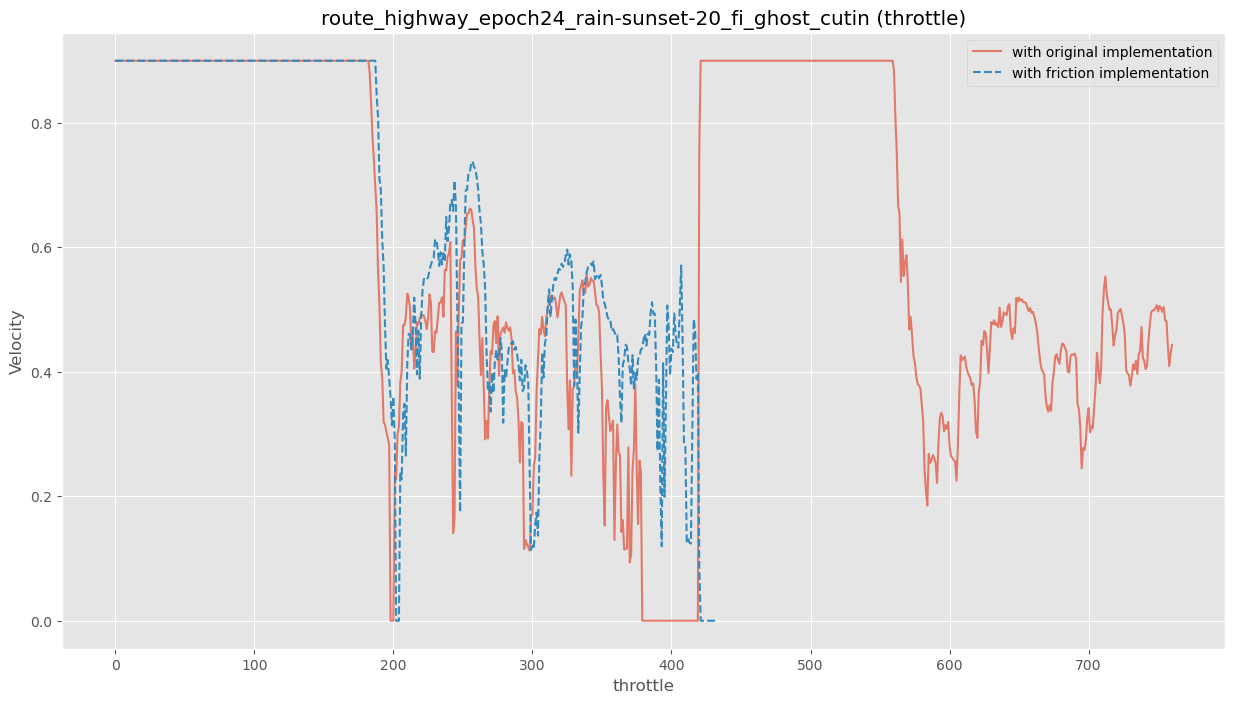

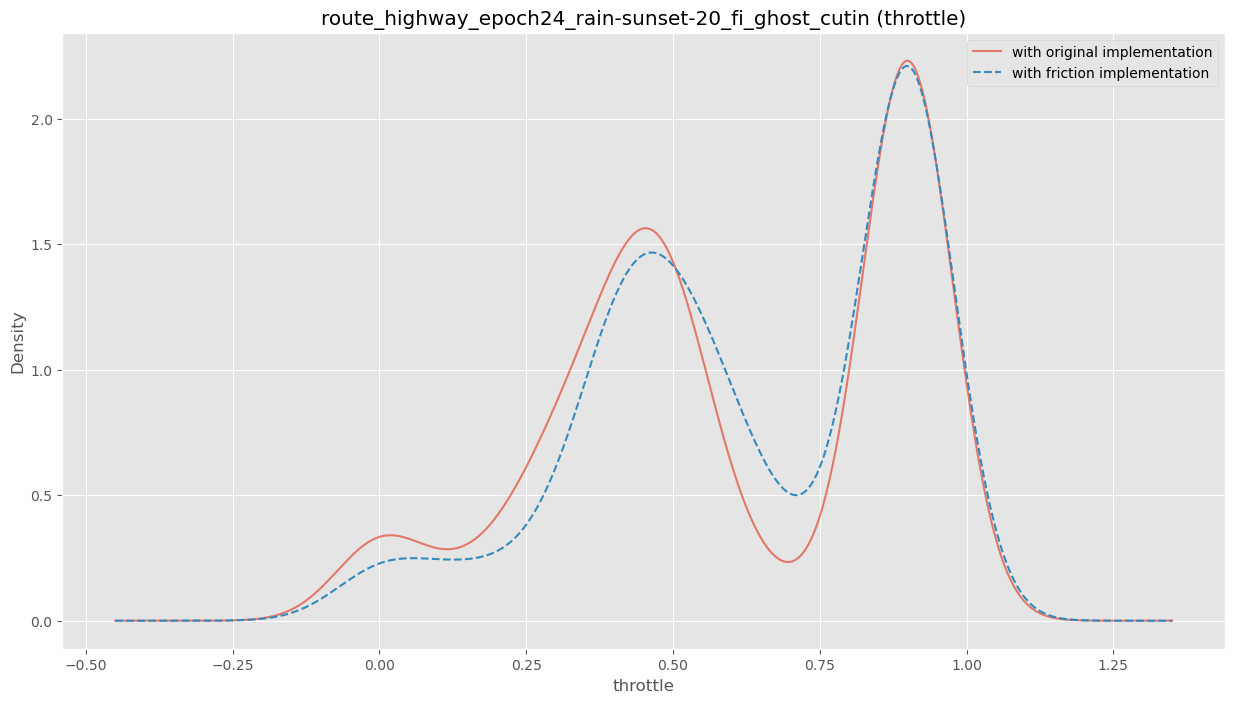

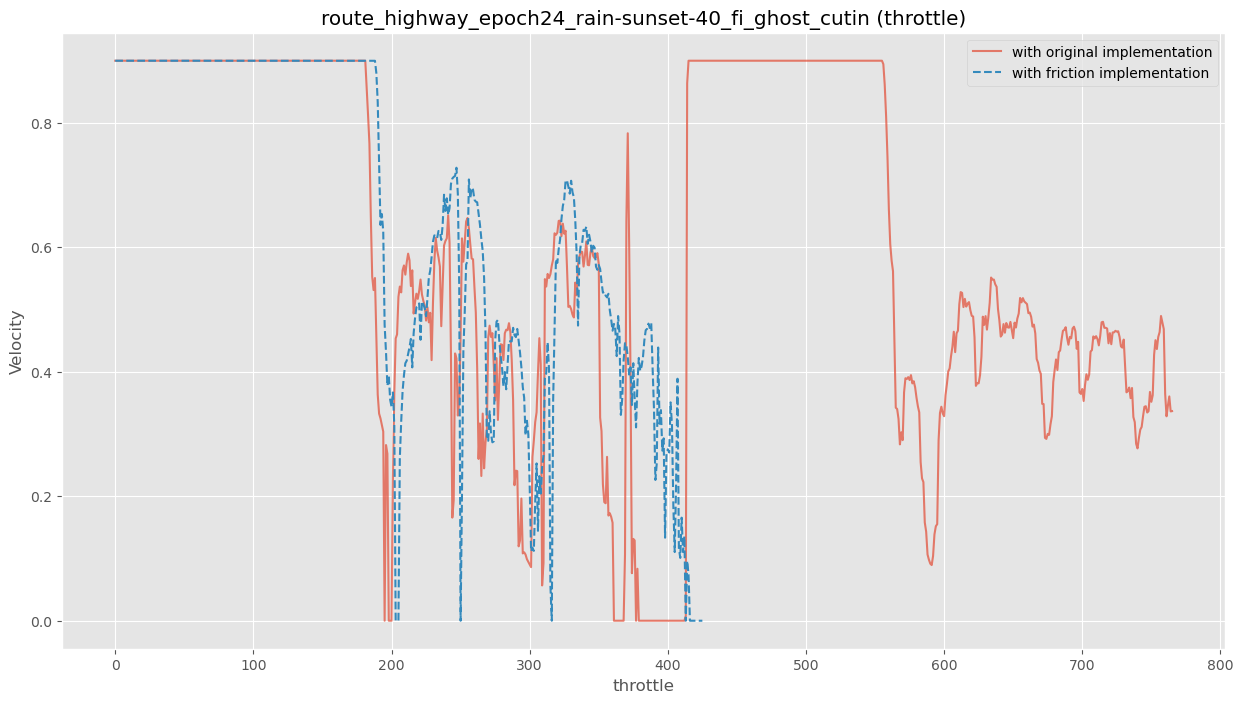

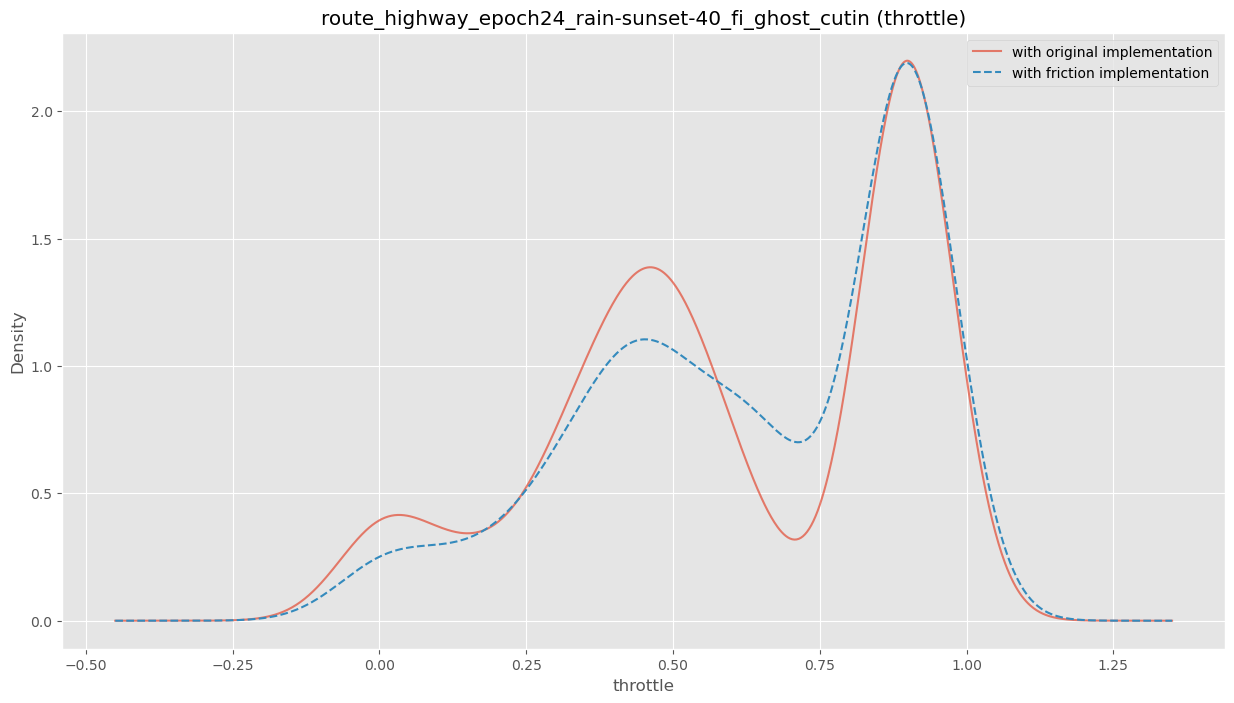

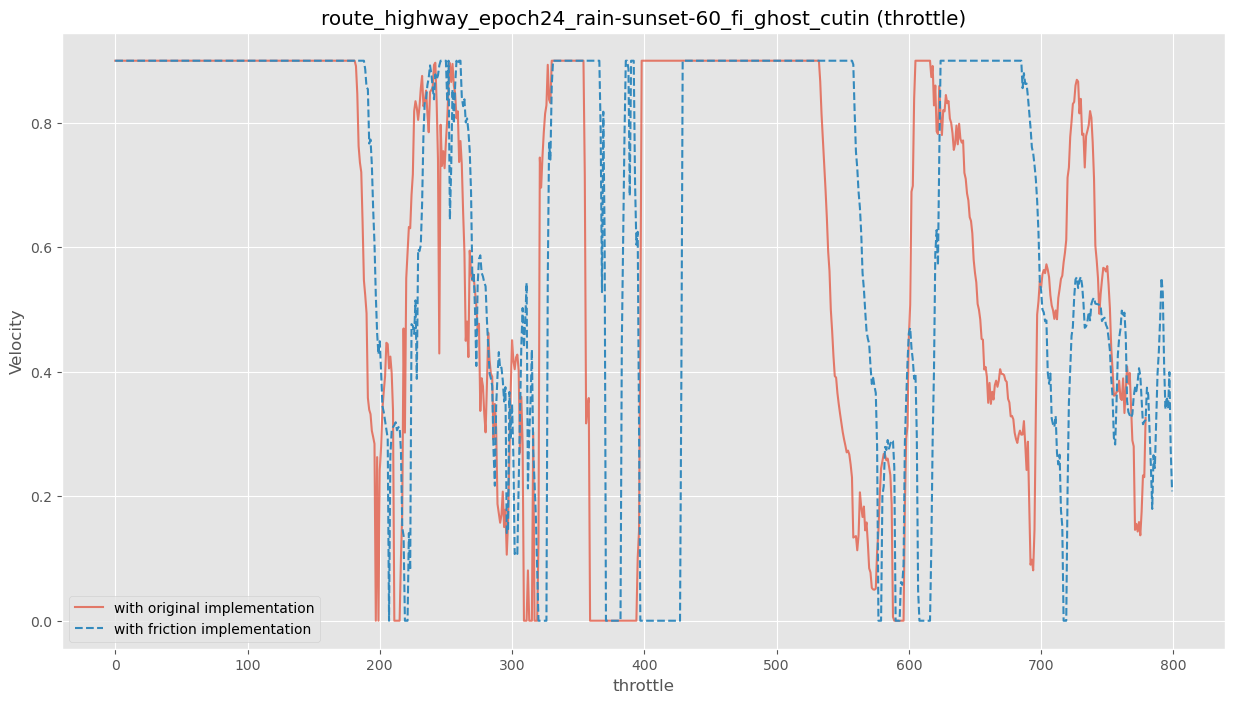

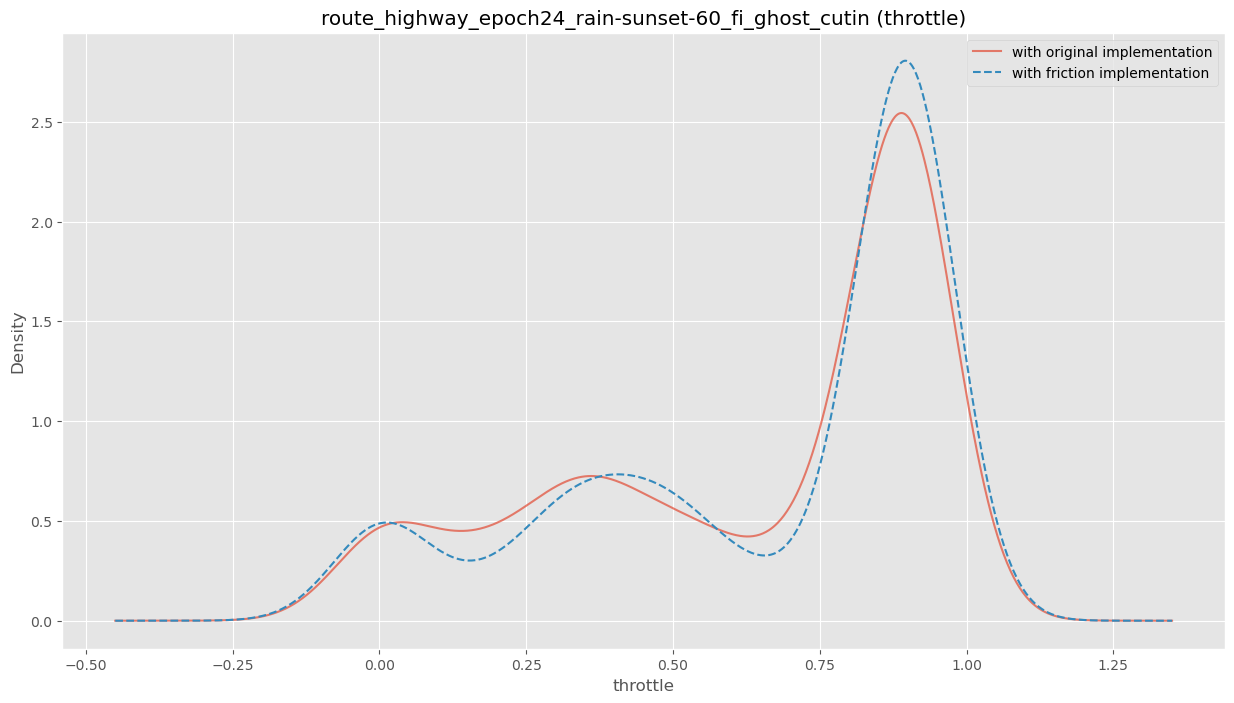

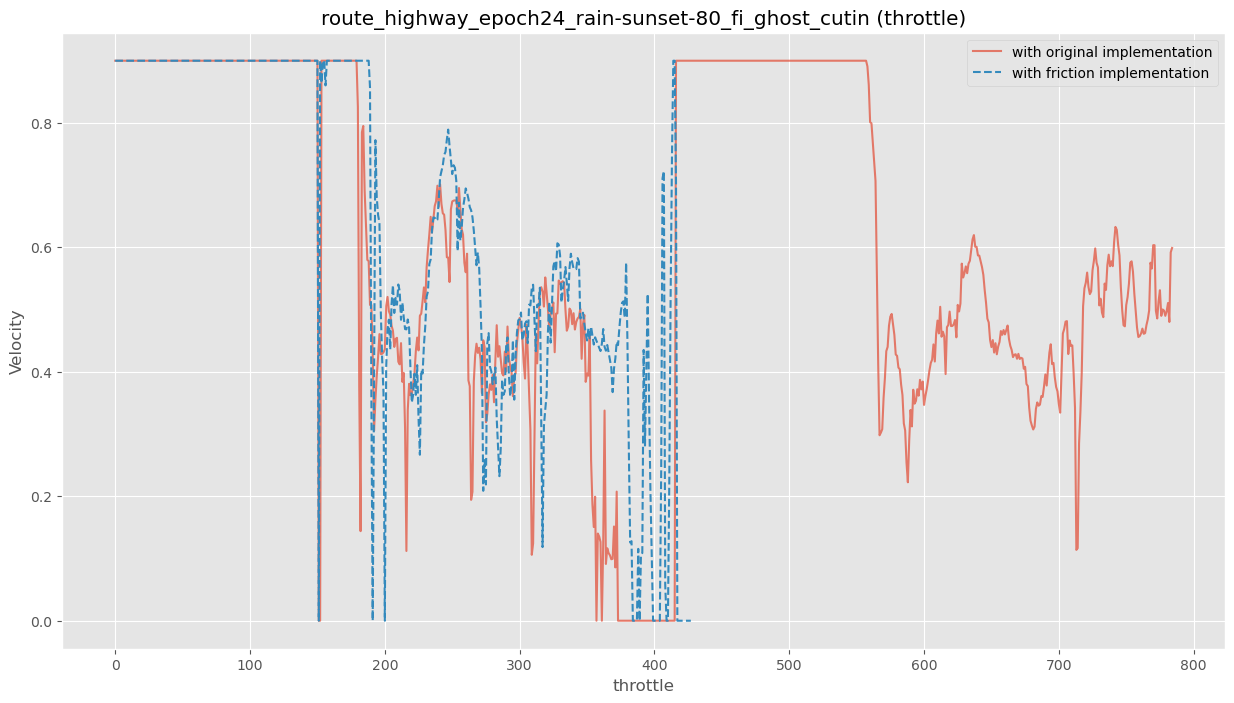

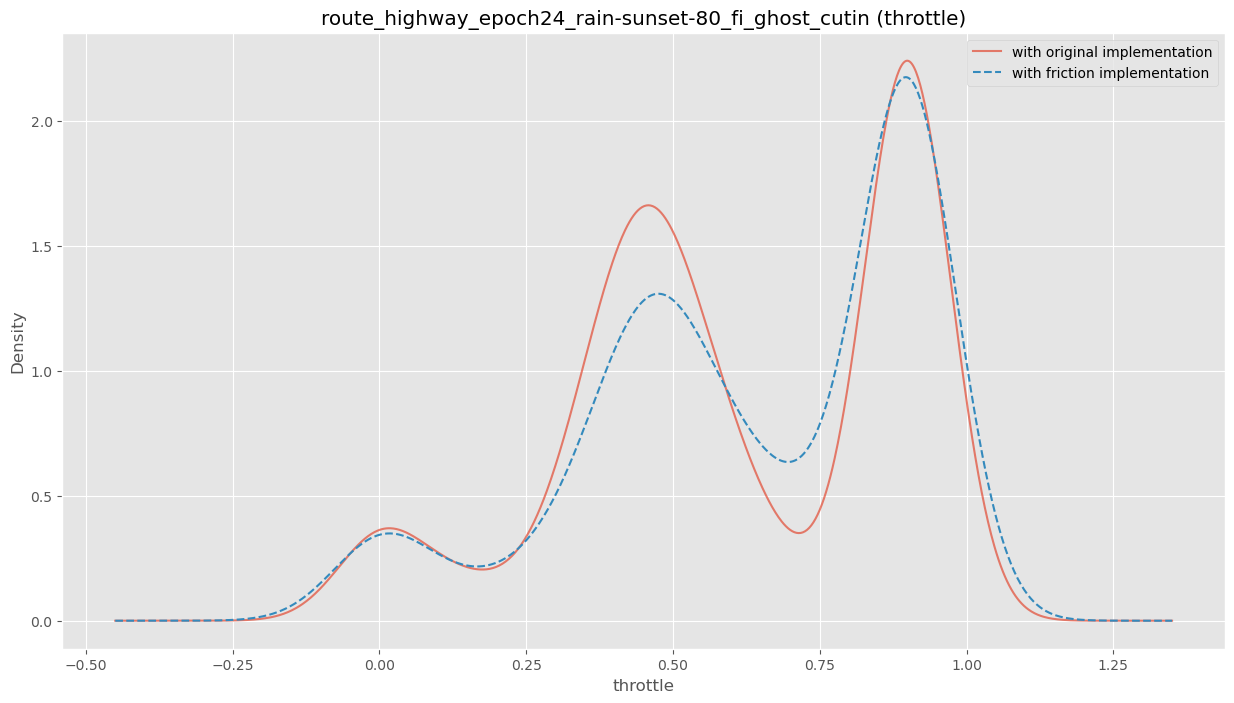

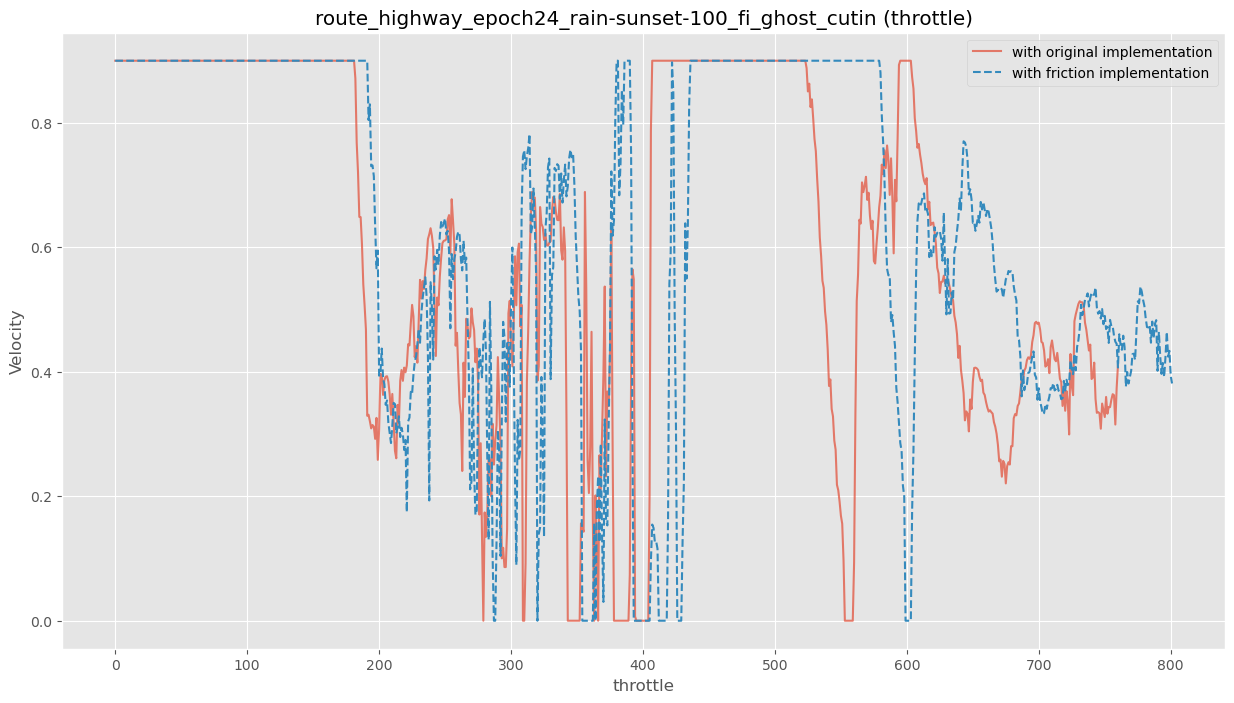

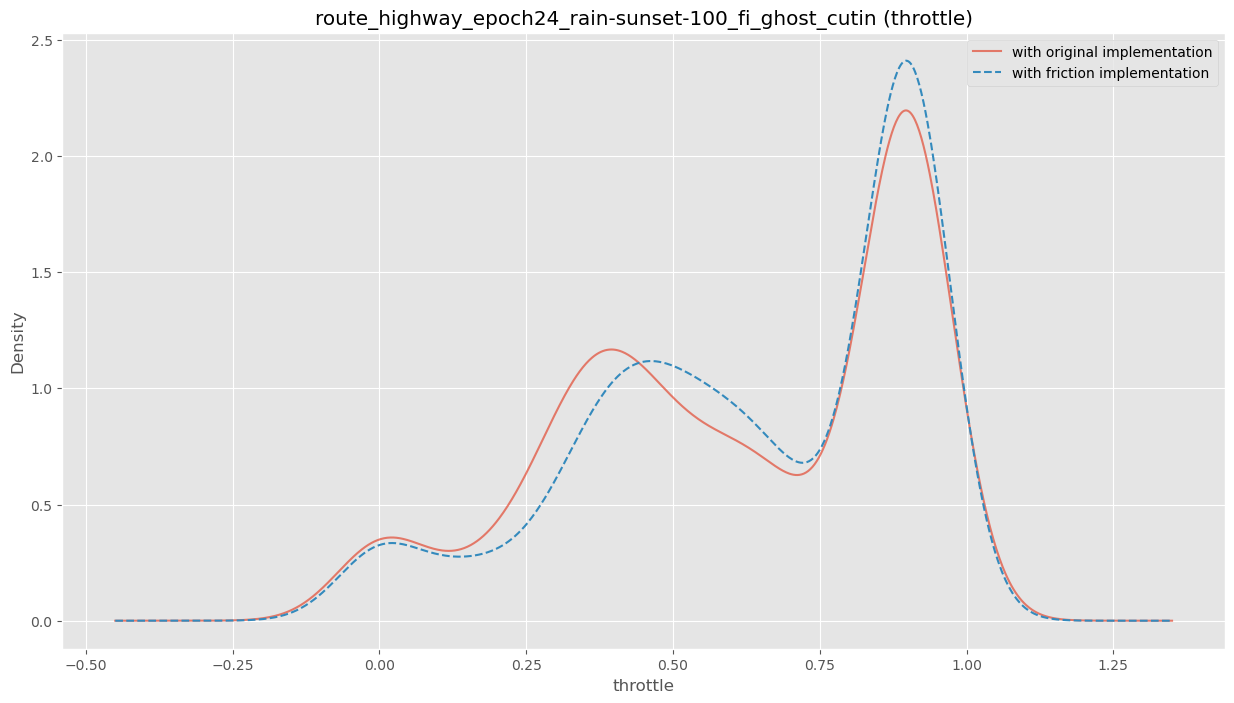

In [45]:
for weather in range(len(txt_lists_fric)):
    plt.figure(figsize=(15,8))
    df_orig_throttle = pd.DataFrame()

    for i in range(0, len(df_array_orig[weather])):
        if(df_array_orig[weather][i]['throttle'].dtypes == 'object'):
            print(i)
        else:
            if not df_array_orig[weather][i]['throttle'].isnull().values.any():
                df_orig_throttle["Run"+str(i)] = df_array_orig[weather][i]['throttle']

    median_orig_throttle = df_orig_throttle.median(axis=1)

    plt.plot(median_orig_throttle, alpha=0.7)


    df_fric_throttle = pd.DataFrame()

    for i in range(0, len(df_array_fric[weather])):
        if(df_array_fric[weather][i]['throttle'].dtypes == 'object'):
            print(i)
        else:
            if not df_array_fric[weather][i]['throttle'].isnull().values.any():
                df_fric_throttle["Run"+str(i)] = df_array_fric[weather][i]['throttle']

    median_fric_throttle = df_fric_throttle.median(axis=1)
    
    all_medians[weather][6][0] = median_orig_throttle
    all_medians[weather][6][1] = median_fric_throttle
    
    plt.plot(median_fric_throttle, '--')
    
    plt.title(subfolders[weather])
    plt.legend(friction_legend)
    plt.xlabel("throttle")
    plt.ylabel("Velocity")
    plt.title(subfolders[weather] + " (throttle)")
    plt.show()
    
    plt.figure(figsize=(15,8))
    plt.xlabel("throttle")
    plt.ylabel("Density")
    median_orig_throttle.plot.density(alpha=0.7)
    median_fric_throttle.plot.density(style='--')
    plt.title(subfolders[weather] + " (throttle)")
    plt.legend(friction_legend)
    plt.show()
    

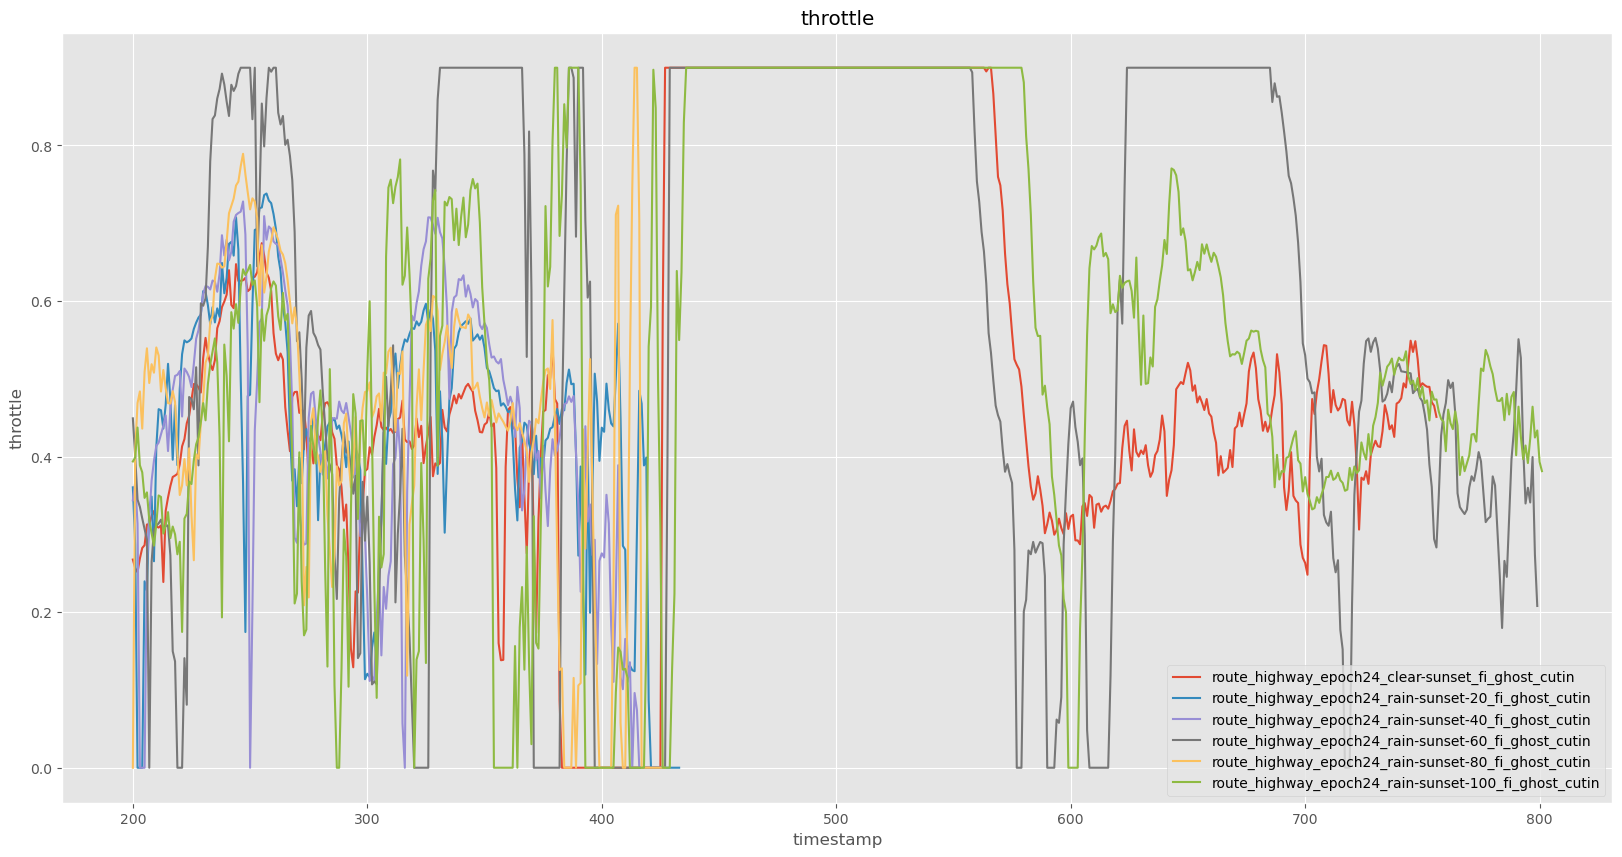

In [46]:
plt.figure(figsize=(20,10))

for weather in range(len(txt_lists_fric)):
    
#     df_orig_throttle = pd.DataFrame()

#     for i in range(0, len(df_array_orig[weather])):
#         if(df_array_orig[weather][i]['throttle'].dtypes == 'throttle'):
#             print(i)
#         else:
#             if not df_array_orig[weather][i]['throttle'].isnull().values.any():
#                 df_orig_throttle["Run"+str(i)] = df_array_orig[weather][i]['throttle']

#     median_orig_throttle = df_orig_throttle.median(axis=1)


#     plt.plot(median_orig_throttle[200:], alpha=0.7)


    df_fric_throttle = pd.DataFrame()

    for i in range(0, len(df_array_fric[weather])):
        if(df_array_fric[weather][i]['throttle'].dtypes == 'object'):
            print(i)
        else:
            if not df_array_fric[weather][i]['throttle'].isnull().values.any() :
                df_fric_throttle["Run"+str(i)] = df_array_fric[weather][i]['throttle']

    median_fric_throttle = df_fric_throttle.median(axis=1)

    plt.plot(median_fric_throttle[200:])

    # plt.axis('equal')
plt.xlabel("timestamp")
plt.ylabel("throttle")
plt.title("throttle")
plt.legend(full_legend)
plt.show()

## Dynamic time warping (DTW) for cvip
### measuring similarity between two temporal sequences

In [47]:
all_dtw = [[0] * len(attribute_order)  for i in range(len(txt_lists_fric))]

for i in range(len(txt_lists_fric)):
    for j in range(len(attribute_order)):
        all_dtw[i][j] = dtw.distance(all_medians[i][j][0], all_medians[i][j][1])

In [54]:
for i in range(len(txt_lists_fric)):
    for j in range(len(attribute_order)):
        all_dtw[i][j] = round(all_dtw[i][j],2)

In [56]:
df = pd.DataFrame(all_dtw, columns = attribute_order, dtype = float)
df.index = subfolders
df.to_csv("reduced_friction_rain.csv")
df

x       y      v  \
route_highway_epoch24_clear-sunset_fi_ghost_cutin     0.02    0.11   0.07   
route_highway_epoch24_rain-sunset-20_fi_ghost_cutin   4.05  566.01  43.96   
route_highway_epoch24_rain-sunset-40_fi_ghost_cutin   4.08  602.74  43.57   
route_highway_epoch24_rain-sunset-60_fi_ghost_cutin   0.11    1.54   5.27   
route_highway_epoch24_rain-sunset-80_fi_ghost_cutin   4.12  678.73  44.49   
route_highway_epoch24_rain-sunset-100_fi_ghost_cutin  1.05    2.02   4.67   

                                                        cvip  steer  brake  \
route_highway_epoch24_clear-sunset_fi_ghost_cutin       0.09   0.01   0.00   
route_highway_epoch24_rain-sunset-20_fi_ghost_cutin   632.83   0.07   4.00   
route_highway_epoch24_rain-sunset-40_fi_ghost_cutin   660.07   0.06   3.32   
route_highway_epoch24_rain-sunset-60_fi_ghost_cutin     4.18   0.09   1.12   
route_highway_epoch24_rain-sunset-80_fi_ghost_cutin   712.86   0.07   3.64   
route_highway_epoch24_rain-sunset-100_fi_ghost_cutin    4.10   0.27   0.50   

                                                      throttle  
route_highway_epoch24_clear-sunset_fi_ghost_cutin         0.15  
route_highway_epoch24_rain-sunset-20_fi_ghost_cutin       3.09  
route_highway_epoch24_rain-sunset-40_fi_ghost_cutin       3.18  
route_highway_epoch24_rain-sunset-60_fi_ghost_cutin       2.02  
route_highway_epoch24_rain-sunset-80_fi_ghost_cutin       3.33  
route_highway_epoch24_rain-sunset-100_fi_ghost_cutin      1.65

## KS Test for cvip

In [49]:
import scipy as sp

In [50]:
all_ks = np.empty((len(txt_lists_fric), len(attribute_order), 2))
# [[0] * len(attribute_order)  for i in range(len(txt_lists_fric)-1)]
for i in range(len(txt_lists_fric)-1):
    for j in range(len(attribute_order)):
        ks_test = sp.stats.ks_2samp(all_medians[i][j][0], all_medians[i][j][1])
        all_ks[i][j][0] = ks_test.pvalue
        all_ks[i][j][1] = ks_test.statistic

C:\Users\kilob\AppData\Local\Temp\ipykernel_10064\3582443724.py:5: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  ks_test = sp.stats.ks_2samp(all_medians[i][j][0], all_medians[i][j][1])


In [51]:
df = pd.DataFrame(all_ks[:,:,0], columns = attribute_order, dtype = float)
df.index = subfolders
df

x  \
route_highway_epoch24_clear-sunset_fi_ghost_cutin      3.265366e-01   
route_highway_epoch24_rain-sunset-20_fi_ghost_cutin    3.682660e-43   
route_highway_epoch24_rain-sunset-40_fi_ghost_cutin    2.181433e-47   
route_highway_epoch24_rain-sunset-60_fi_ghost_cutin    4.027659e-03   
route_highway_epoch24_rain-sunset-80_fi_ghost_cutin    1.207720e-51   
route_highway_epoch24_rain-sunset-100_fi_ghost_cutin  8.403567e-312   

                                                                  y  \
route_highway_epoch24_clear-sunset_fi_ghost_cutin      1.000000e+00   
route_highway_epoch24_rain-sunset-20_fi_ghost_cutin    6.946315e-40   
route_highway_epoch24_rain-sunset-40_fi_ghost_cutin    1.085873e-42   
route_highway_epoch24_rain-sunset-60_fi_ghost_cutin    1.385080e-02   
route_highway_epoch24_rain-sunset-80_fi_ghost_cutin    1.074657e-48   
route_highway_epoch24_rain-sunset-100_fi_ghost_cutin  8.403567e-312   

                                                                  v  \
route_highway_epoch24_clear-sunset_fi_ghost_cutin      9.984105e-01   
route_highway_epoch24_rain-sunset-20_fi_ghost_cutin    1.051123e-03   
route_highway_epoch24_rain-sunset-40_fi_ghost_cutin    1.812655e-03   
route_highway_epoch24_rain-sunset-60_fi_ghost_cutin    1.427331e-05   
route_highway_epoch24_rain-sunset-80_fi_ghost_cutin    1.257009e-04   
route_highway_epoch24_rain-sunset-100_fi_ghost_cutin  8.403567e-312   

                                                               cvip  \
route_highway_epoch24_clear-sunset_fi_ghost_cutin      1.000000e+00   
route_highway_epoch24_rain-sunset-20_fi_ghost_cutin    1.267833e-67   
route_highway_epoch24_rain-sunset-40_fi_ghost_cutin    1.347667e-72   
route_highway_epoch24_rain-sunset-60_fi_ghost_cutin    2.901513e-03   
route_highway_epoch24_rain-sunset-80_fi_ghost_cutin    1.038252e-85   
route_highway_epoch24_rain-sunset-100_fi_ghost_cutin  8.403567e-312   

                                                              steer  \
route_highway_epoch24_clear-sunset_fi_ghost_cutin      9.999818e-01   
route_highway_epoch24_rain-sunset-20_fi_ghost_cutin    1.613939e-04   
route_highway_epoch24_rain-sunset-40_fi_ghost_cutin    1.678414e-06   
route_highway_epoch24_rain-sunset-60_fi_ghost_cutin    1.334556e-09   
route_highway_epoch24_rain-sunset-80_fi_ghost_cutin    1.721549e-04   
route_highway_epoch24_rain-sunset-100_fi_ghost_cutin  8.403567e-312   

                                                              brake  \
route_highway_epoch24_clear-sunset_fi_ghost_cutin      1.000000e+00   
route_highway_epoch24_rain-sunset-20_fi_ghost_cutin    9.994739e-01   
route_highway_epoch24_rain-sunset-40_fi_ghost_cutin    9.965365e-01   
route_highway_epoch24_rain-sunset-60_fi_ghost_cutin    9.999937e-01   
route_highway_epoch24_rain-sunset-80_fi_ghost_cutin    1.000000e+00   
route_highway_epoch24_rain-sunset-100_fi_ghost_cutin  8.403567e-312   

                                                           throttle  
route_highway_epoch24_clear-sunset_fi_ghost_cutin      1.000000e+00  
route_highway_epoch24_rain-sunset-20_fi_ghost_cutin    2.052007e-04  
route_highway_epoch24_rain-sunset-40_fi_ghost_cutin    2.154074e-03  
route_highway_epoch24_rain-sunset-60_fi_ghost_cutin    4.544797e-03  
route_highway_epoch24_rain-sunset-80_fi_ghost_cutin    2.600936e-02  
route_highway_epoch24_rain-sunset-100_fi_ghost_cutin  8.403567e-312

In [52]:
df = pd.DataFrame(all_ks[:,:,1], columns = attribute_order, dtype = float)
df.index = subfolders
df

x  \
route_highway_epoch24_clear-sunset_fi_ghost_cutin      4.887715e-02   
route_highway_epoch24_rain-sunset-20_fi_ghost_cutin    4.147556e-01   
route_highway_epoch24_rain-sunset-40_fi_ghost_cutin    4.361049e-01   
route_highway_epoch24_rain-sunset-60_fi_ghost_cutin    8.804487e-02   
route_highway_epoch24_rain-sunset-80_fi_ghost_cutin    4.521995e-01   
route_highway_epoch24_rain-sunset-100_fi_ghost_cutin  8.403567e-312   

                                                                  y  \
route_highway_epoch24_clear-sunset_fi_ghost_cutin      1.321004e-03   
route_highway_epoch24_rain-sunset-20_fi_ghost_cutin    3.990051e-01   
route_highway_epoch24_rain-sunset-40_fi_ghost_cutin    4.144265e-01   
route_highway_epoch24_rain-sunset-60_fi_ghost_cutin    7.875000e-02   
route_highway_epoch24_rain-sunset-80_fi_ghost_cutin    4.394726e-01   
route_highway_epoch24_rain-sunset-100_fi_ghost_cutin  8.403567e-312   

                                                                  v  \
route_highway_epoch24_clear-sunset_fi_ghost_cutin      1.981506e-02   
route_highway_epoch24_rain-sunset-20_fi_ghost_cutin    1.160279e-01   
route_highway_epoch24_rain-sunset-40_fi_ghost_cutin    1.122777e-01   
route_highway_epoch24_rain-sunset-60_fi_ghost_cutin    1.217949e-01   
route_highway_epoch24_rain-sunset-80_fi_ghost_cutin    1.312489e-01   
route_highway_epoch24_rain-sunset-100_fi_ghost_cutin  8.403567e-312   

                                                               cvip  \
route_highway_epoch24_clear-sunset_fi_ghost_cutin      5.284016e-03   
route_highway_epoch24_rain-sunset-20_fi_ghost_cutin    5.154357e-01   
route_highway_epoch24_rain-sunset-40_fi_ghost_cutin    5.355116e-01   
route_highway_epoch24_rain-sunset-60_fi_ghost_cutin    9.035256e-02   
route_highway_epoch24_rain-sunset-80_fi_ghost_cutin    5.760075e-01   
route_highway_epoch24_rain-sunset-100_fi_ghost_cutin  8.403567e-312   

                                                              steer  \
route_highway_epoch24_clear-sunset_fi_ghost_cutin      1.585205e-02   
route_highway_epoch24_rain-sunset-20_fi_ghost_cutin    1.296772e-01   
route_highway_epoch24_rain-sunset-40_fi_ghost_cutin    1.588093e-01   
route_highway_epoch24_rain-sunset-60_fi_ghost_cutin    1.626603e-01   
route_highway_epoch24_rain-sunset-80_fi_ghost_cutin    1.291059e-01   
route_highway_epoch24_rain-sunset-100_fi_ghost_cutin  8.403566e-312   

                                                              brake  \
route_highway_epoch24_clear-sunset_fi_ghost_cutin      0.000000e+00   
route_highway_epoch24_rain-sunset-20_fi_ghost_cutin    2.095230e-02   
route_highway_epoch24_rain-sunset-40_fi_ghost_cutin    2.379902e-02   
route_highway_epoch24_rain-sunset-60_fi_ghost_cutin    1.432692e-02   
route_highway_epoch24_rain-sunset-80_fi_ghost_cutin    3.211501e-03   
route_highway_epoch24_rain-sunset-100_fi_ghost_cutin  8.403567e-312   

                                                           throttle  
route_highway_epoch24_clear-sunset_fi_ghost_cutin      9.247028e-03  
route_highway_epoch24_rain-sunset-20_fi_ghost_cutin    1.280149e-01  
route_highway_epoch24_rain-sunset-40_fi_ghost_cutin    1.108803e-01  
route_highway_epoch24_rain-sunset-60_fi_ghost_cutin    8.717949e-02  
route_highway_epoch24_rain-sunset-80_fi_ghost_cutin    8.774927e-02  
route_highway_epoch24_rain-sunset-100_fi_ghost_cutin  8.403567e-312

You reject the null hypothesis that the two samples were drawn from the same distribution if the p-value is less than your significance level.
**pvalue=4.2177381979173086e-06**